# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pip install pymorphy2
#pip install -U pymorphy2-dicts-ru
import pymorphy2

# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



<img src='kmean.jpg'>

**После каждой итерации Q уменьшается. Всевозможных матриц $r_n,_k$ = $k^N$ (выбрать в первой строке позицию для единицы, выбрать во второй строке позицию для единцы и т.д). Значит алгоритм сойдётся не более чем за $k^N$ шагов.**

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

<img src='norm.jpg'>

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Докажем это для single(complete linkage). Пусть x,y соответственно минимальное(максимальное) расстояние от кластеров U,V до S. Пусть z - минимальное(максимальное) расстояние от объединения кластеров U,V до S.Тогда z будет либо x, либо y. Допустим, что это не так. Если z образованно точкой из U, и оно не равное x, то получается, что x - не минимальный(максимальный). То-же самое с y. Противоречие - значик z = x или y. Соотвественно z - это минимум(максимум) между x и y. Формулы выше ровно это и показывают.***

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, metric='euclidean', n_clusters=1,linkage='average',distance_threshold=None):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters=n_clusters
        self.distance_threshold=distance_threshold
        if distance_threshold is not None and n_clusters is not None:
            print('If distance_threshold is not None - n_clusters shoud be None')
            raise
            
        self.dist=None
        self.clusters=None
        self.ans=None
        self.Z=None
        
        
        if metric=='euclidean':
            self.metric=self.__eucl
        elif metric=='manhattan':
            self.metric=self.__manh
        elif metric=='cosine':
            self.metric=self.__cosine
        elif metric=='precomputed':
            self.metric=lambda x:x
        else:
            print('invalid metric')
            raise
        
        if linkage=='single':
            self.link=self.__single
        elif linkage=='complete':
            self.link=self.__compl
        elif linkage=='average':
            self.link=self.__aver
        else:
            print('invalid linkage')
            raise
    
    def __eucl(self,X):
        return np.sqrt(((X[...,np.newaxis]-X.T[np.newaxis])**2).sum(axis=1))
    
    def __manh(self,X):
        return (np.abs(X[...,np.newaxis]-X.T[np.newaxis])).sum(axis=1)    
    
    def __cosine(self,X):
        tmp=(X[...,np.newaxis]*X.T[np.newaxis]).sum(axis=1)
        norm=np.sqrt(tmp.diagonal())
        mask=norm==0
        norm[mask]=1
        return 1-tmp/norm[np.newaxis]/norm[...,np.newaxis]
    
    def __single(self,u,v):
        mask=self.dist[u]>self.dist[v]
        
        self.dist[u,mask]=self.dist[v,mask]
        self.dist[:,u]=self.dist[u]

        self.dist[v]=np.inf
        self.dist[:,v]=np.inf
        
        self.dist[u,u]=np.inf
            
    def __compl(self,u,v):
        mask=self.dist[u]<self.dist[v]
        
        self.dist[u][mask]=self.dist[v][mask]
        self.dist[:,u]=self.dist[u]
        
        self.dist[v]=np.inf
        self.dist[:,v]=np.inf
        
        self.dist[u,u]=np.inf
    
    def __aver(self,u,v):
        ai=len(self.clusters[u])
        aj=len(self.clusters[v])
        N=ai+aj
        ai/=N
        aj/=N
        
        self.dist[u]=ai*self.dist[u]+aj*self.dist[v]
        self.dist[:,u]=self.dist[u]
        
        self.dist[v]=np.inf
        self.dist[:,v]=np.inf
        
        self.dist[u,u]=np.inf
    
    def fit(self,x):
        self.dist=self.metric(x)
        n_clusters=N=cur_cluster=len(x)
        self.ans=np.arange(N)
        
        self.clusters=dict()
        for i in range(n_clusters):
            self.clusters[i]=[i]
            self.dist[i,i]=np.inf
        
        if self.n_clusters==1:
            self.Z=np.empty((N-1,4))
            cur_z=0
        
        while(n_clusters!=self.n_clusters):
            pos=self.dist.argmin()
            distanse=self.dist.ravel()[pos]
            if self.distance_threshold is not None:
                if distanse>self.distance_threshold:
                    break
            u=pos//N
            v=pos%N
            
            max_cluster=u if len(self.clusters[u])>=len(self.clusters[v]) else v
            min_cluster=u if max_cluster==v else v
            u,v=max_cluster,min_cluster
            
            if self.n_clusters==1:
                self.Z[cur_z]=[self.ans[self.clusters[u][0]],self.ans[self.clusters[v][0]],
                               max(0,distanse),len(self.clusters[u])+len(self.clusters[v])]
                cur_z+=1
                
            self.link(u,v)
            
            for i in self.clusters[v]:
                self.clusters[u].append(i)

            self.ans[self.clusters[u]]=cur_cluster

            cur_cluster+=1
            
            n_clusters-=1
            if(n_clusters==1):
                break
        return self
    
    def predict(self):
        return self.ans
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.fit(x)
        return self.predict()
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        if self.Z is not None:
            hierarchy.dendrogram(self.Z)
            plt.show()
        else:
            print('Tree must be full')
        

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

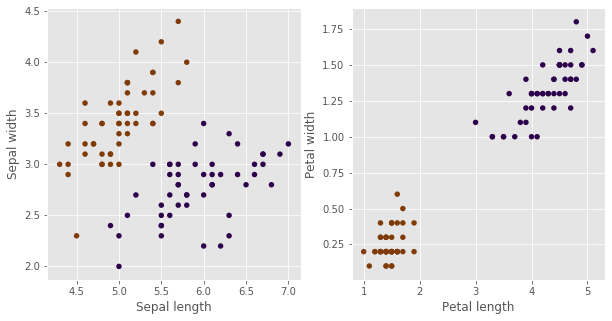

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0019981861114501953


In [6]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean',n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.003996372222900391


In [7]:
сustum_aggl.plot_dendrogram()

Tree must be full


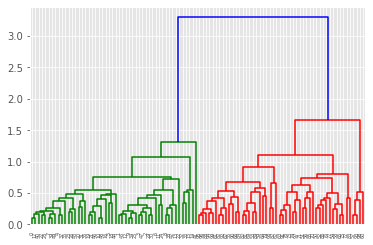

In [8]:
сustum_aggl = Clustering(metric='euclidean',n_clusters=1,linkage='average')
сustum_aggl.fit(x_iris)
сustum_aggl.plot_dendrogram()

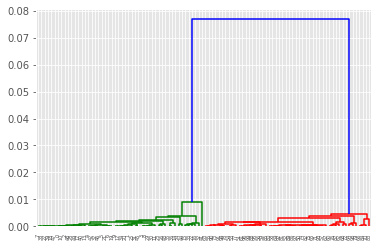

In [9]:
сustum_aggl = Clustering(metric='cosine',n_clusters=1,linkage='average')
сustum_aggl.fit(x_iris)
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

3) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [10]:
doc_to_title = {}
with open('docs_titles.tsv',encoding="utf8") as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


**Удаляю лишнее и разбиваю предложения на слова**

In [11]:
delete_words={'на','в','и','или','от','для','про','под','об','над','за','у','с','через','при','перед','от','о','по','на','к',
            'из','до','без'}

for key,line in doc_to_title.items():
    line=line.lower()
    tmp=list(line)
    for i, c in enumerate(line):
        if(not(c.isalpha() or c.isdigit())):
            tmp[i]=' '
    tmp=list(filter(lambda x: x not in delete_words,''.join(tmp).split()))
    doc_to_title[key]=tmp

**Нормализую слова**

In [12]:
morph = pymorphy2.MorphAnalyzer()
for key,lst in doc_to_title.items():
    doc_to_title[key]=[morph.parse(x)[0].normal_form for x in lst]

In [13]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

**Создаю векторы и вывожу дендограммы через косинусную метрику**

1


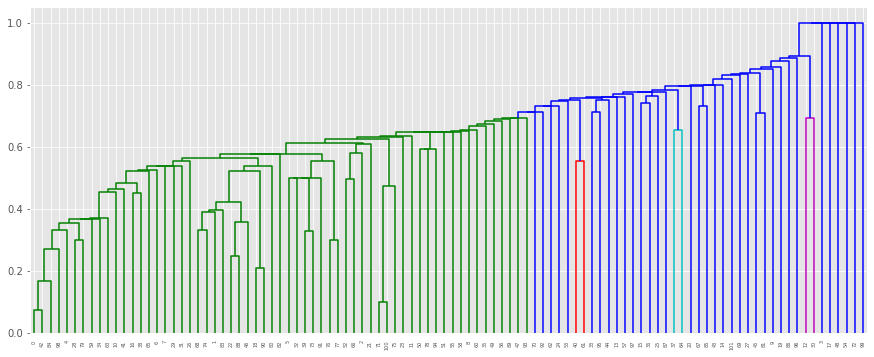

2


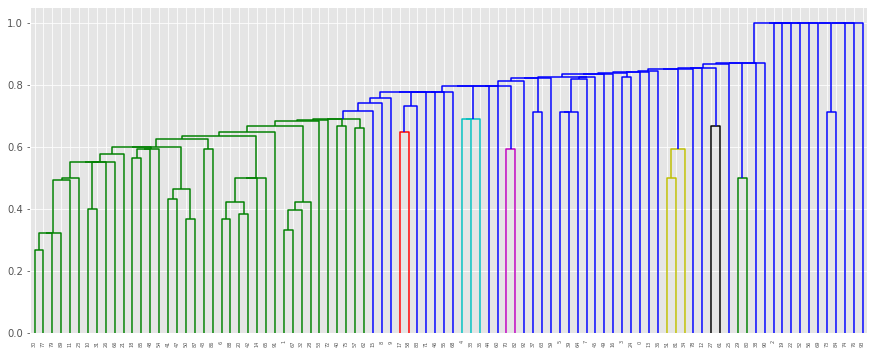

3


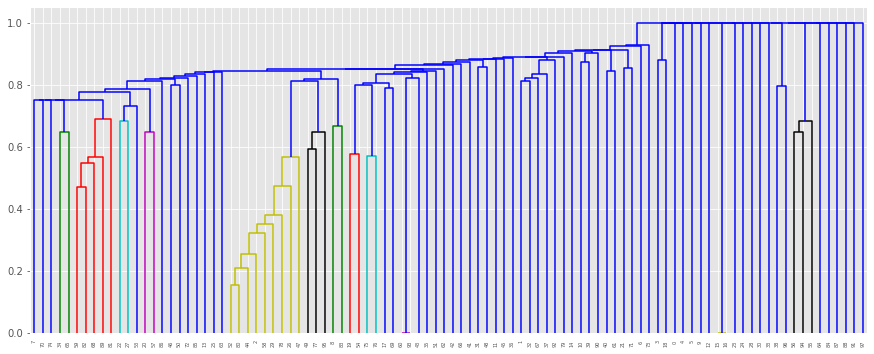

4


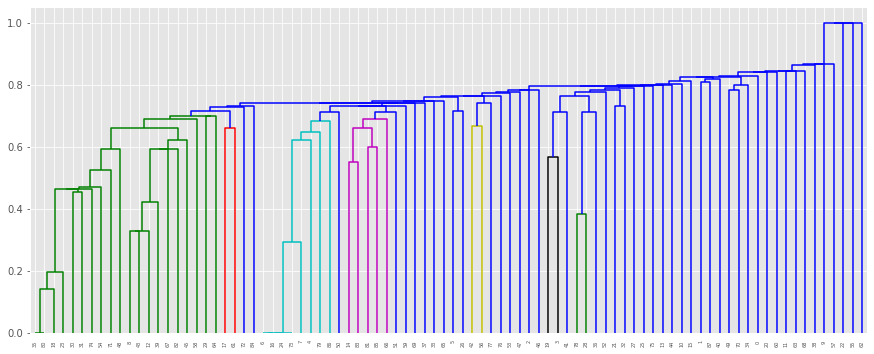

5


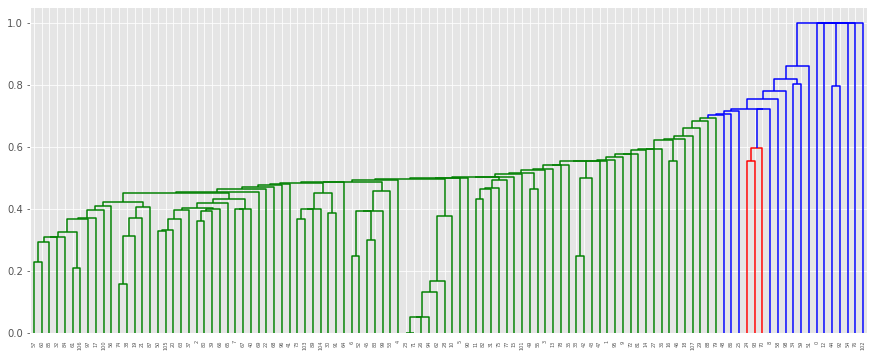

6


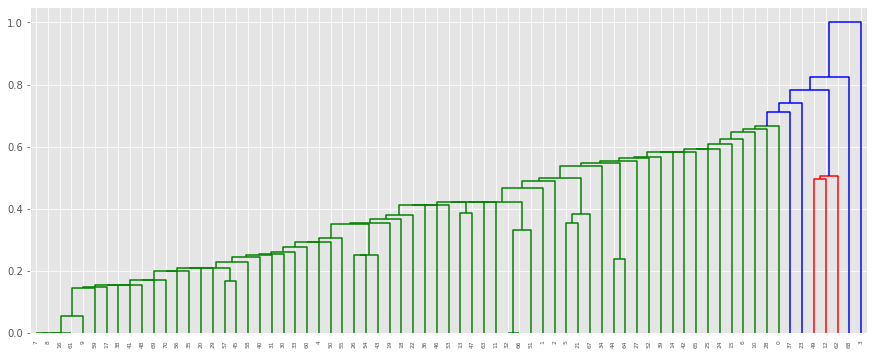

7


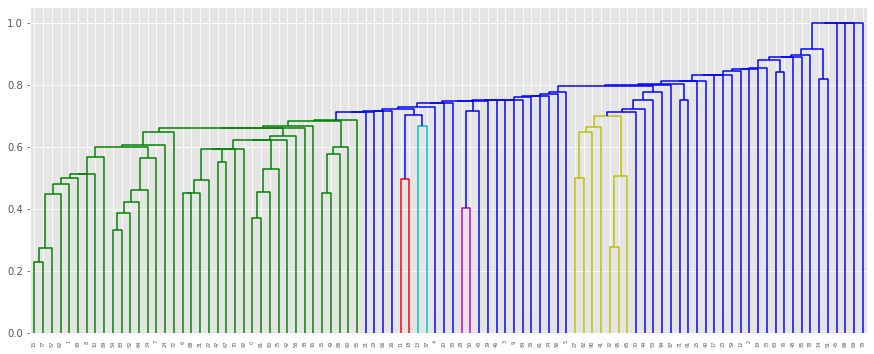

8


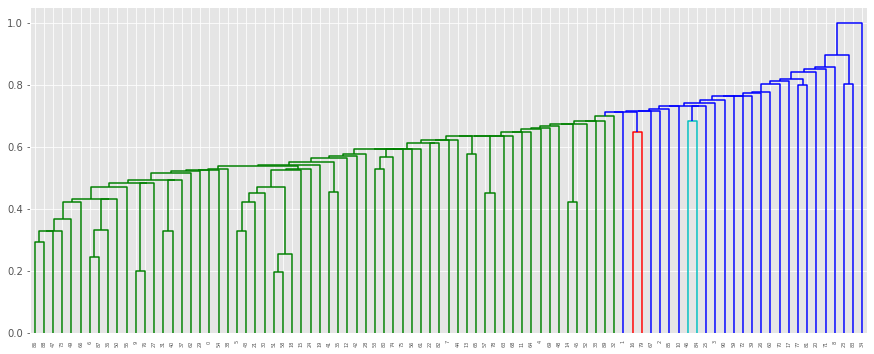

9


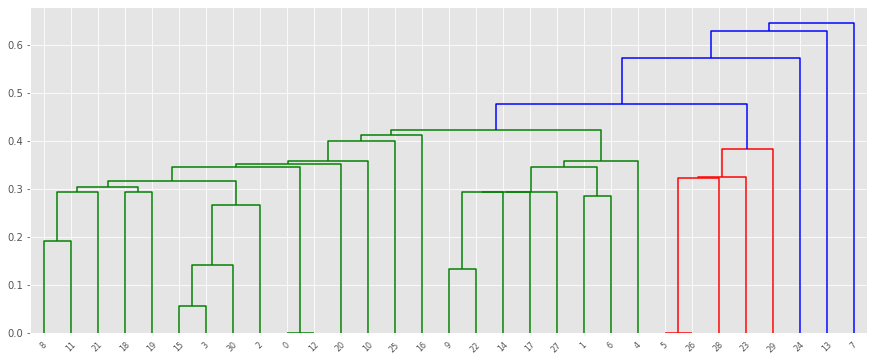

10


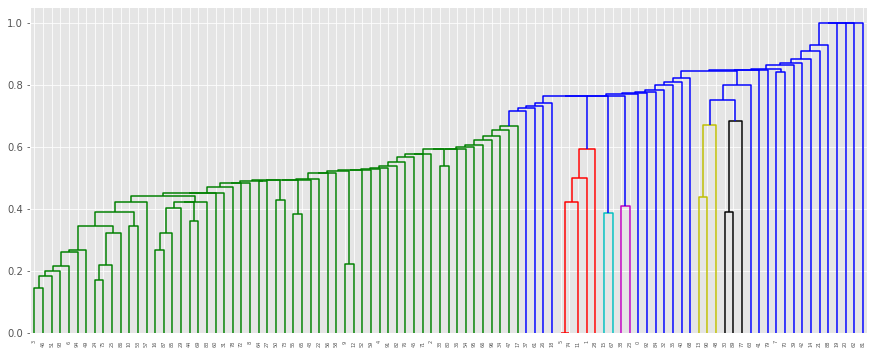

11


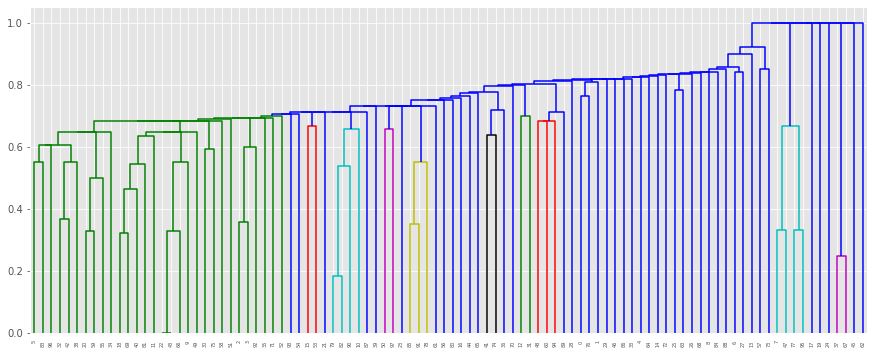

12


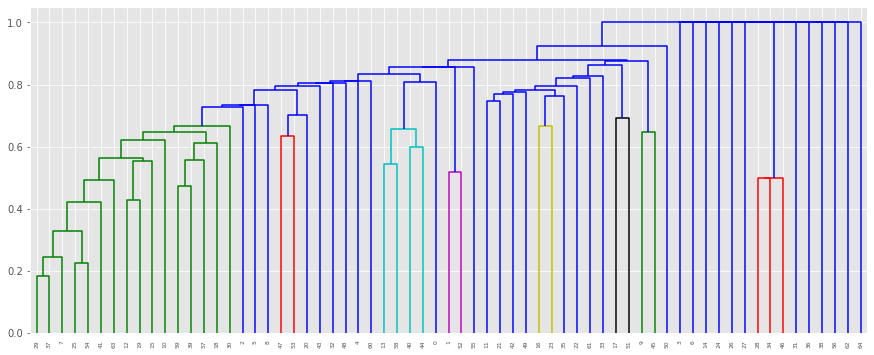

13


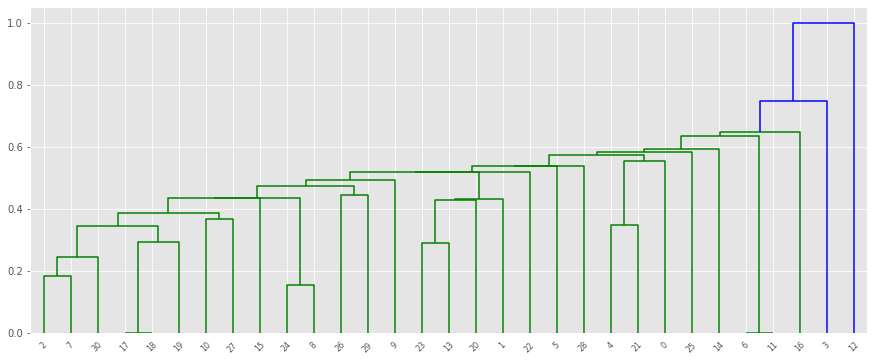

14


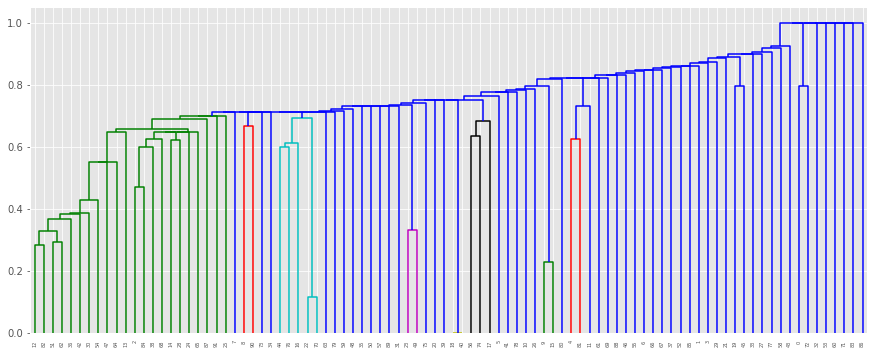

15


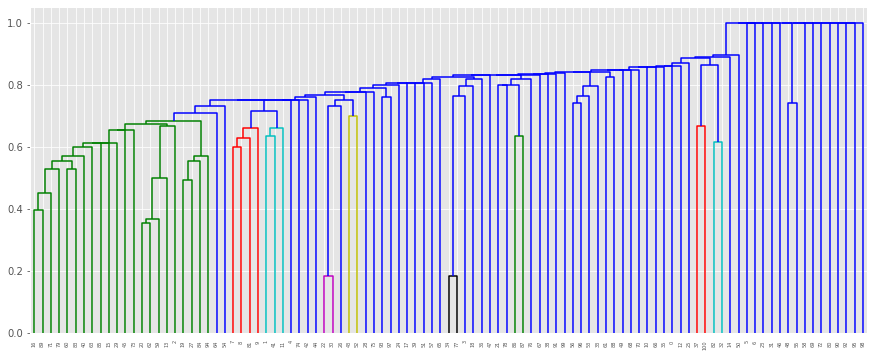

16


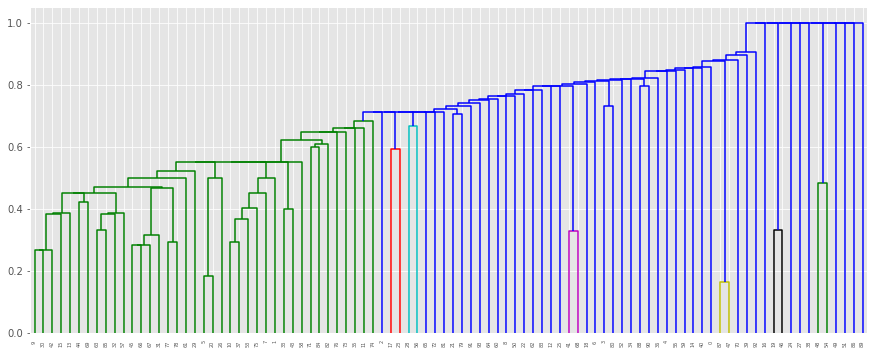

17


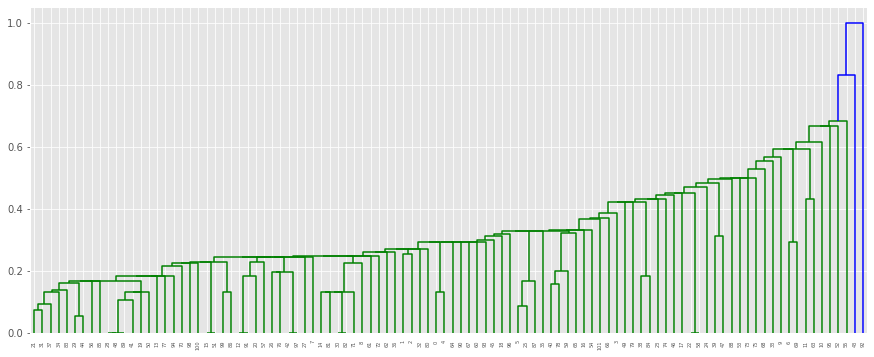

18


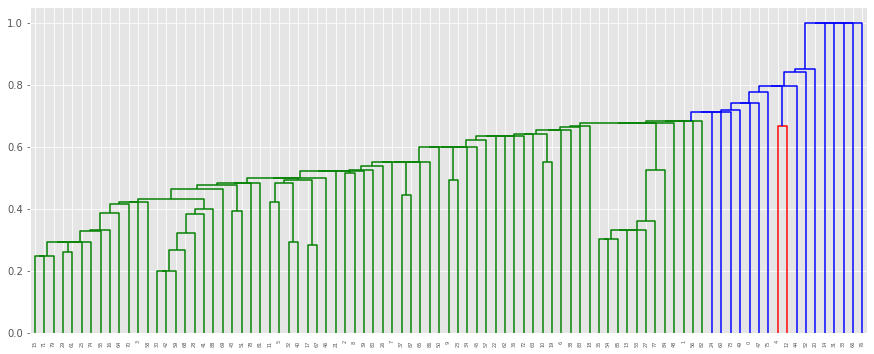

19


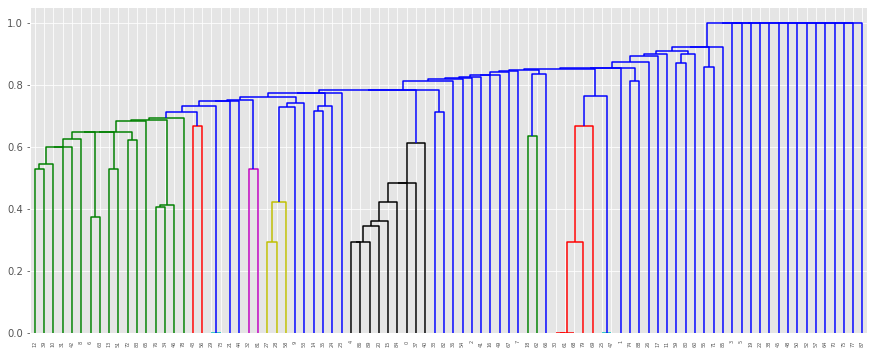

20


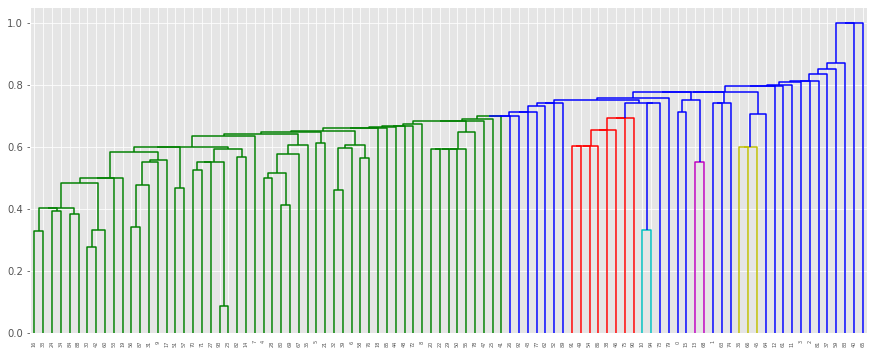

21


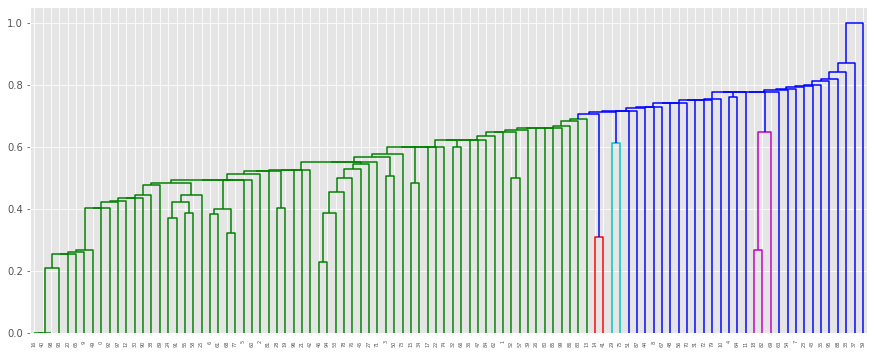

22


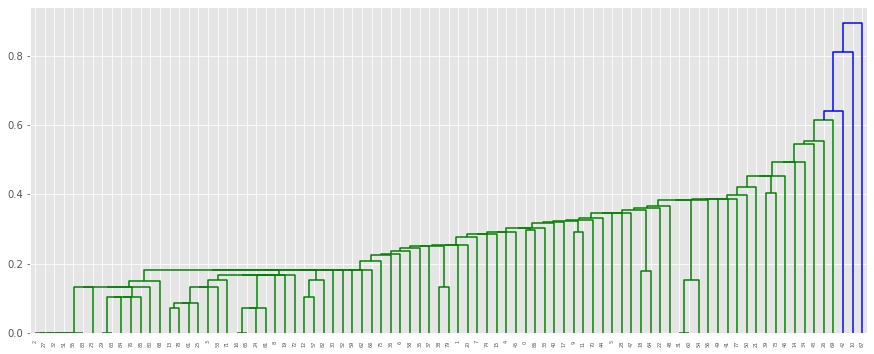

23


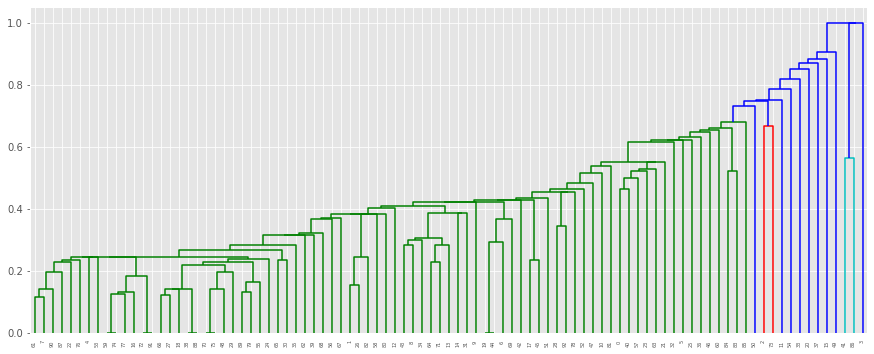

24


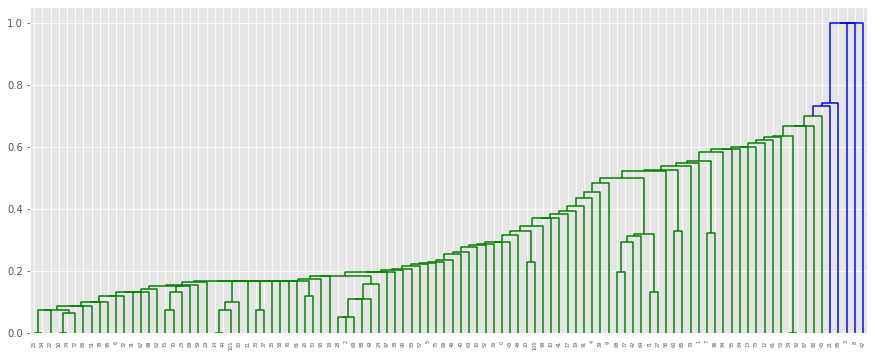

25


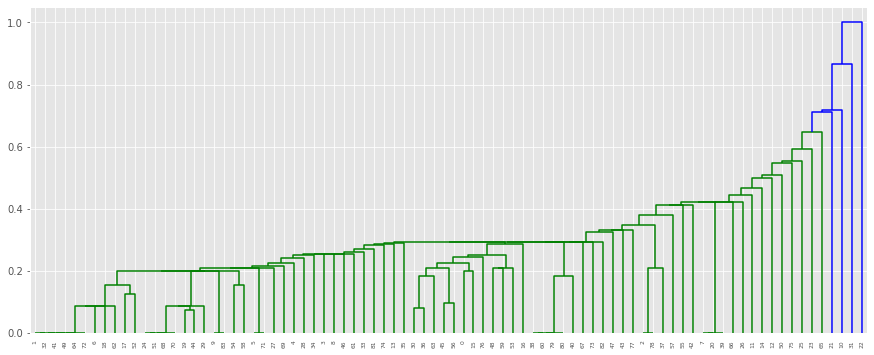

26


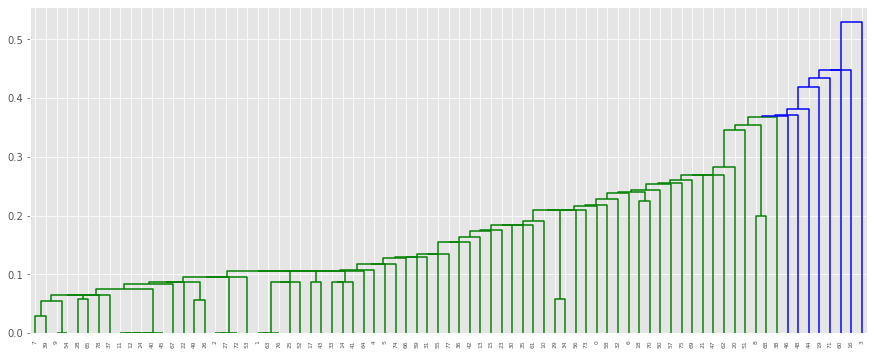

27


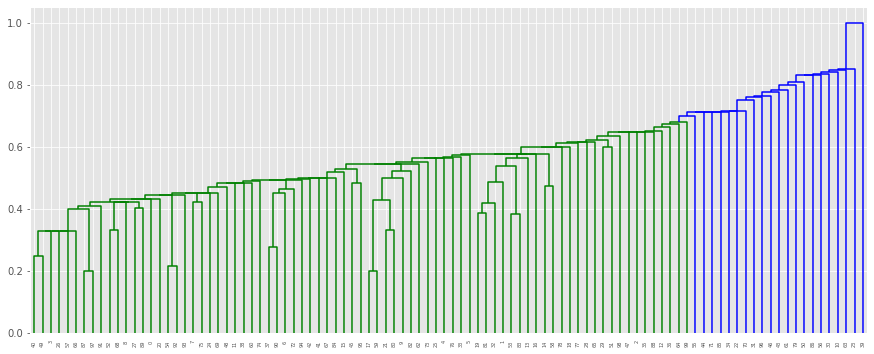

28


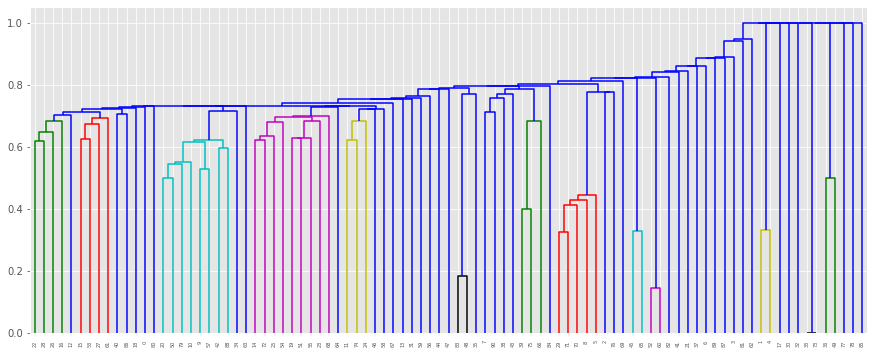

29


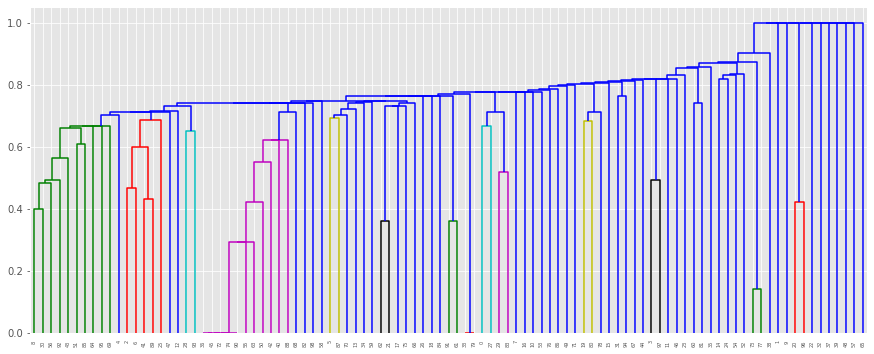

30


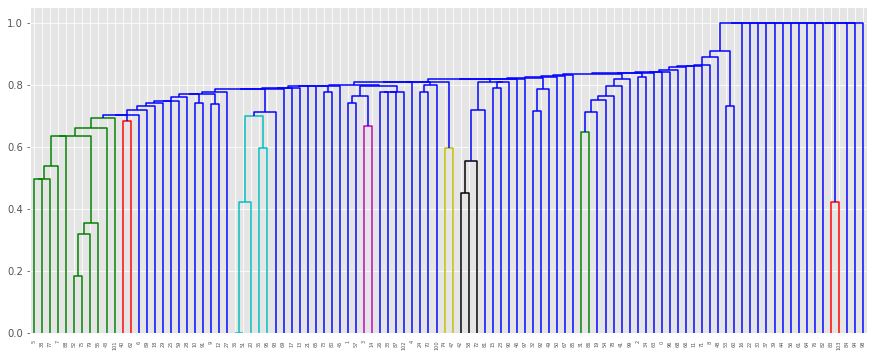

31


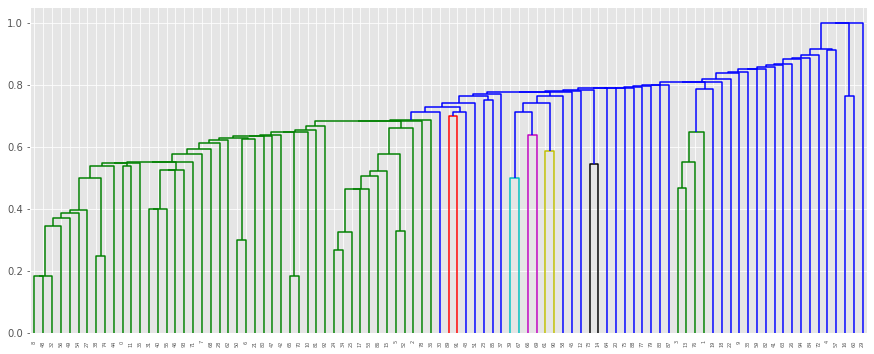

32


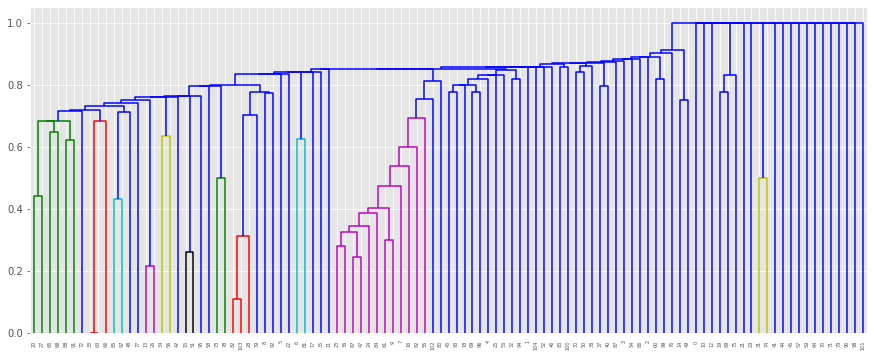

33


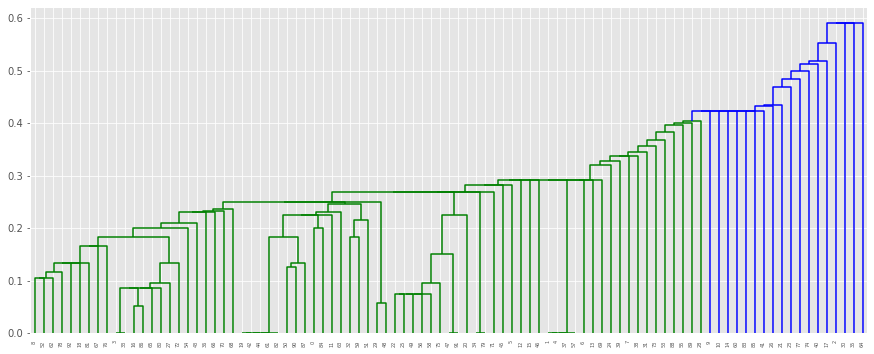

34


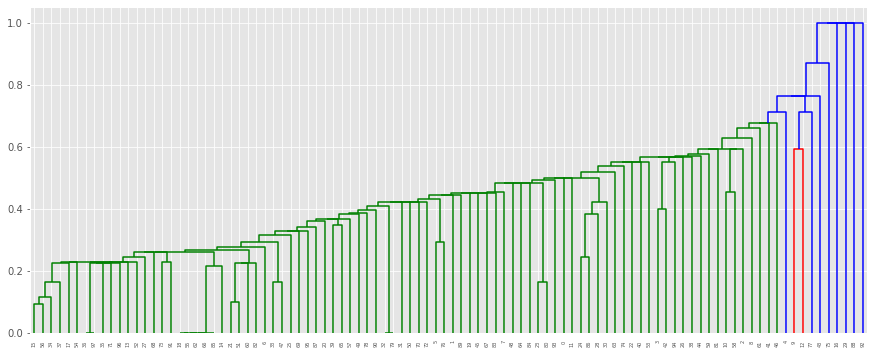

35


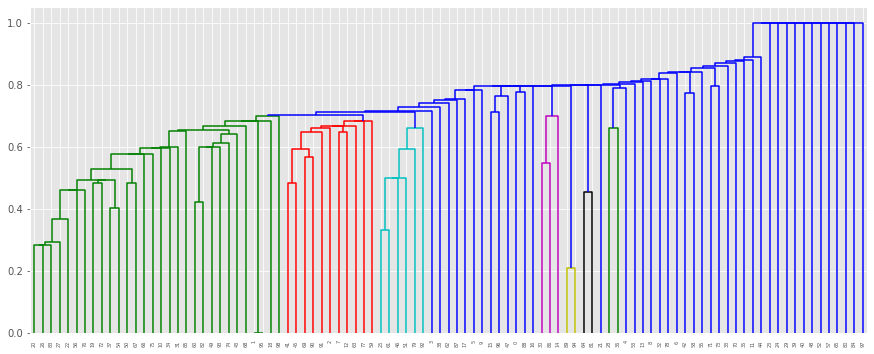

36


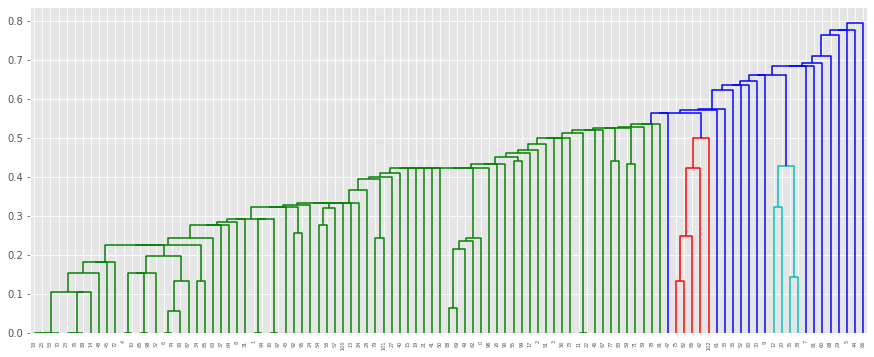

37


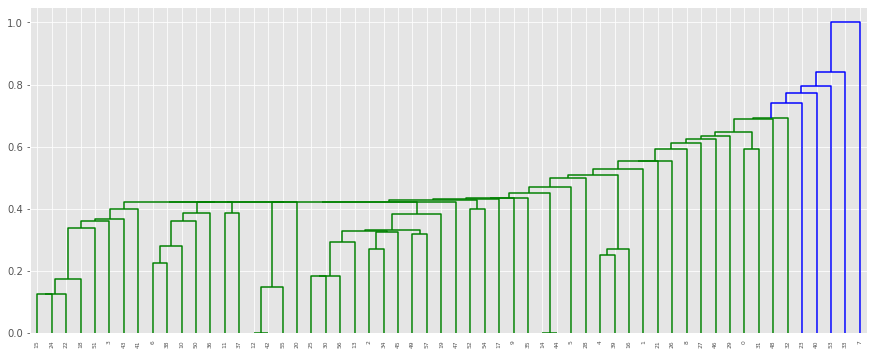

38


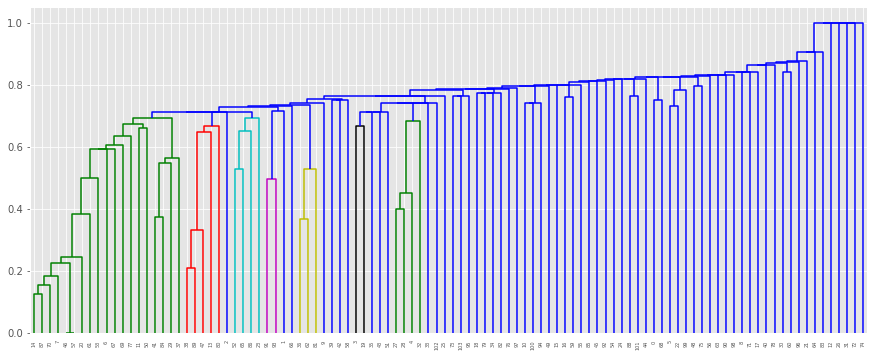

39


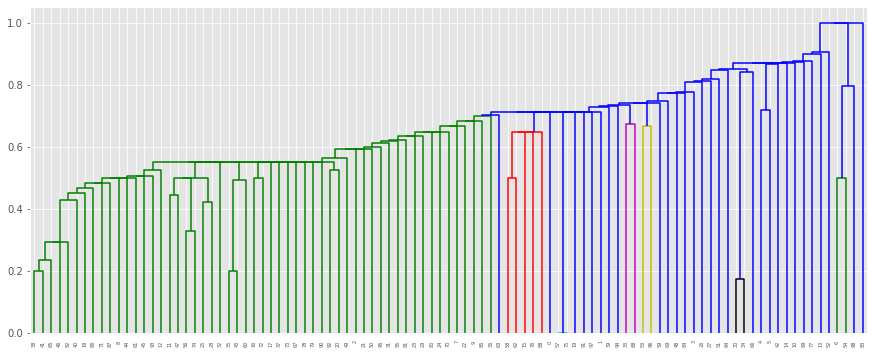

40


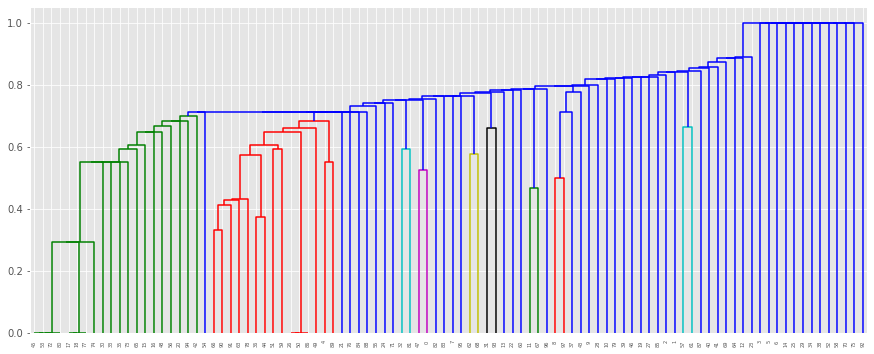

41


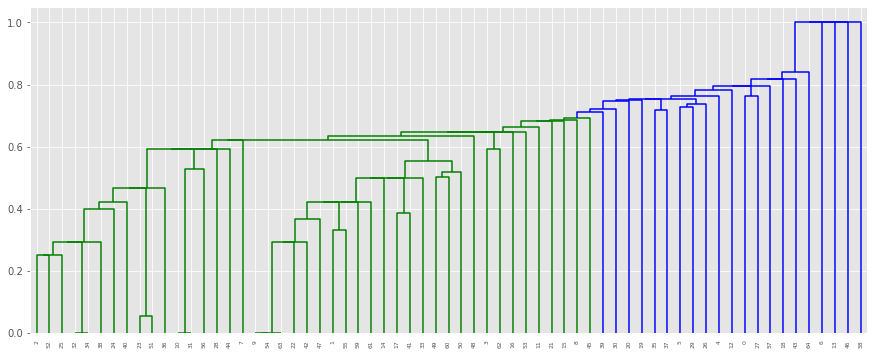

42


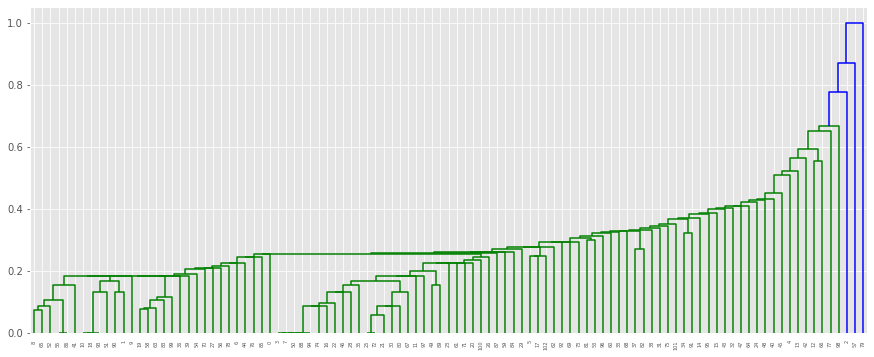

43


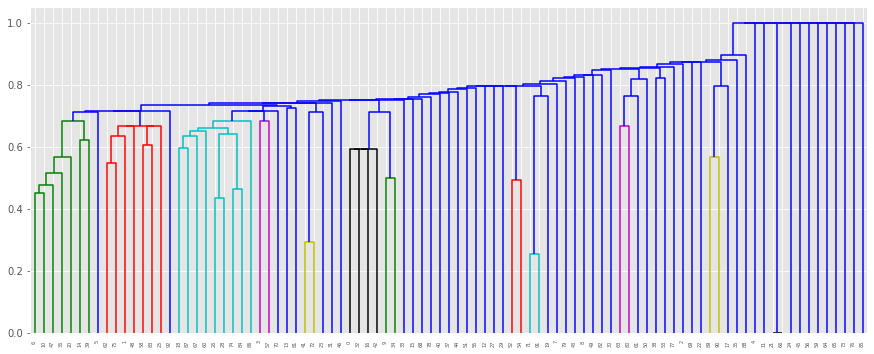

44


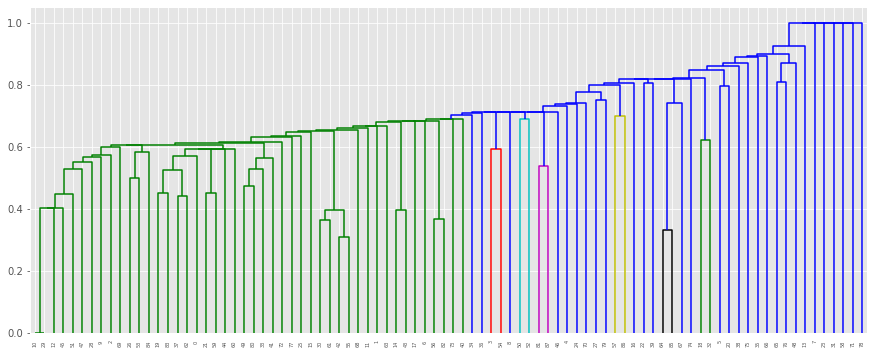

45


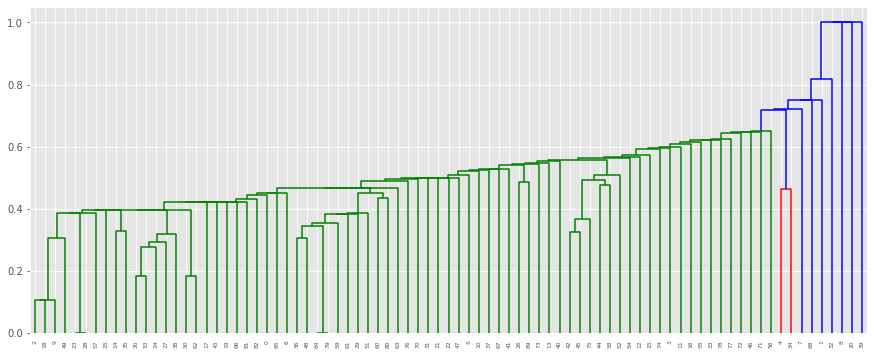

46


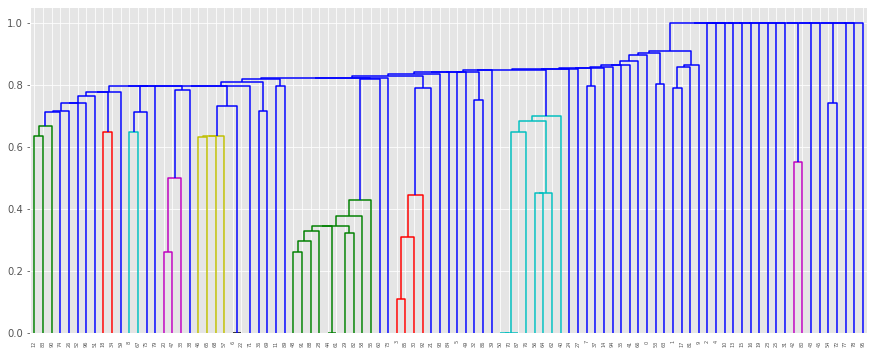

47


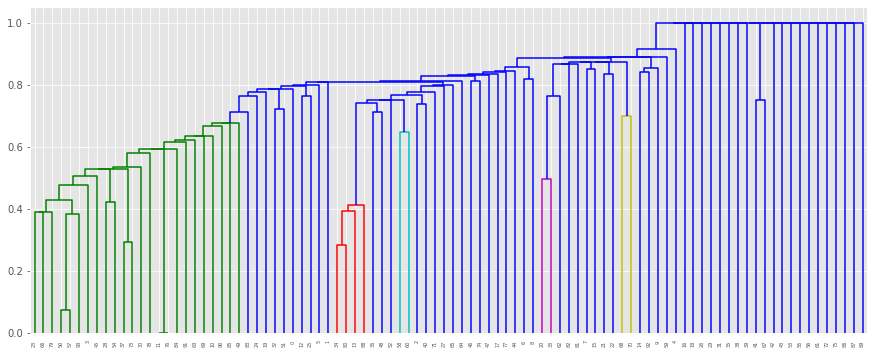

48


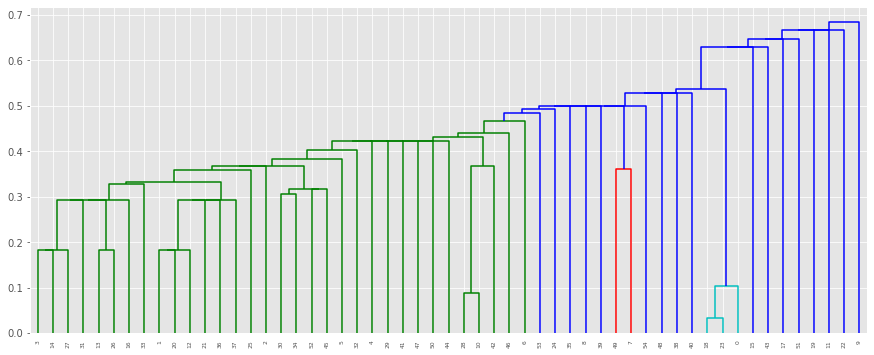

49


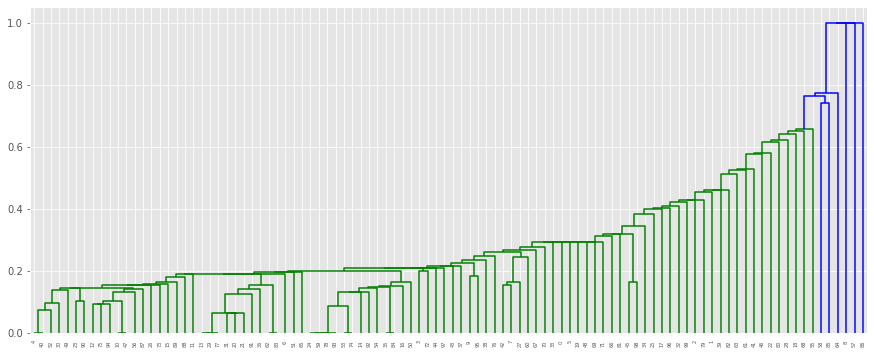

50


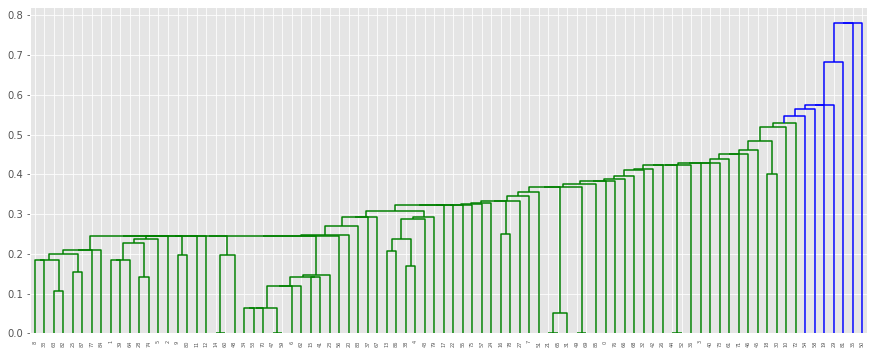

51


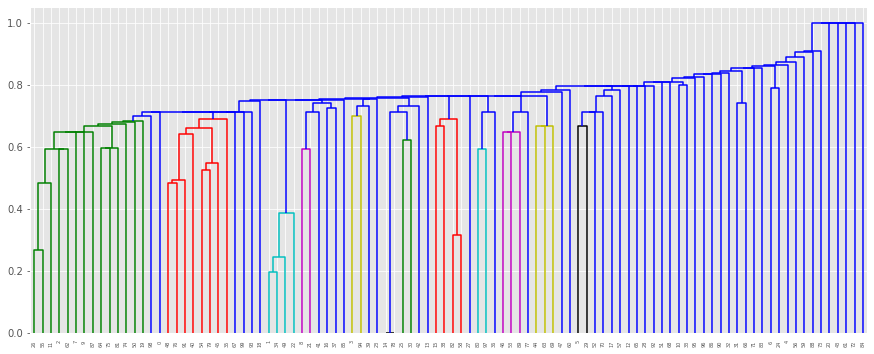

52


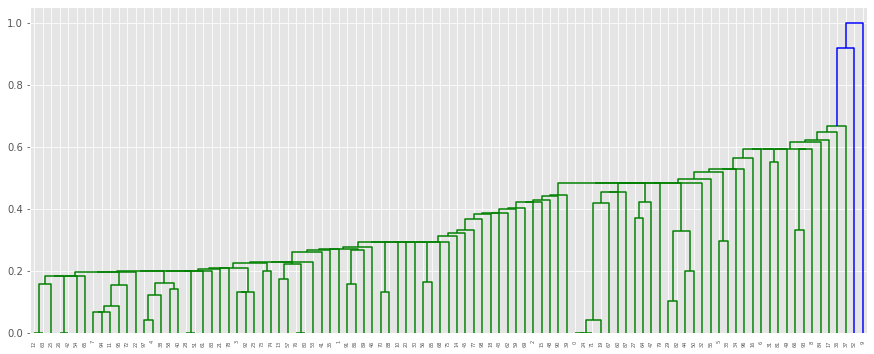

53


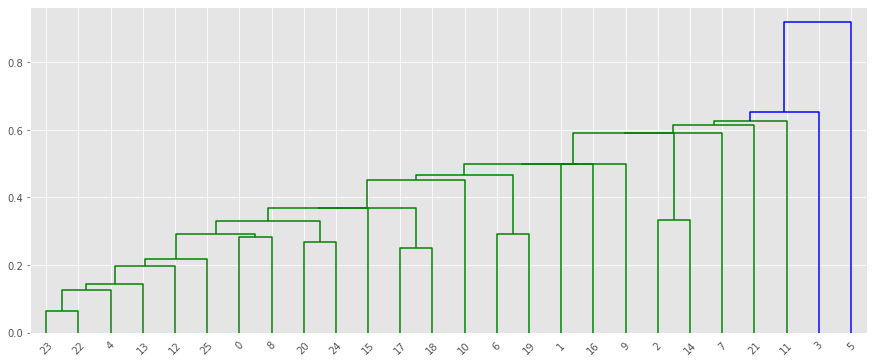

54


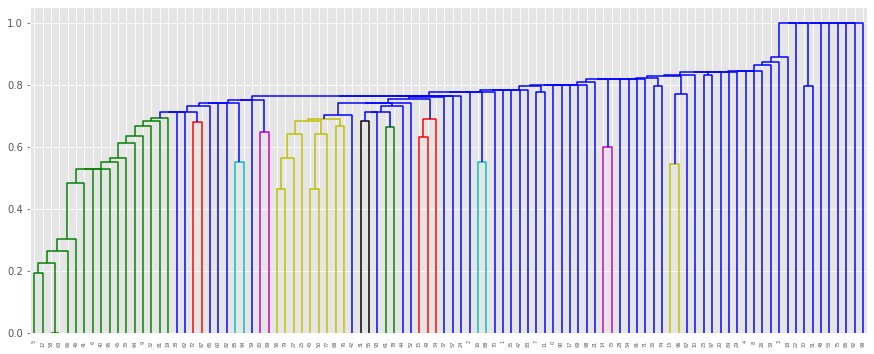

55


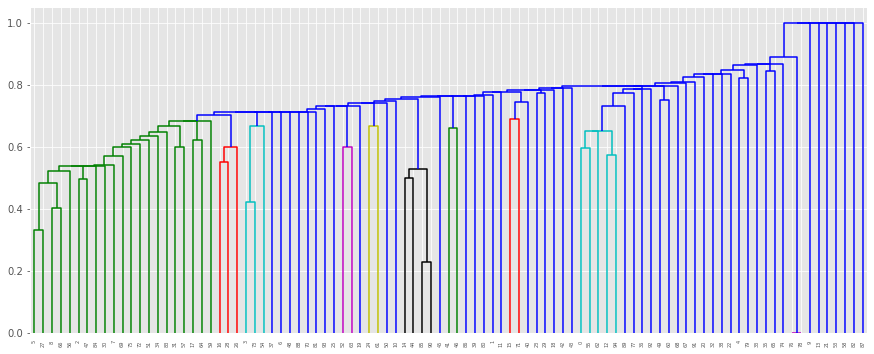

56


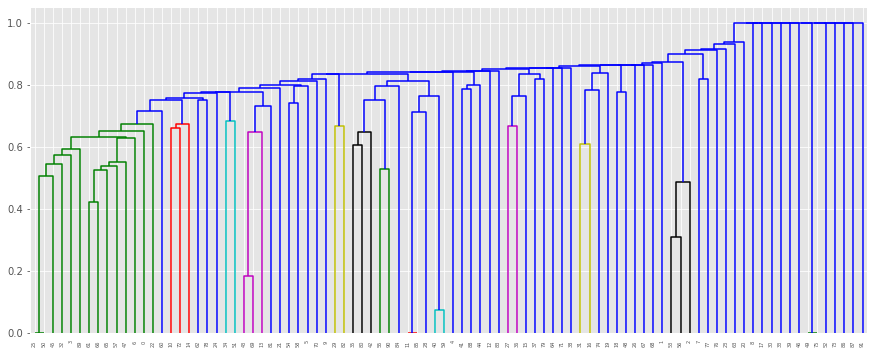

57


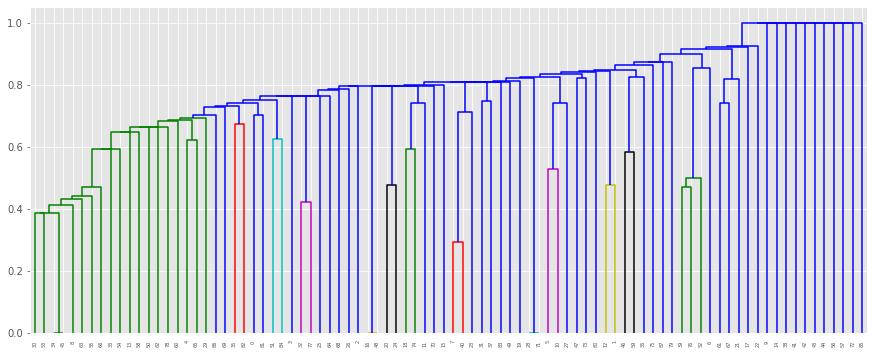

58


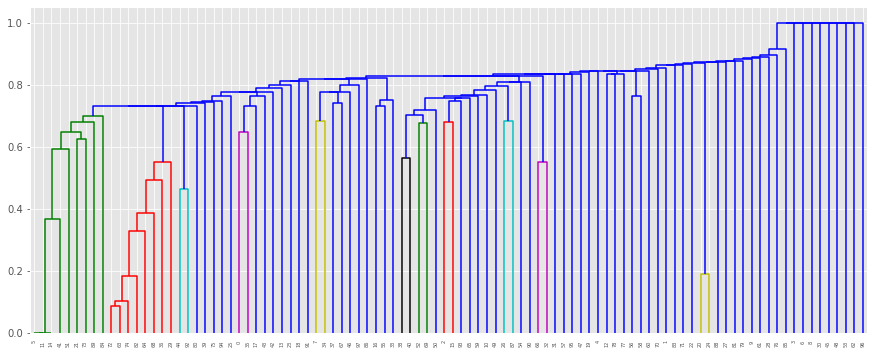

59


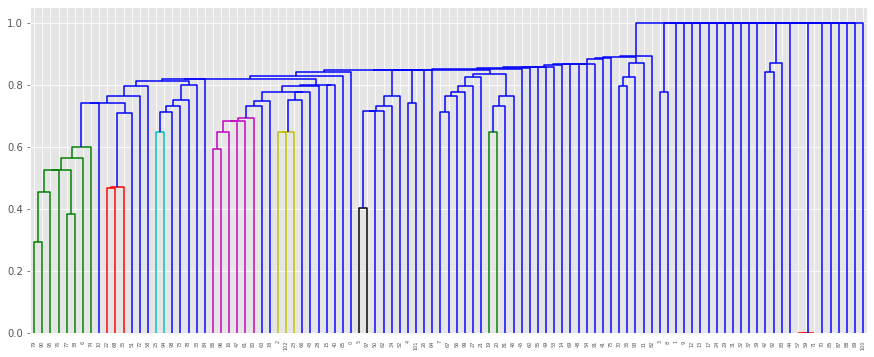

60


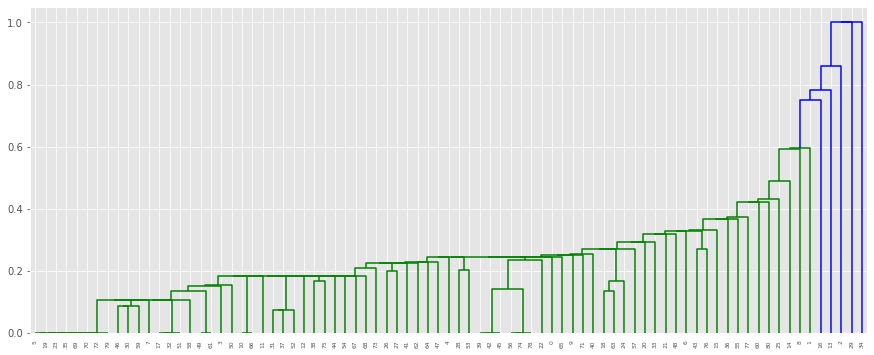

61


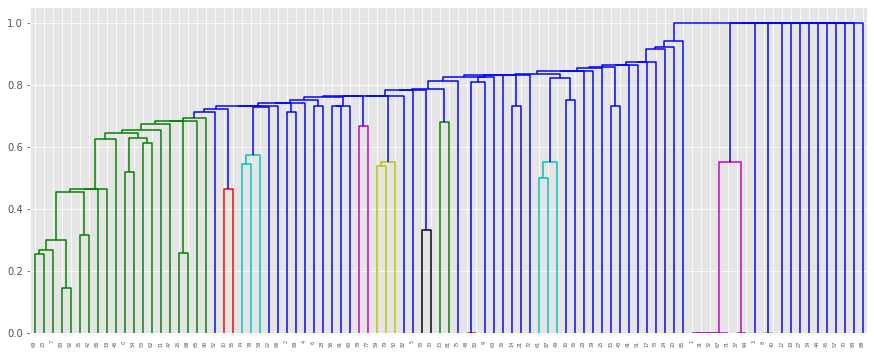

62


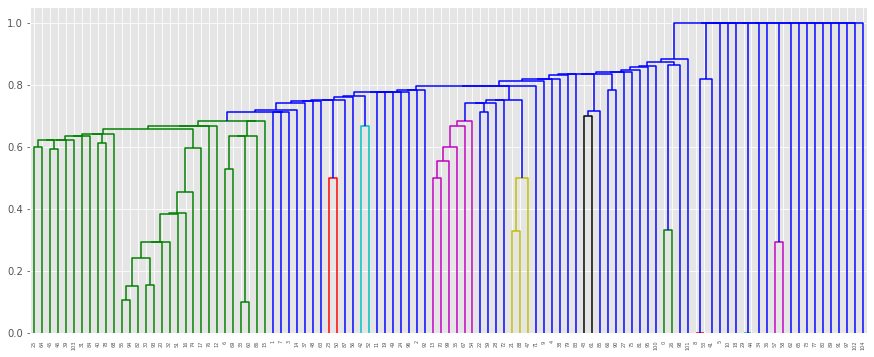

63


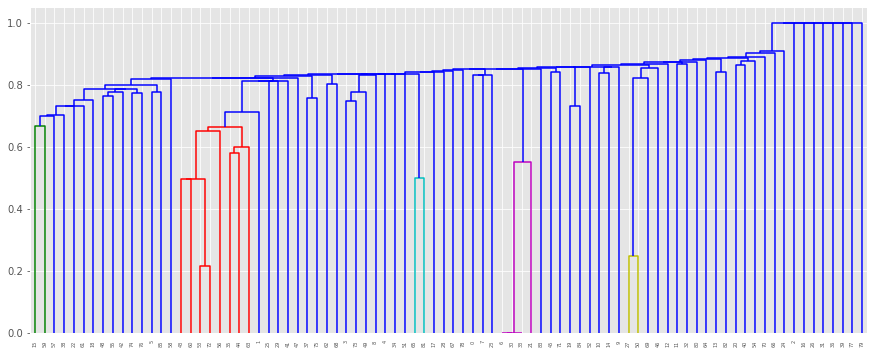

64


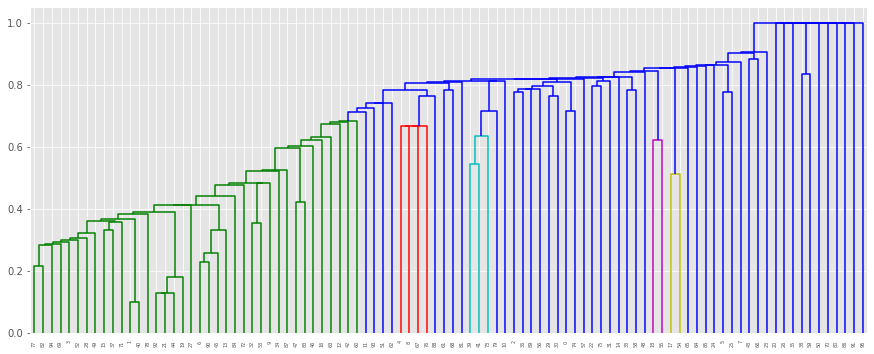

65


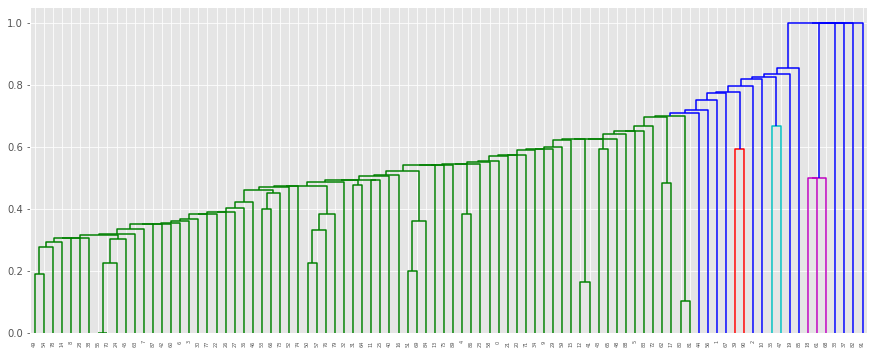

66


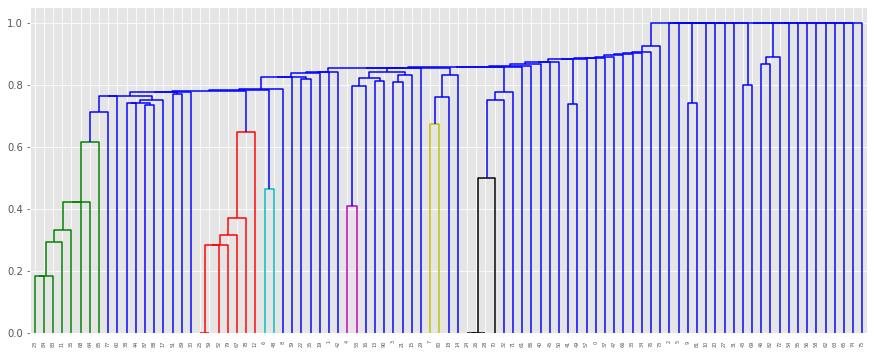

67


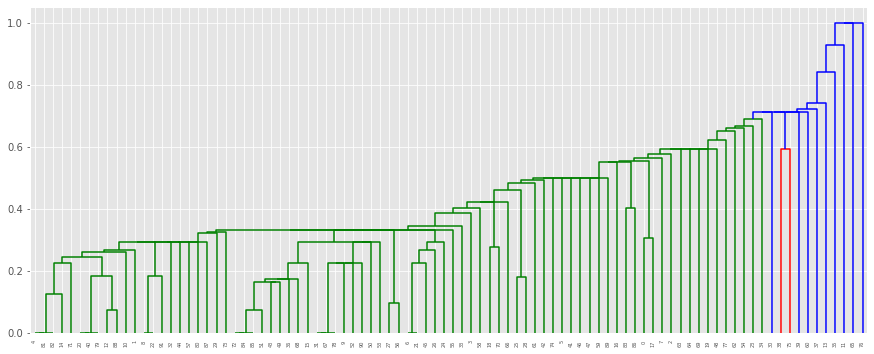

68


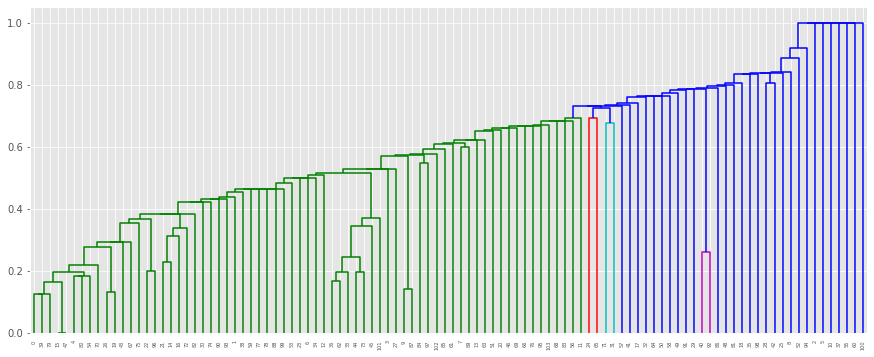

69


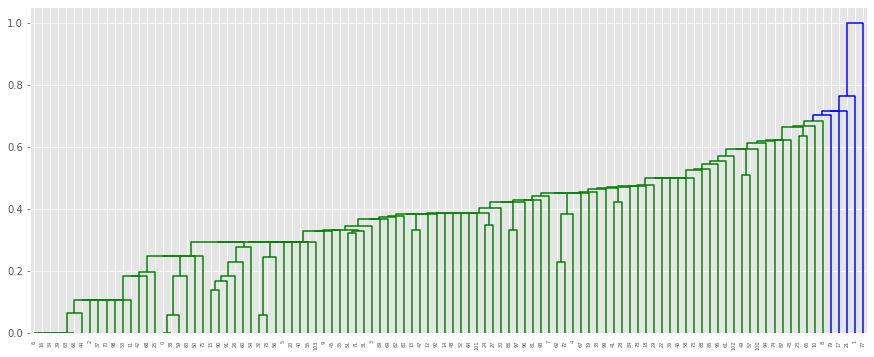

70


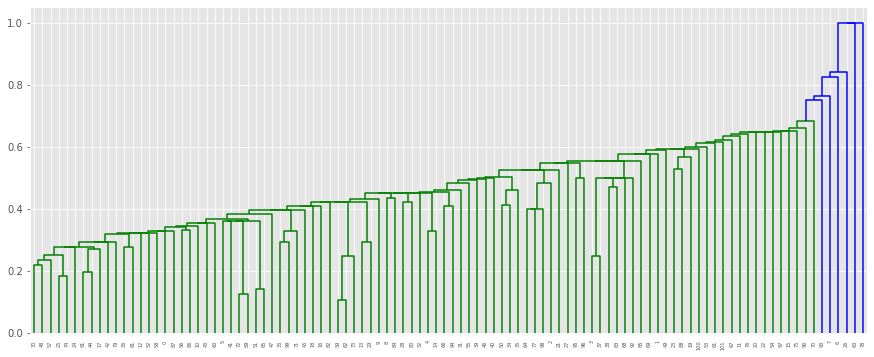

71


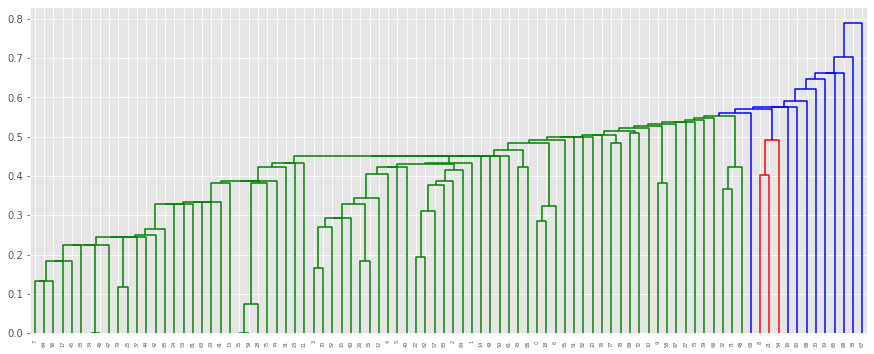

72


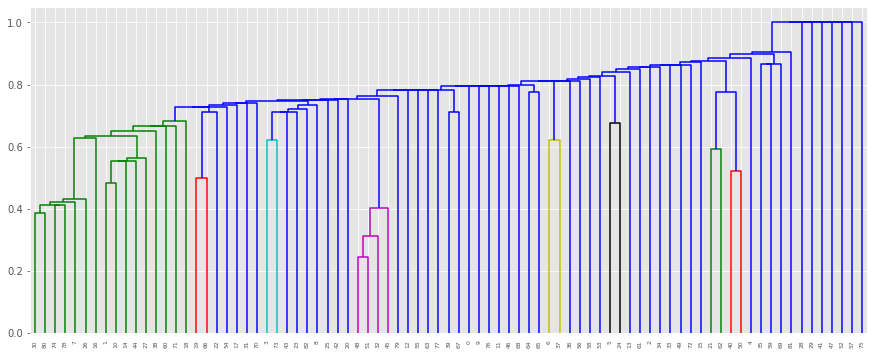

73


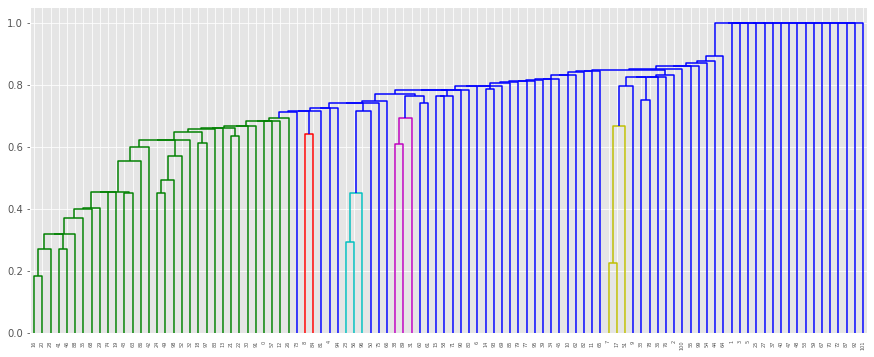

74


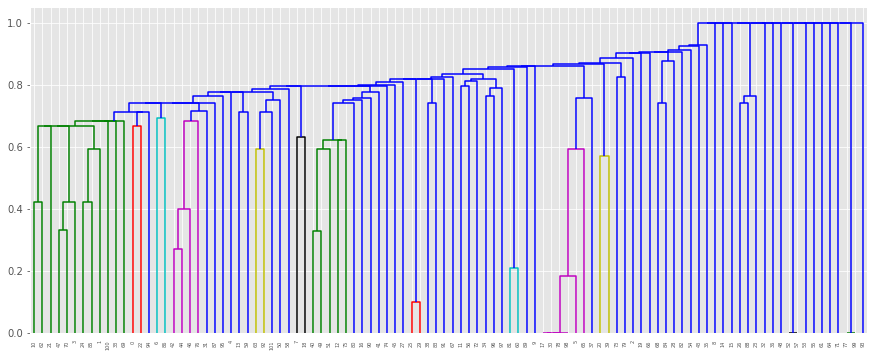

75


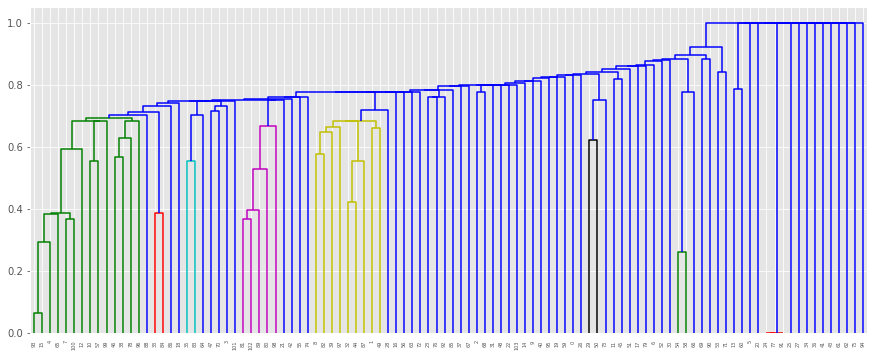

76


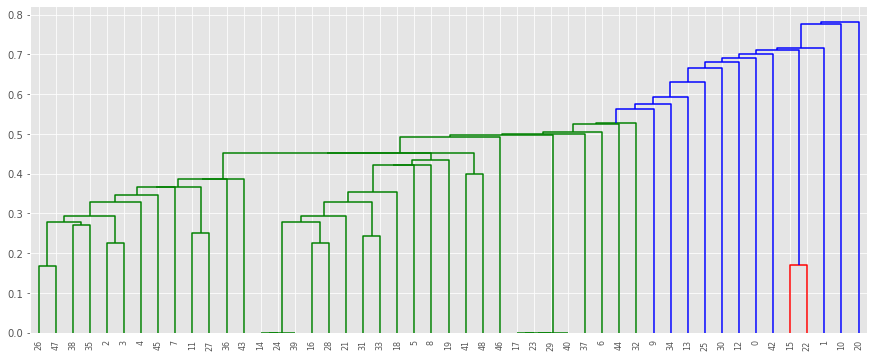

77


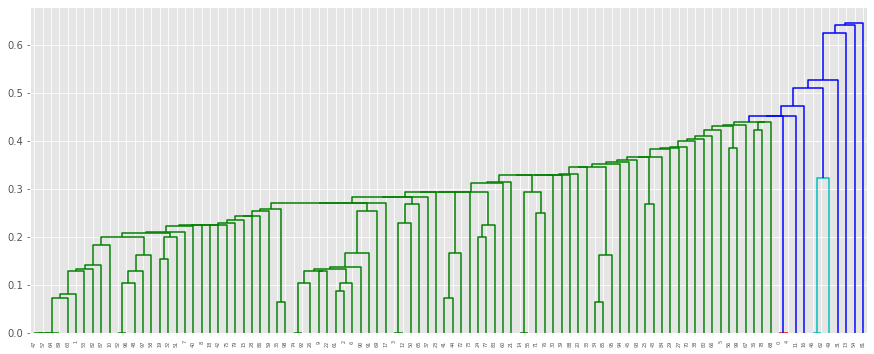

78


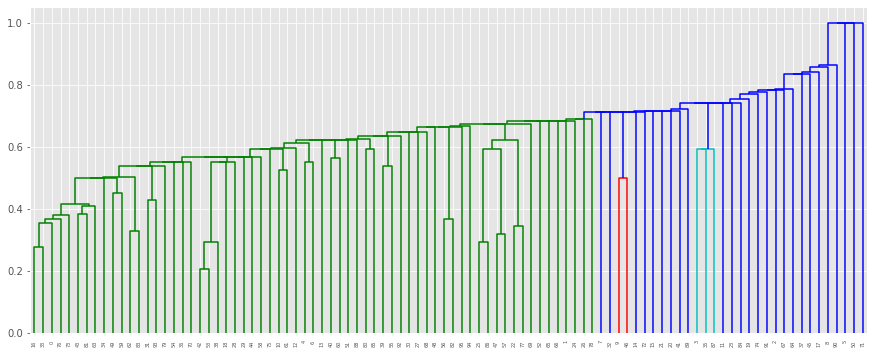

79


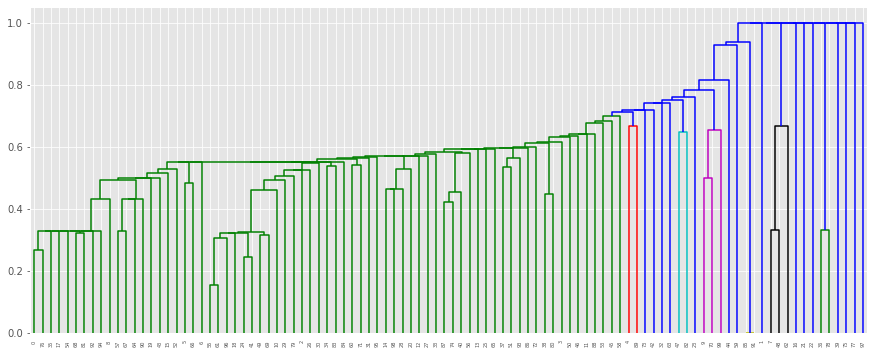

80


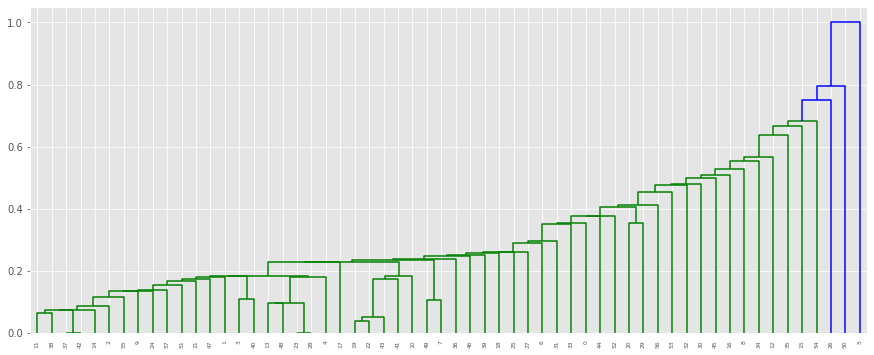

81


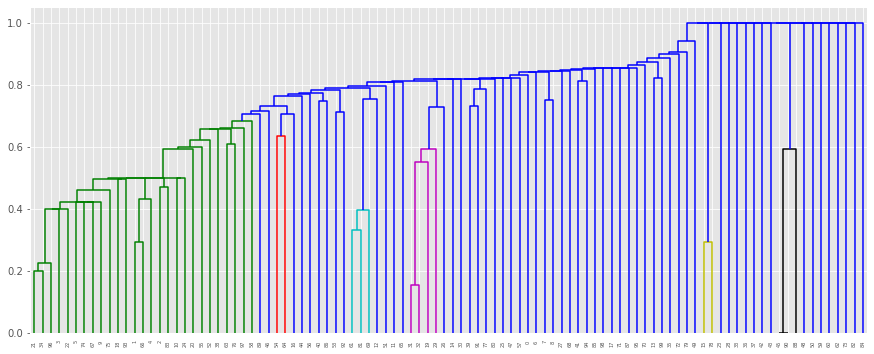

82


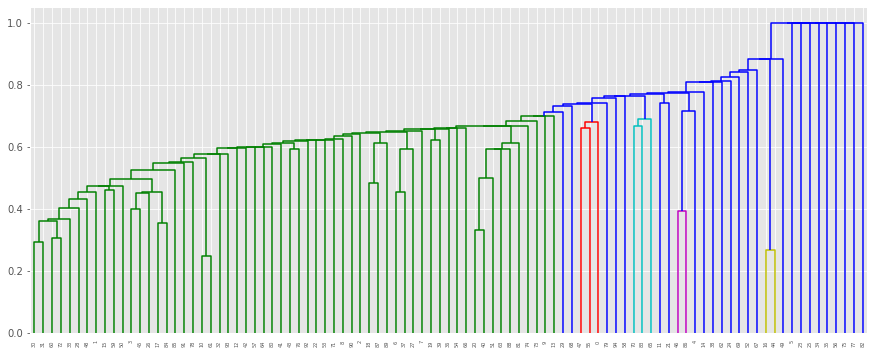

83


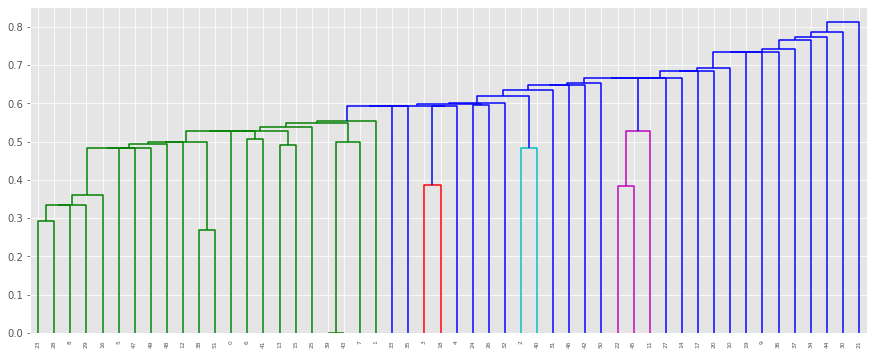

84


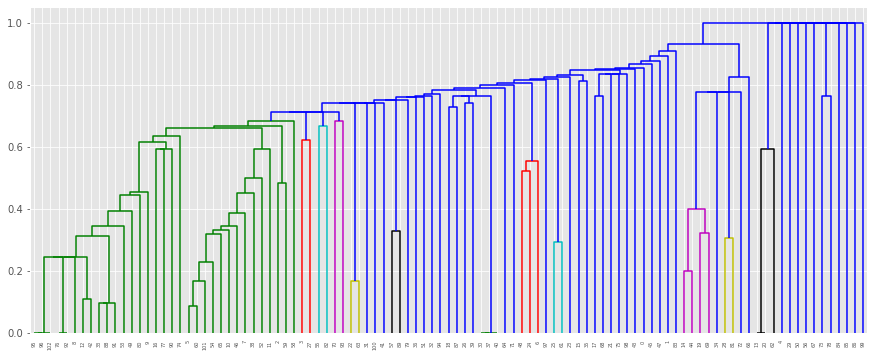

85


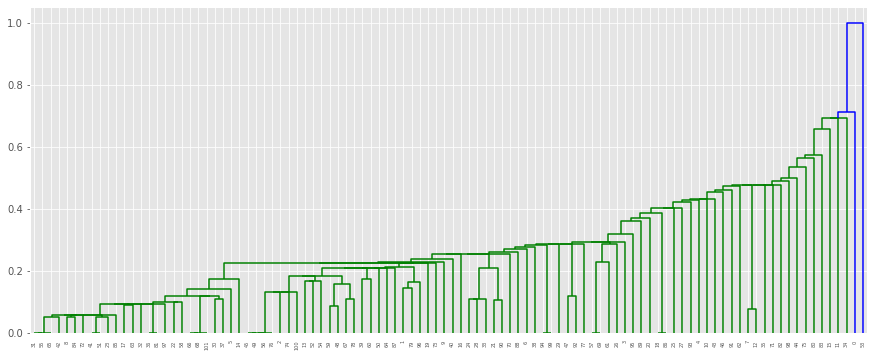

86


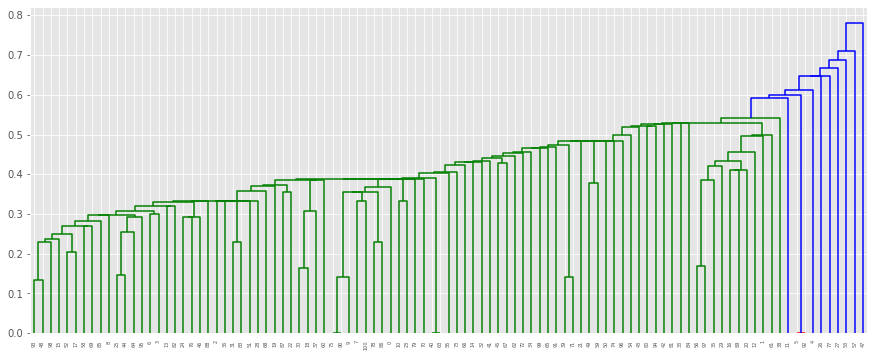

87


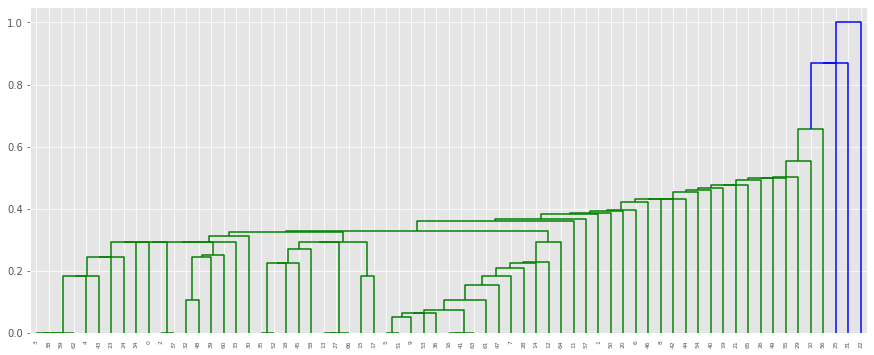

88


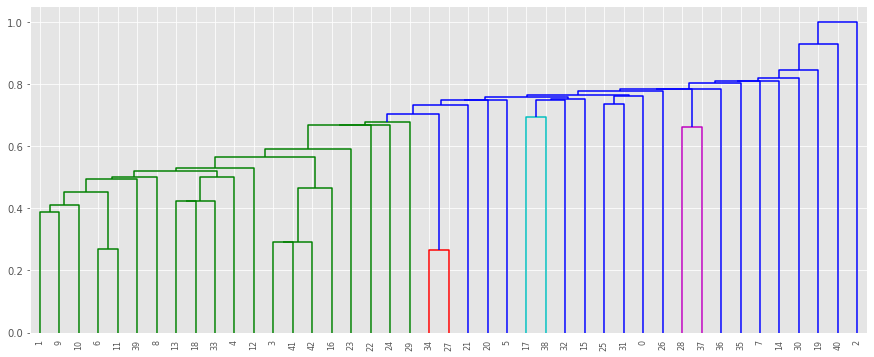

89


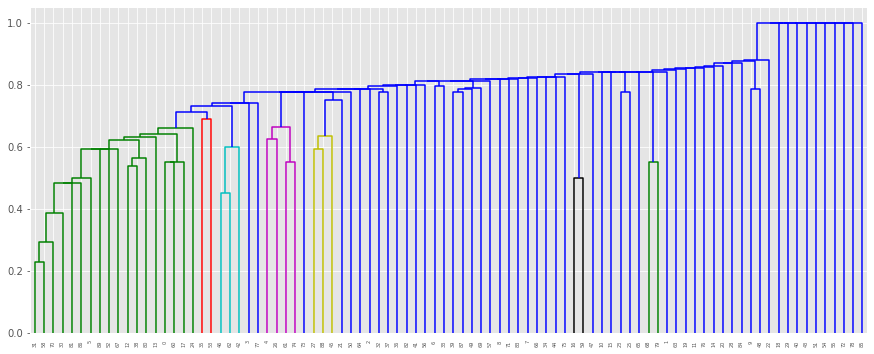

90


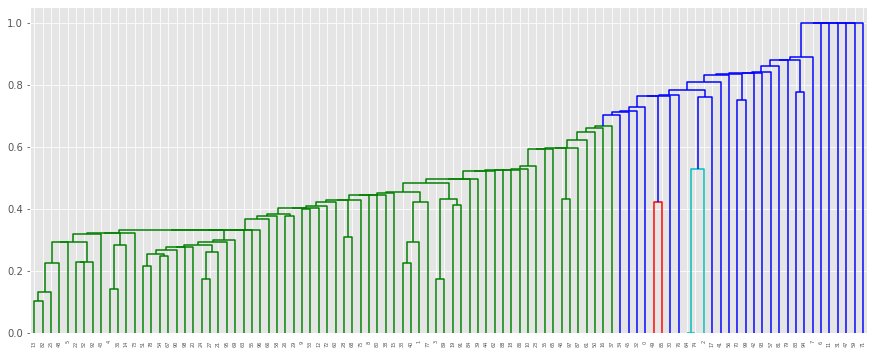

91


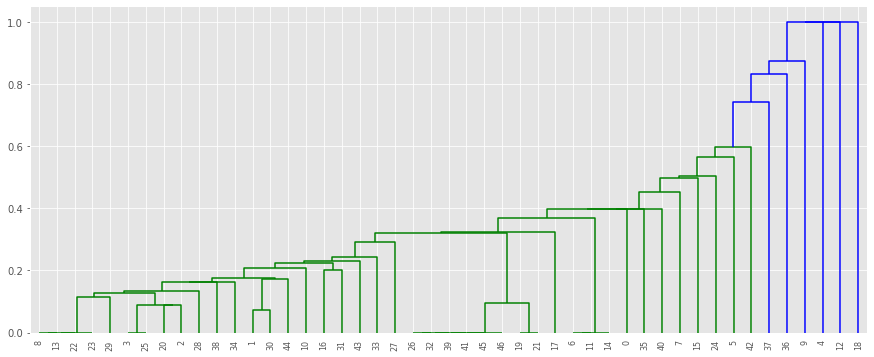

92


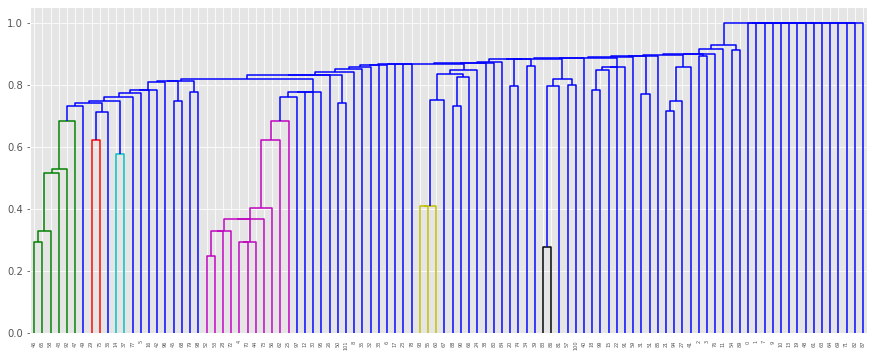

93


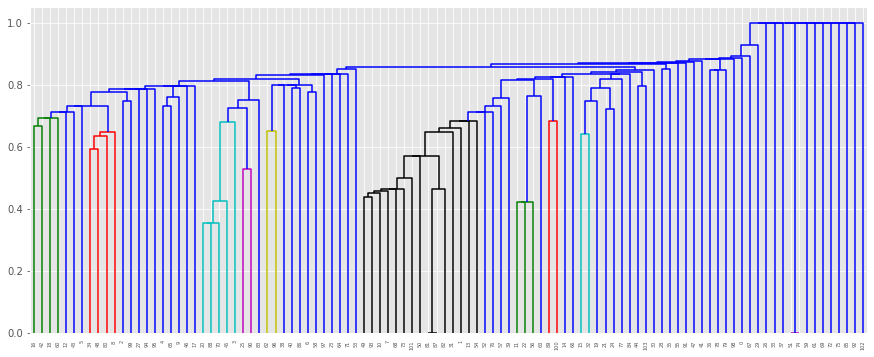

94


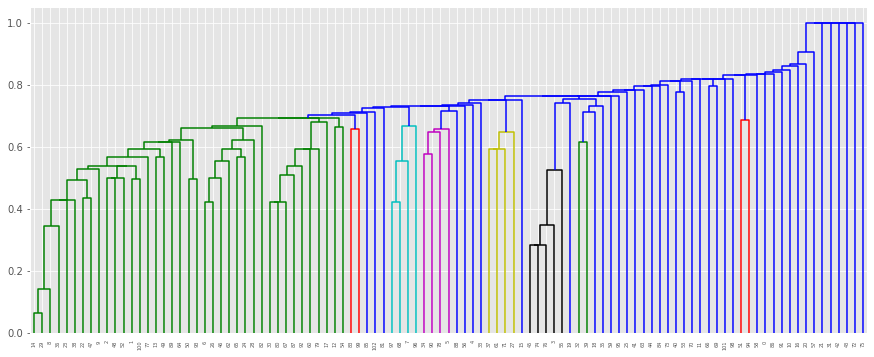

95


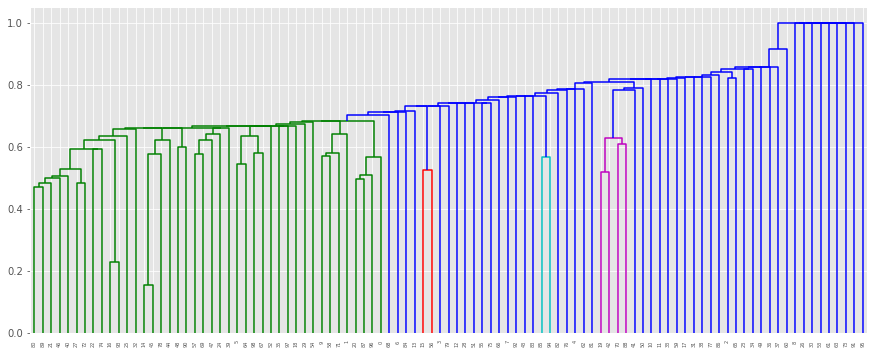

96


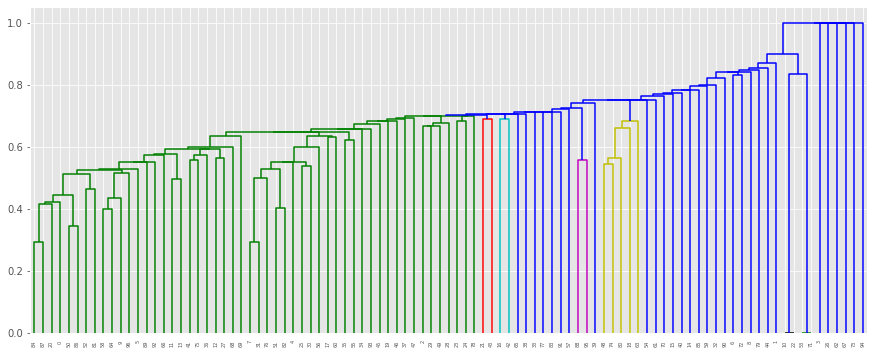

97


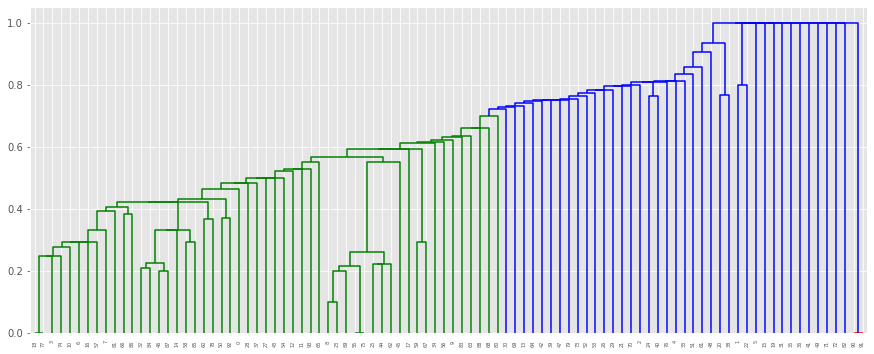

98


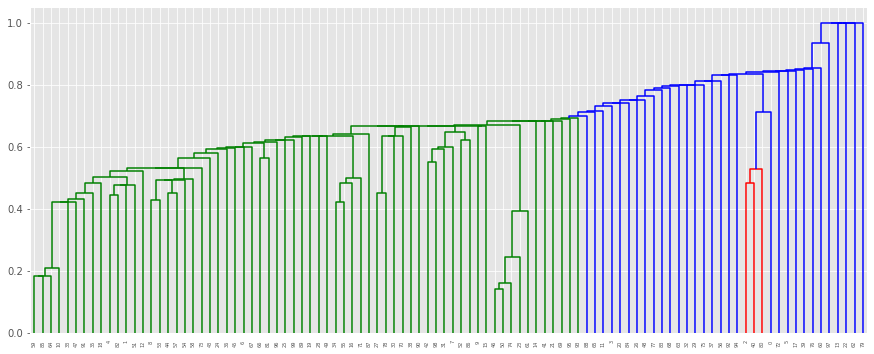

99


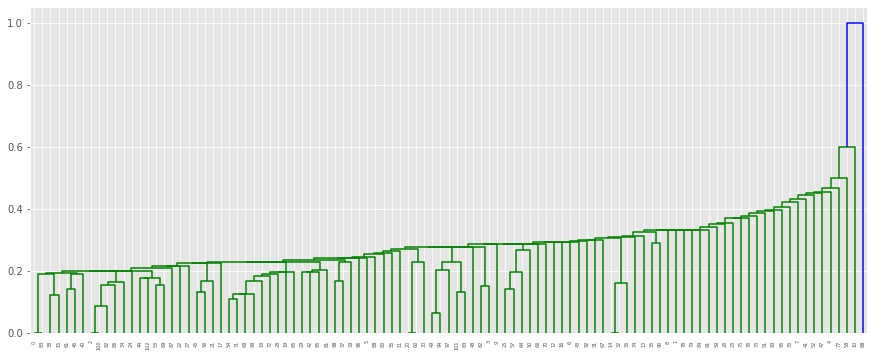

100


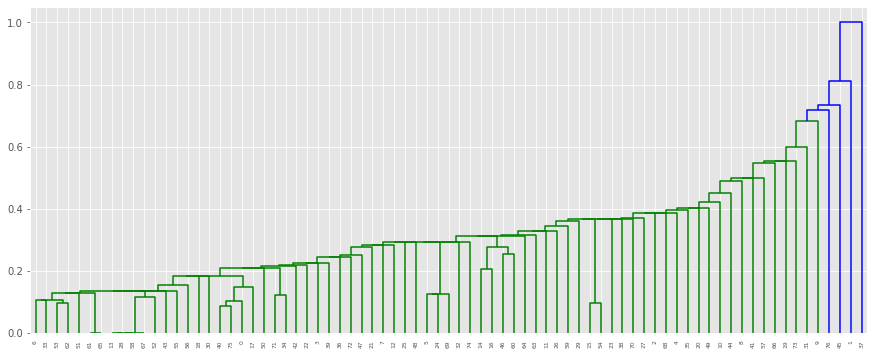

101


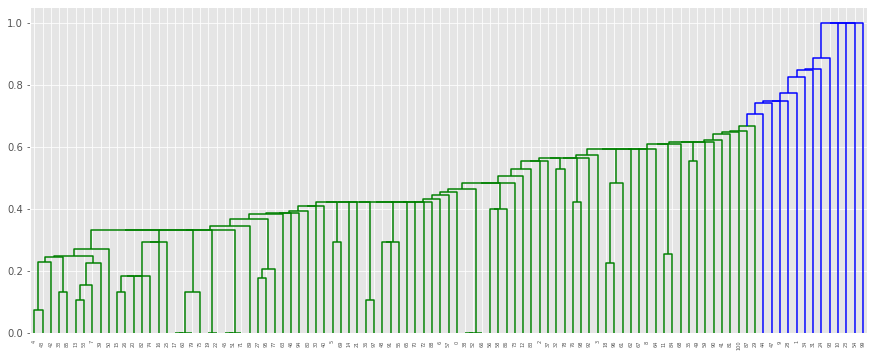

102


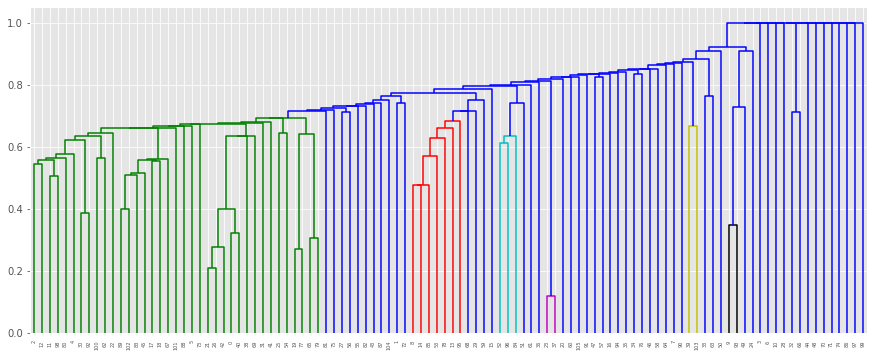

103


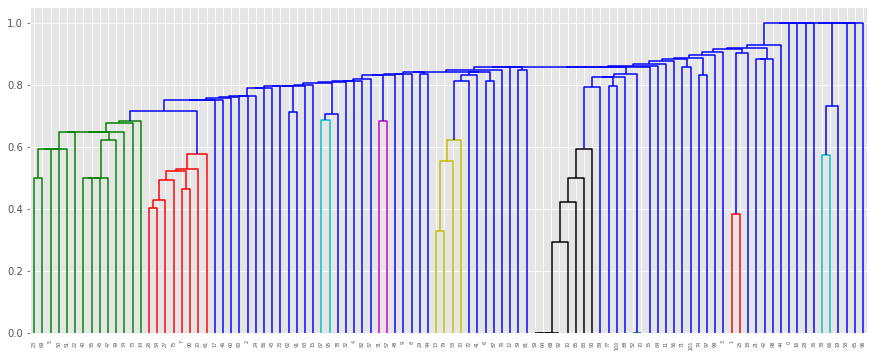

104


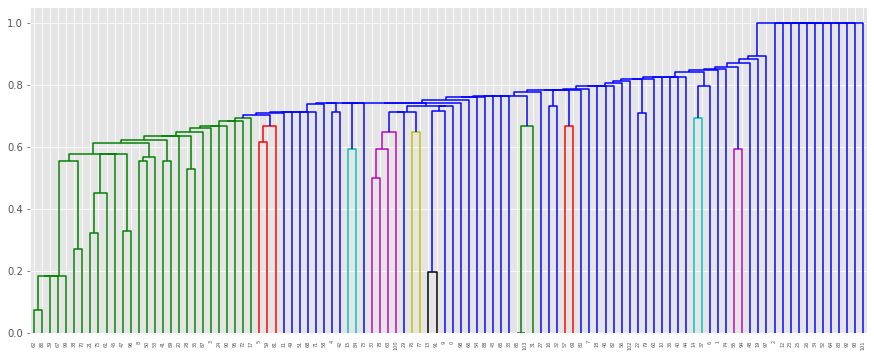

105


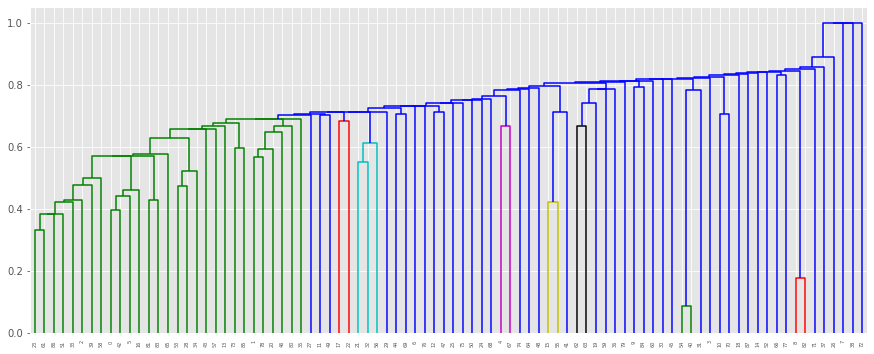

106


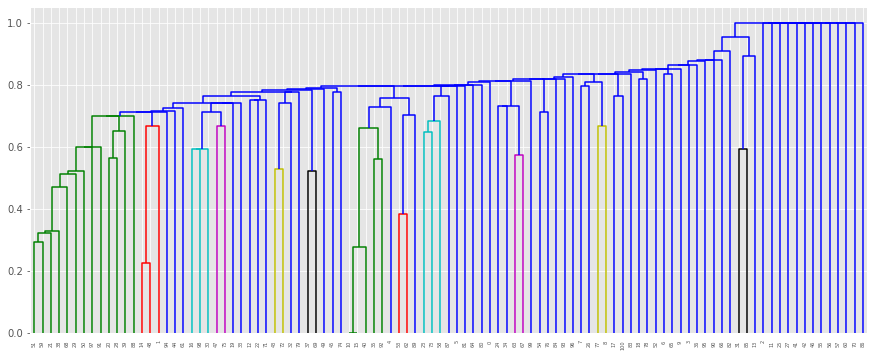

107


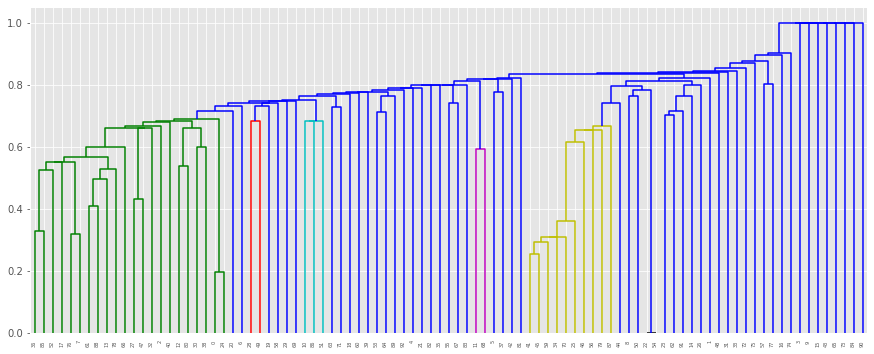

108


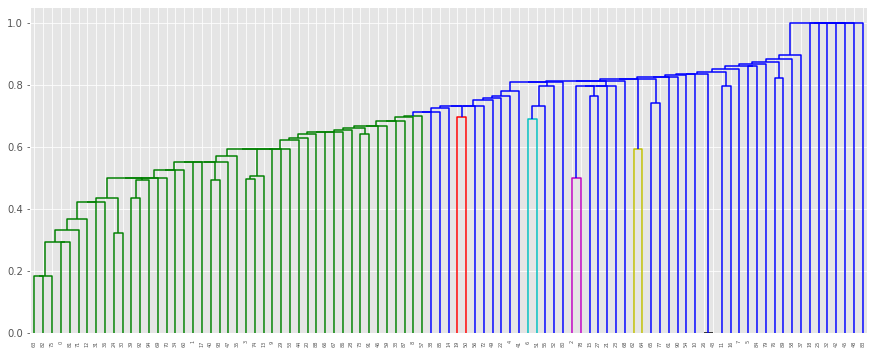

109


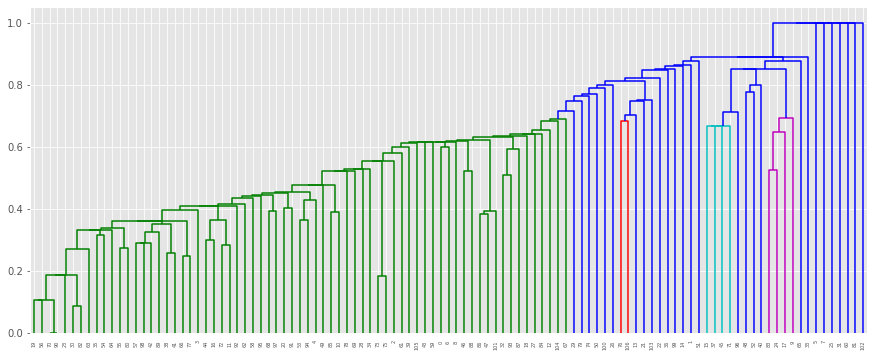

110


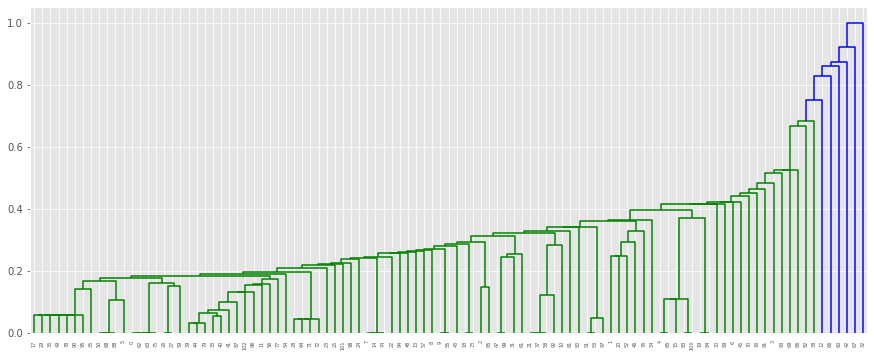

111


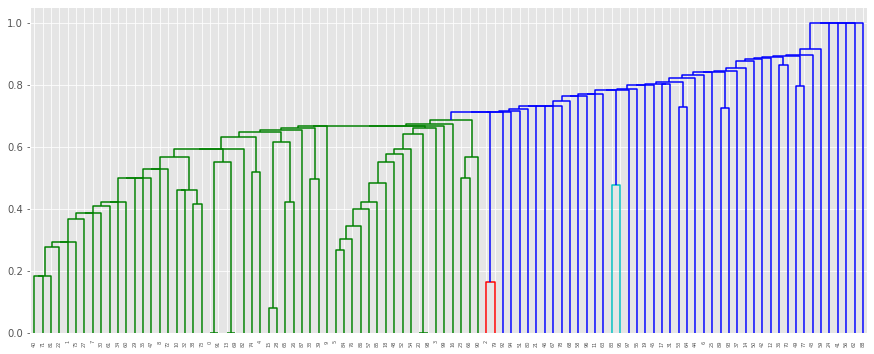

112


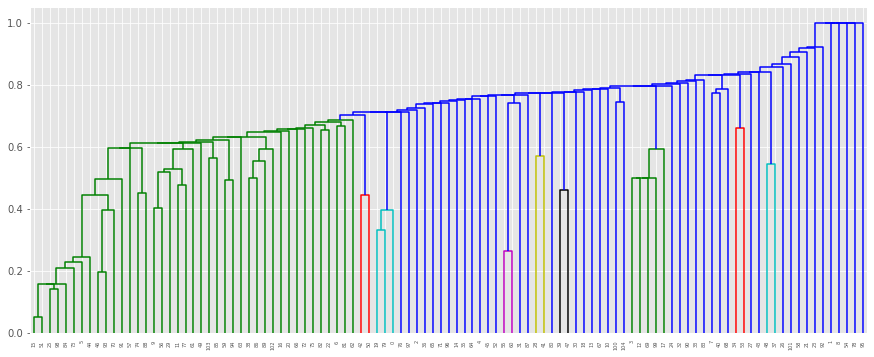

113


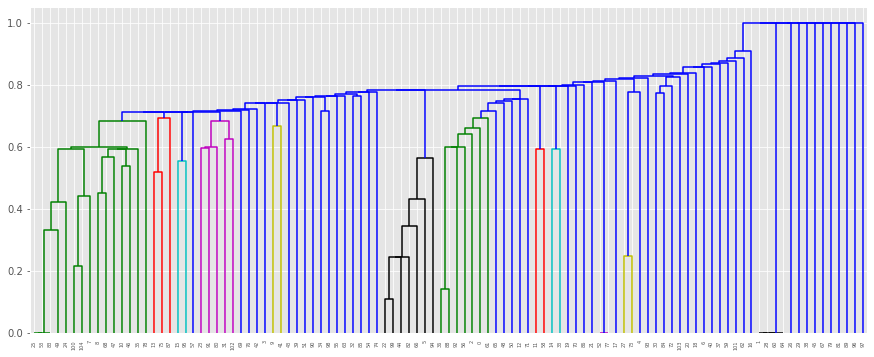

114


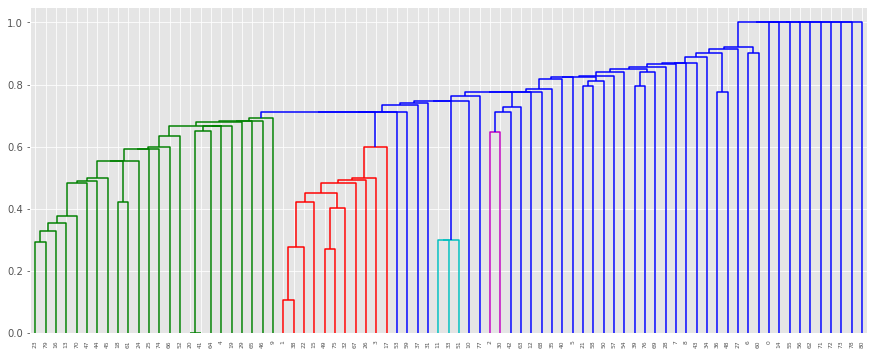

115


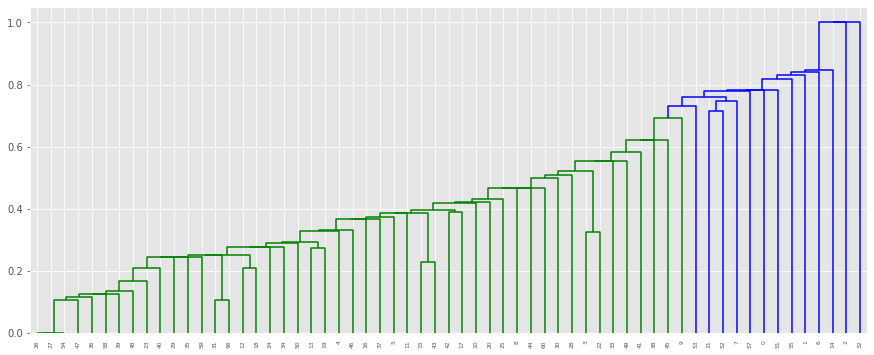

116


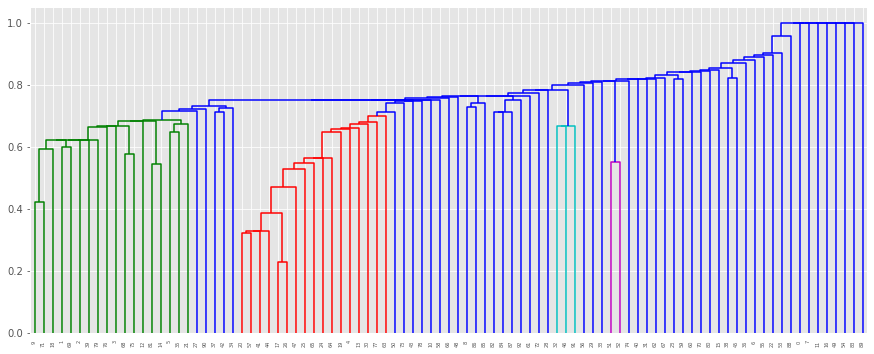

117


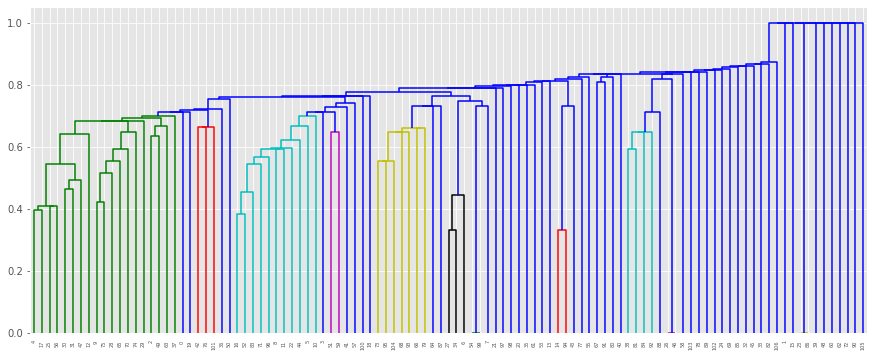

118


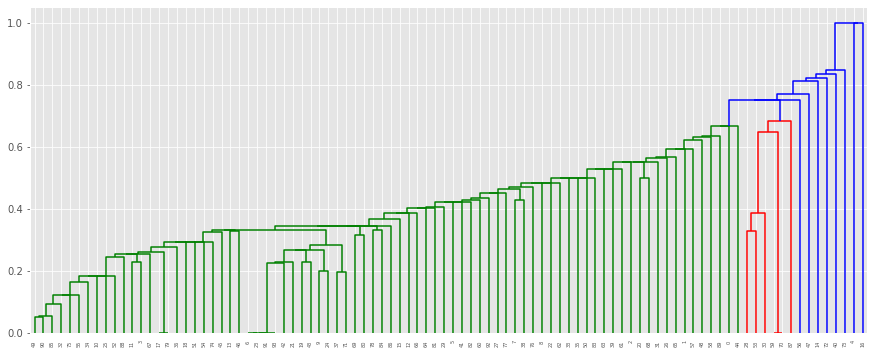

119


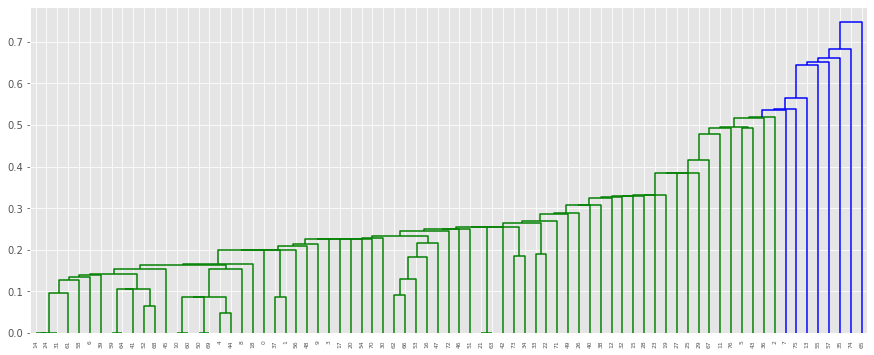

120


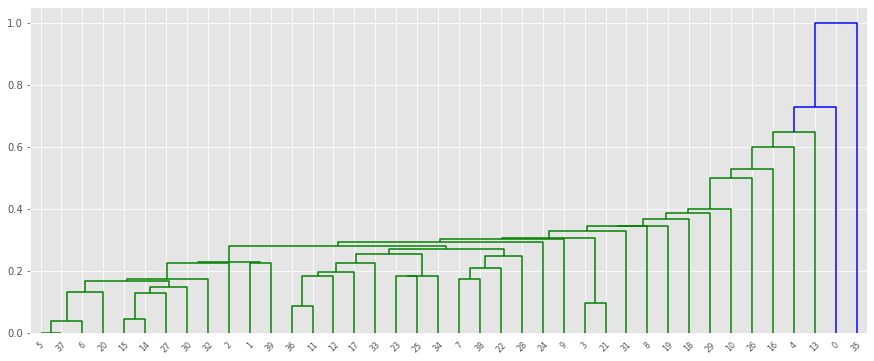

121


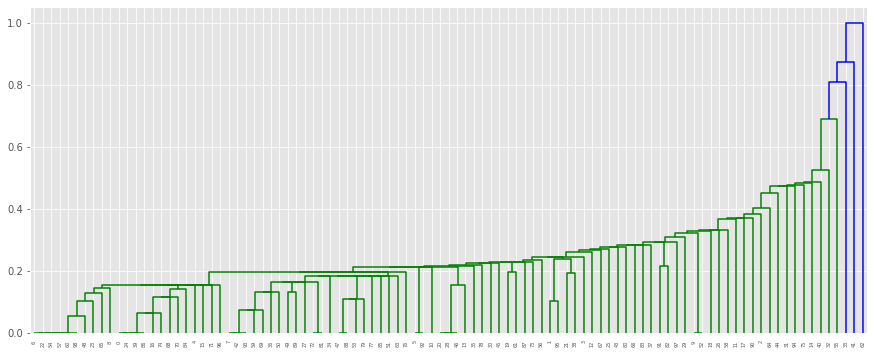

122


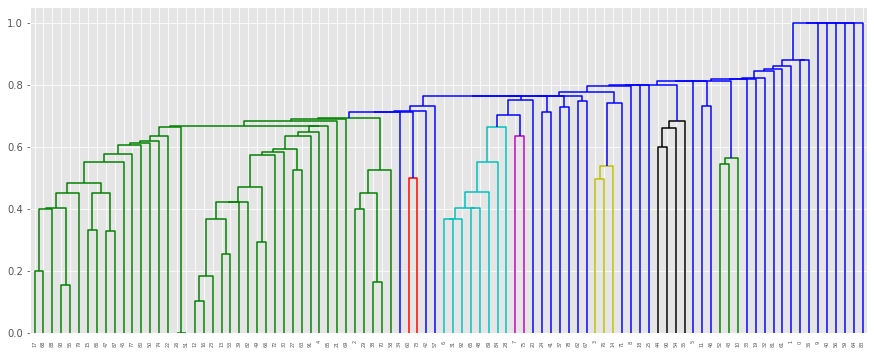

123


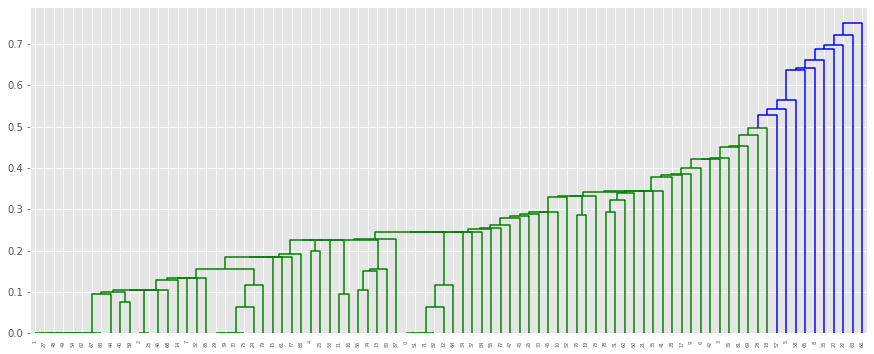

124


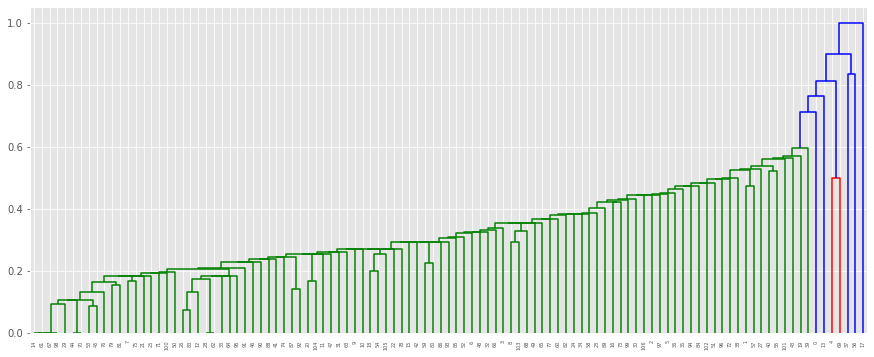

125


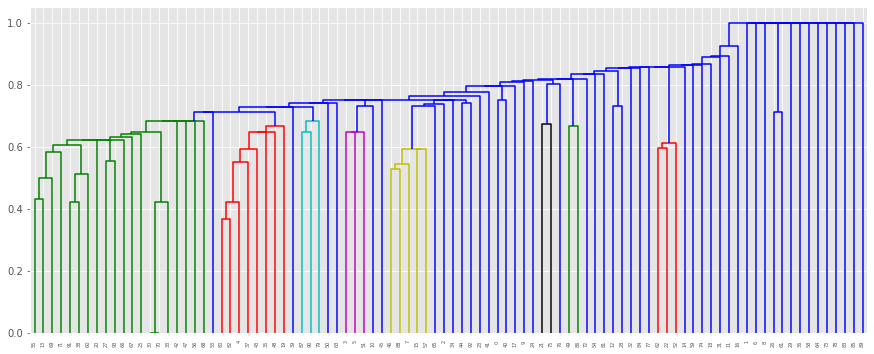

126


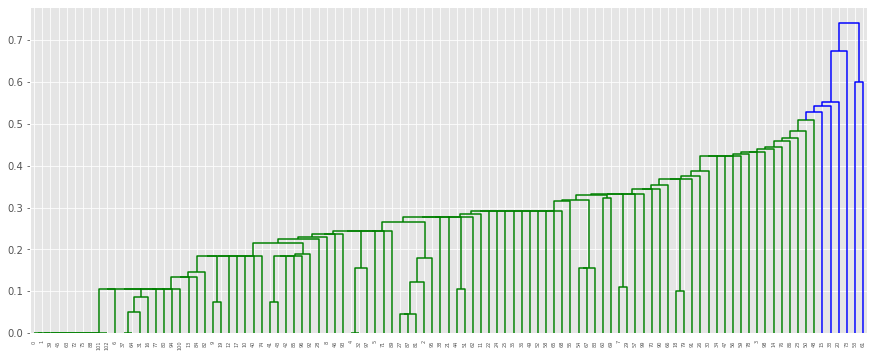

127


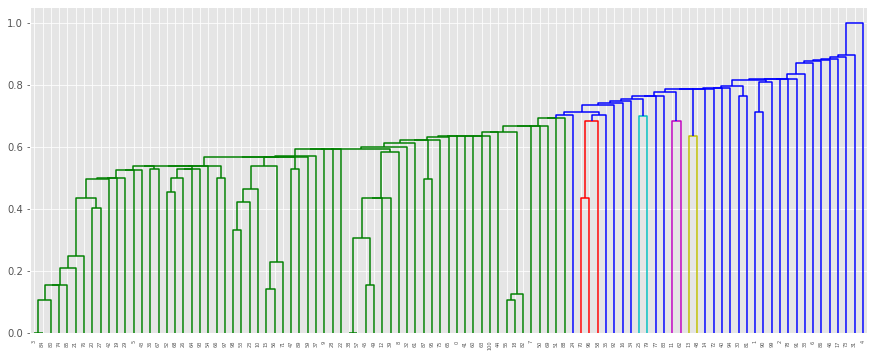

128


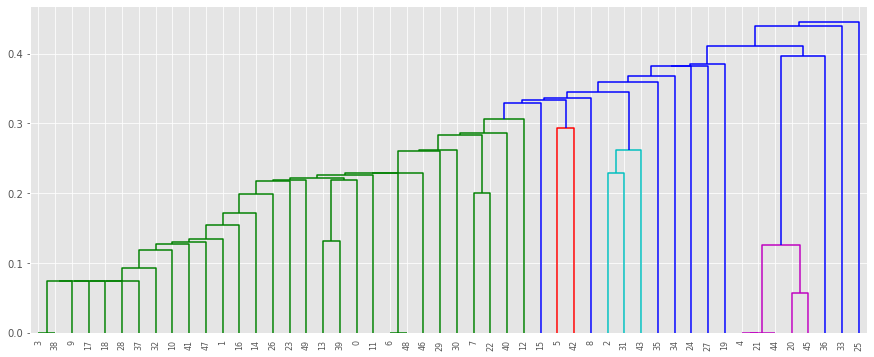

129


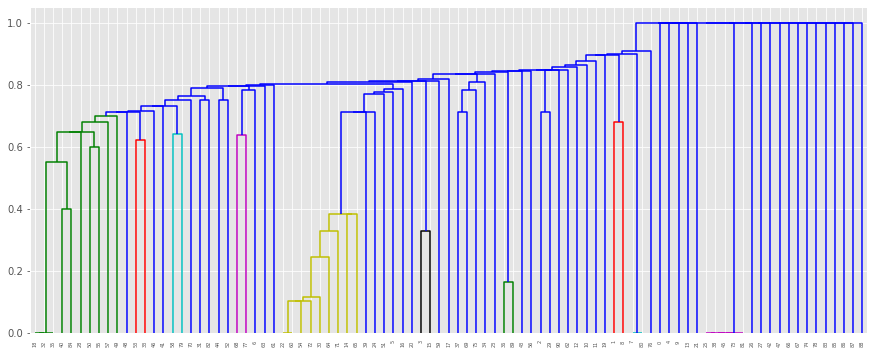

In [14]:
link='single'
metr='cosine'

for gr,value in traingroups_titledata.items():
    words=dict()
    for i in value:
        for word in i[1]:
            if word not in words:
                
                words[word]=len(words)
                
    x=np.zeros((len(value),len(words)))
    
    y=np.empty(len(value)).astype(int)
    

    for ind,i in enumerate(value):
        for word in i[1]:
            x[ind,words[word]]+=1
        y[ind]=i[2]
    

    сustum_aggl = Clustering(metric=metr,n_clusters=1,linkage=link)
    a=сustum_aggl.fit(x)
    fig=plt.figure(figsize=(15,6))
    print(gr)
    a.plot_dendrogram()


**В качестве метрики использую процент пересикающихся слов**

1


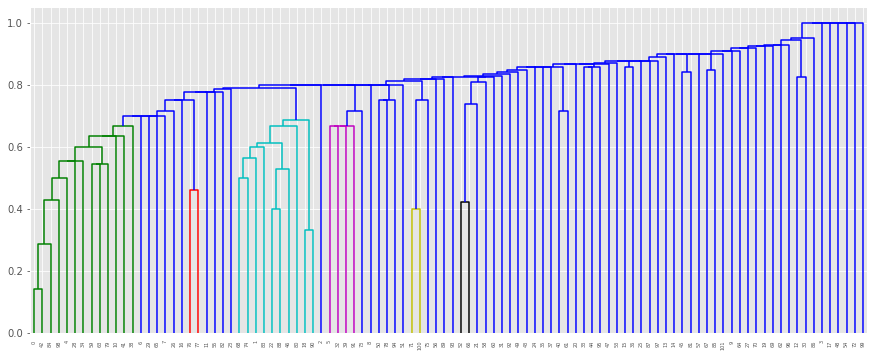

2


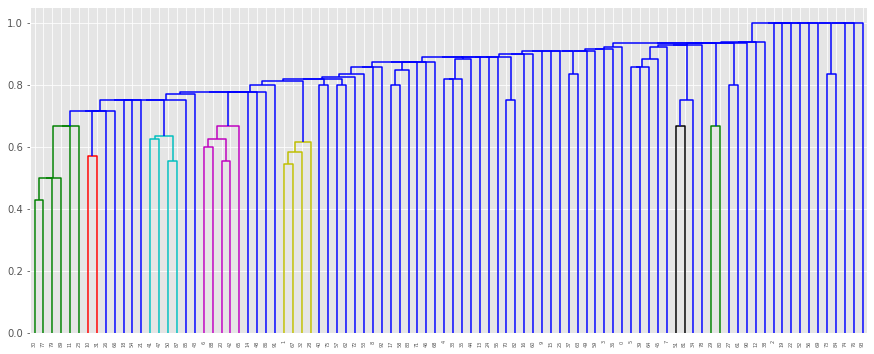

3


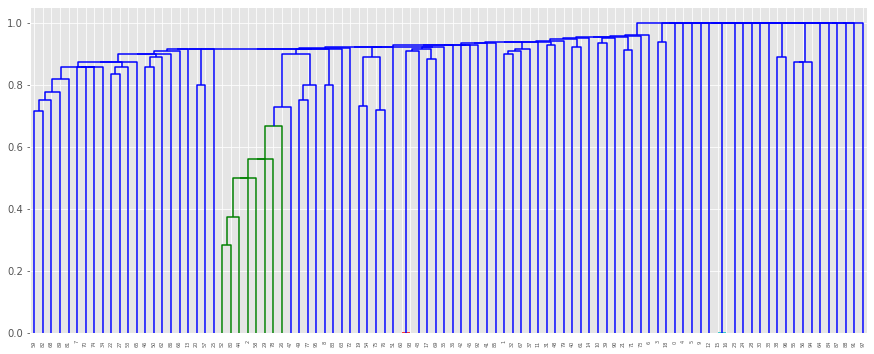

4


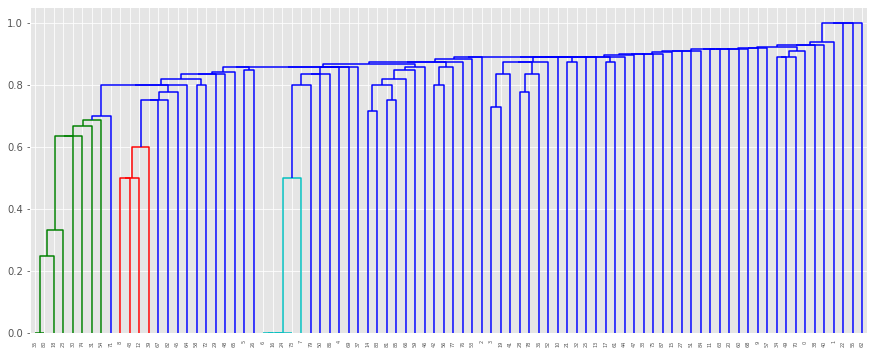

5


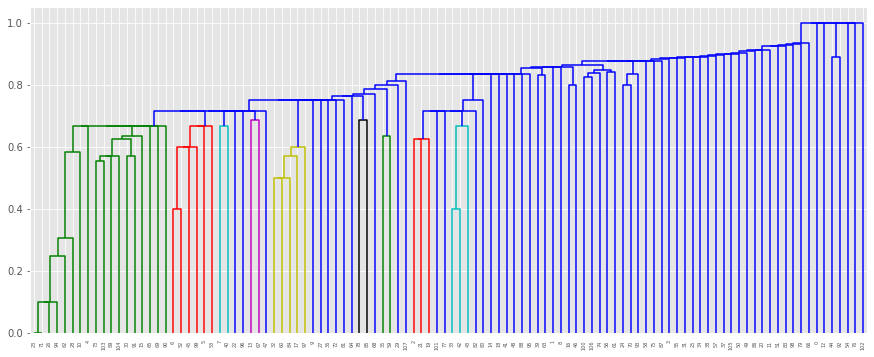

6


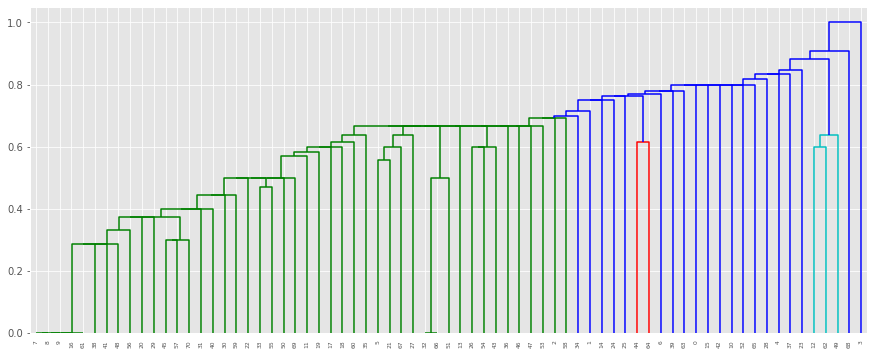

7


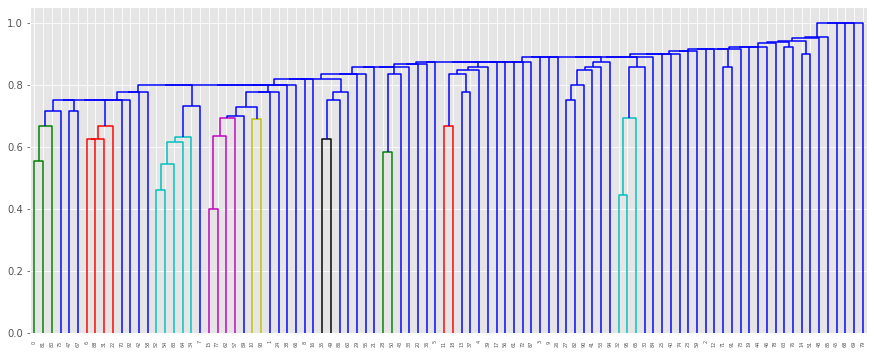

8


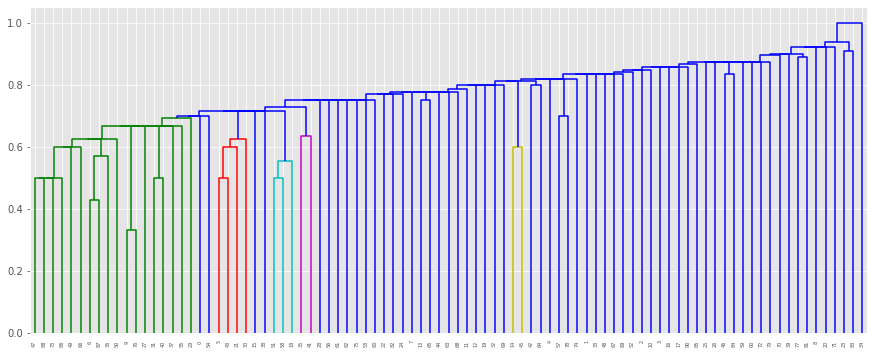

9


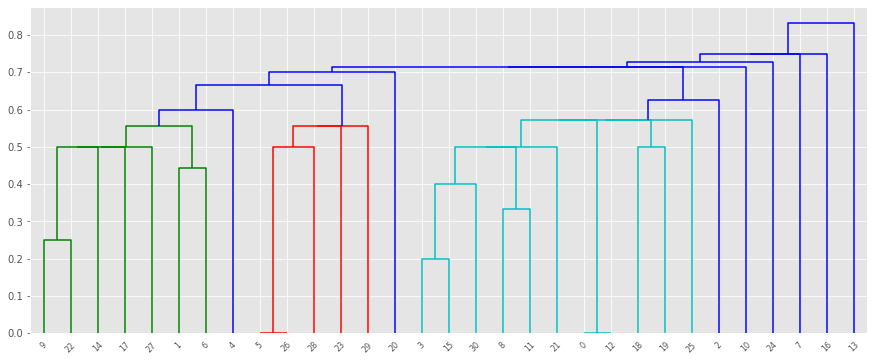

10


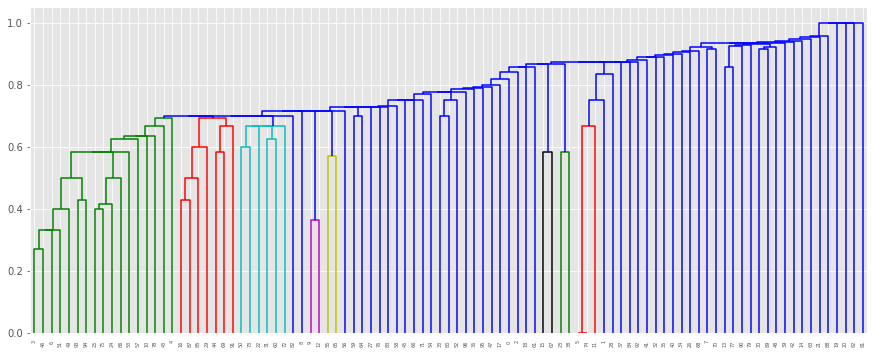

11


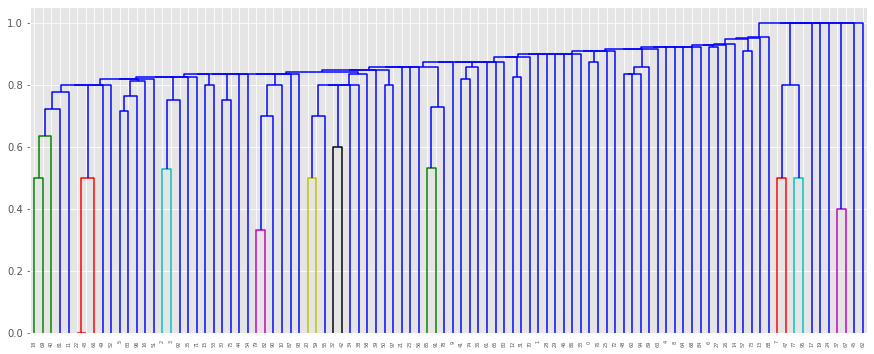

12


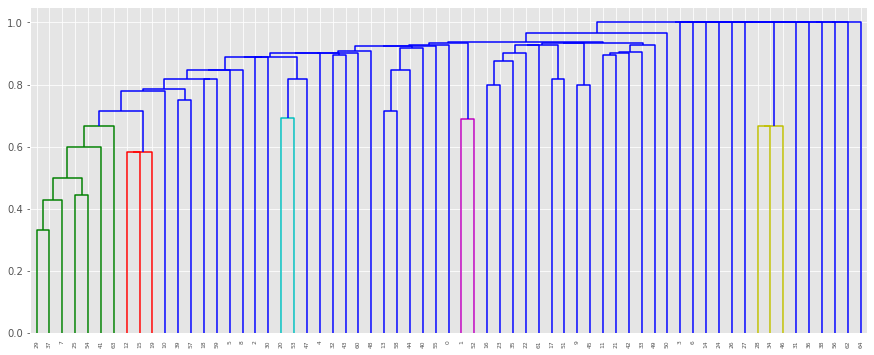

13


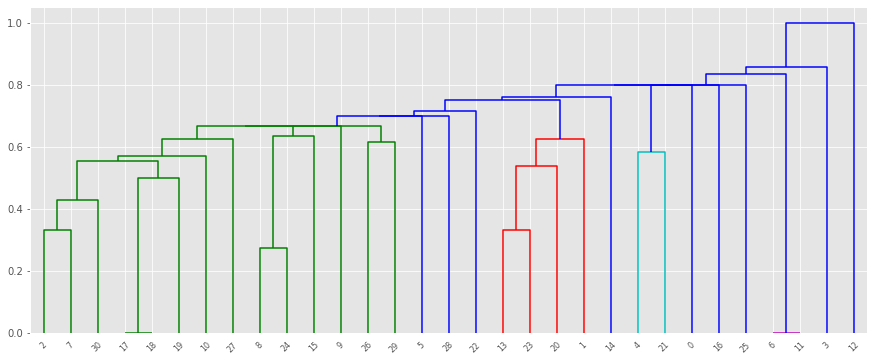

14


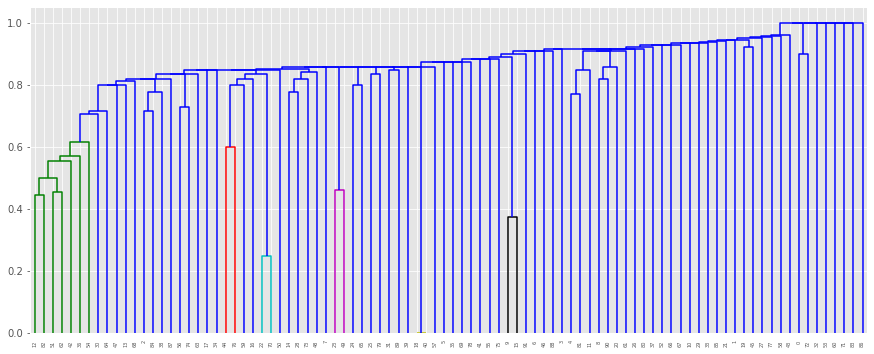

15


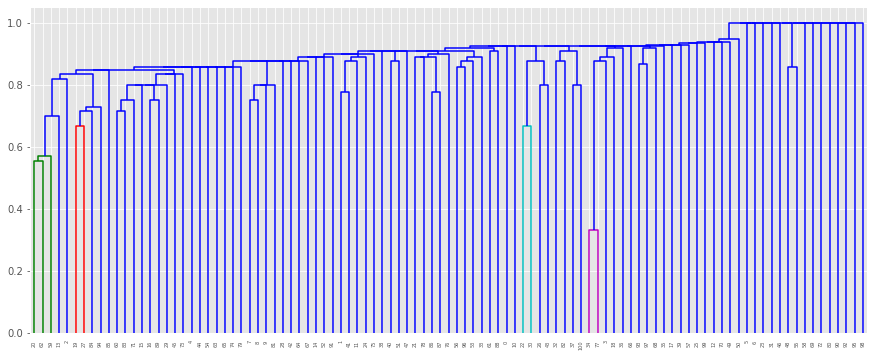

16


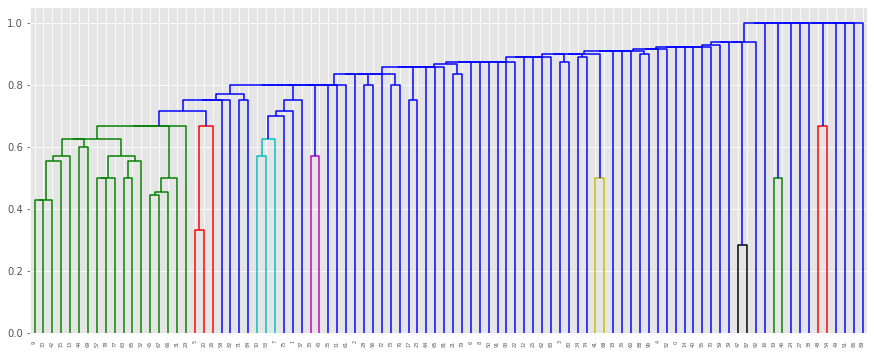

17


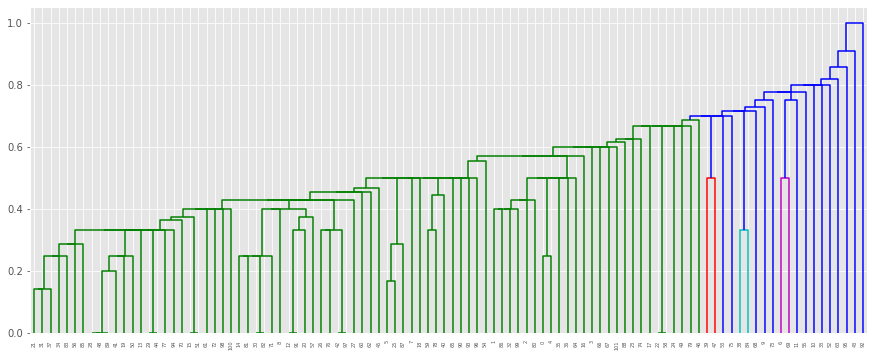

18


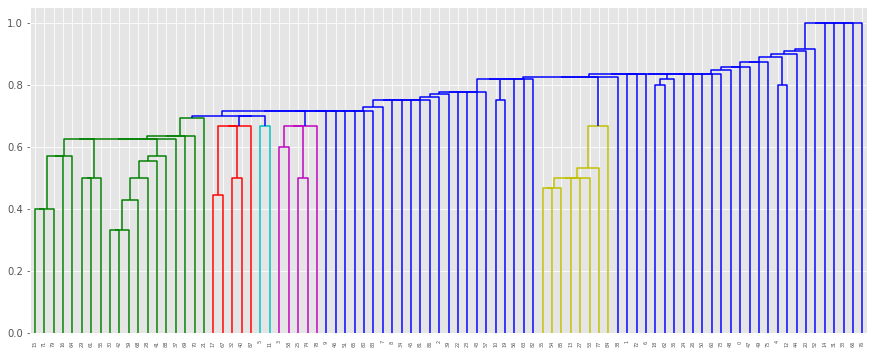

19


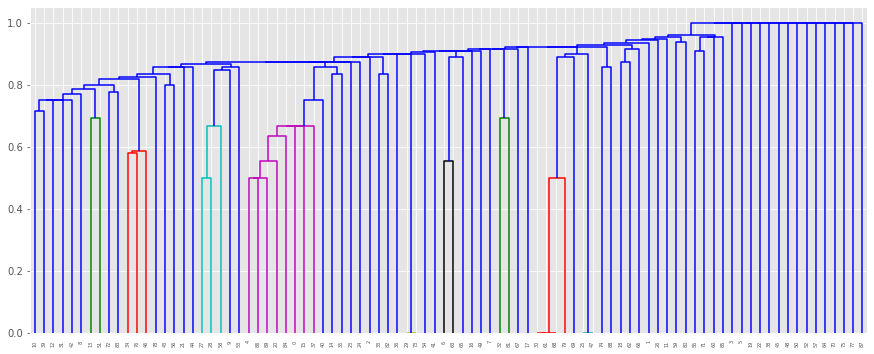

20


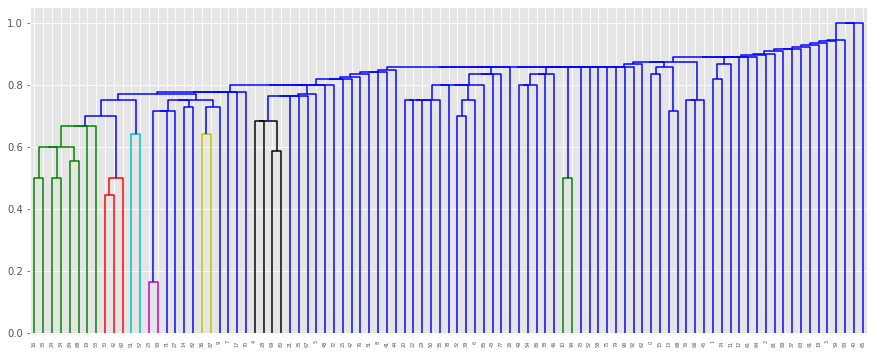

21


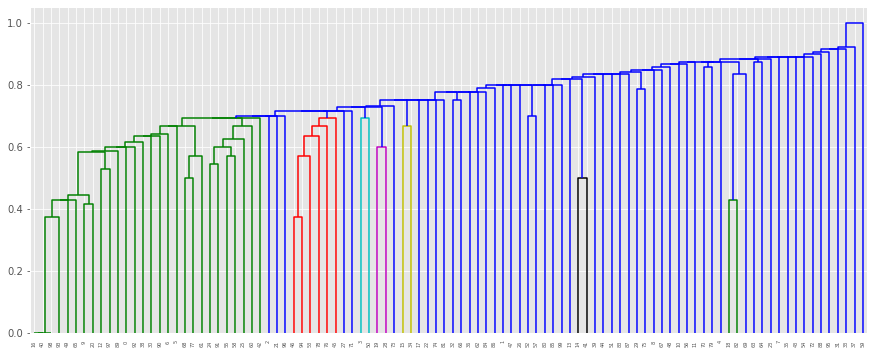

22


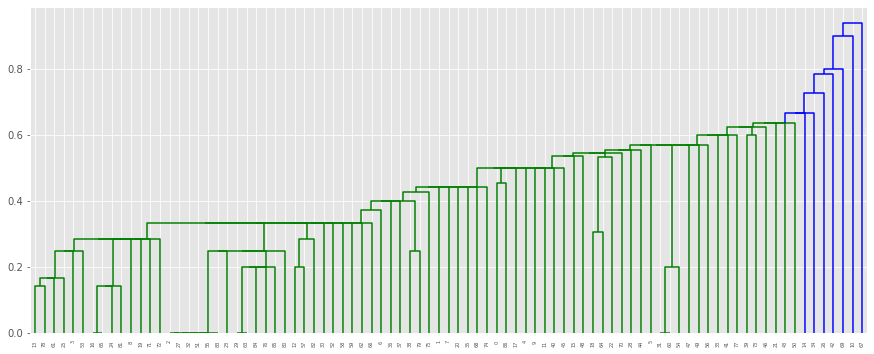

23


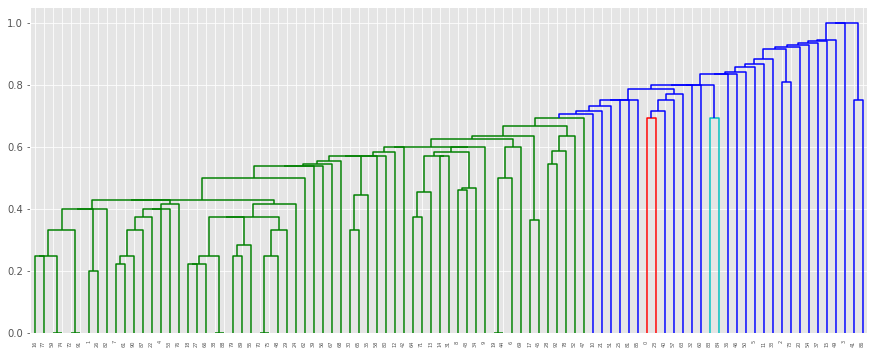

24


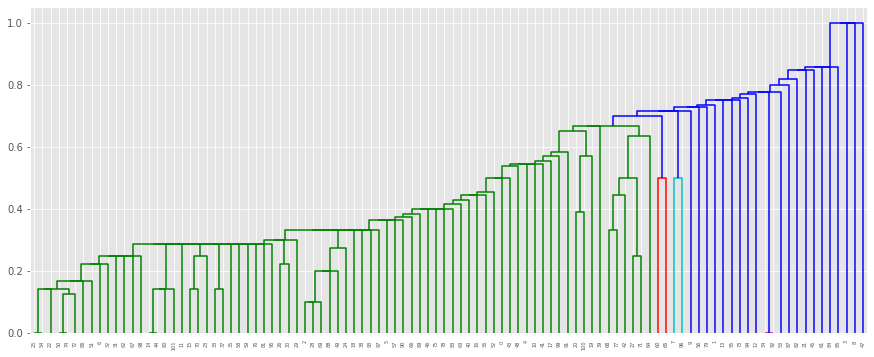

25


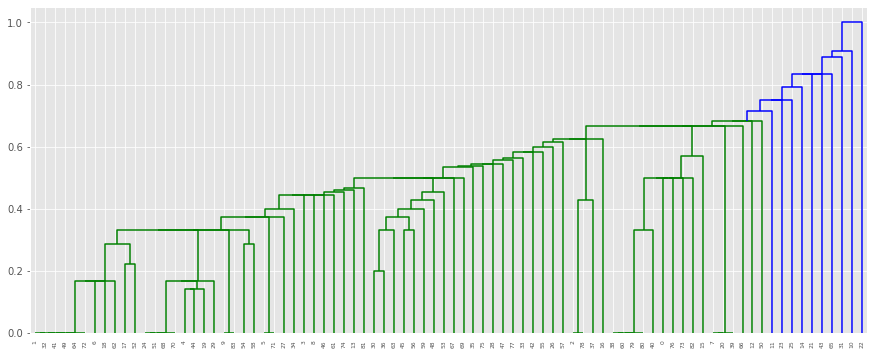

26


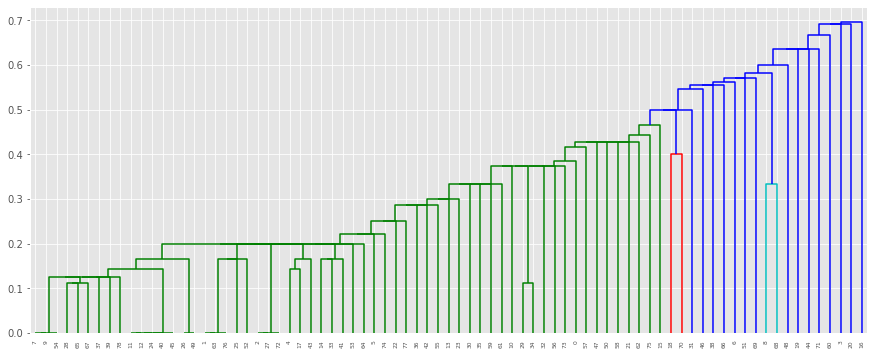

27


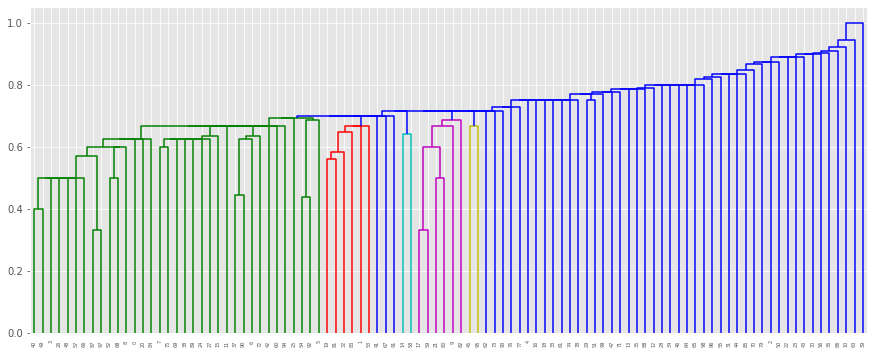

28


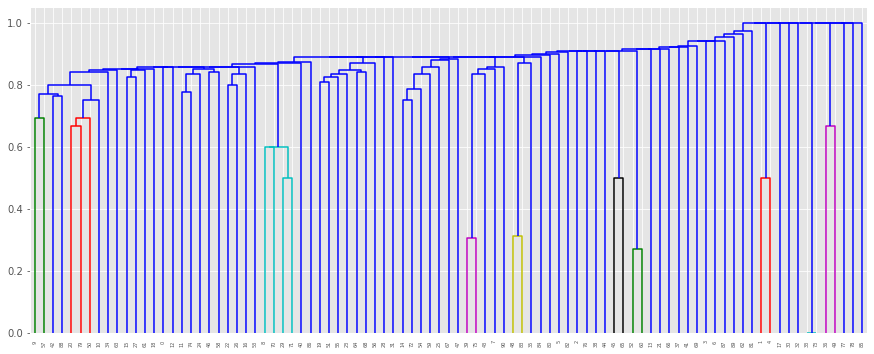

29


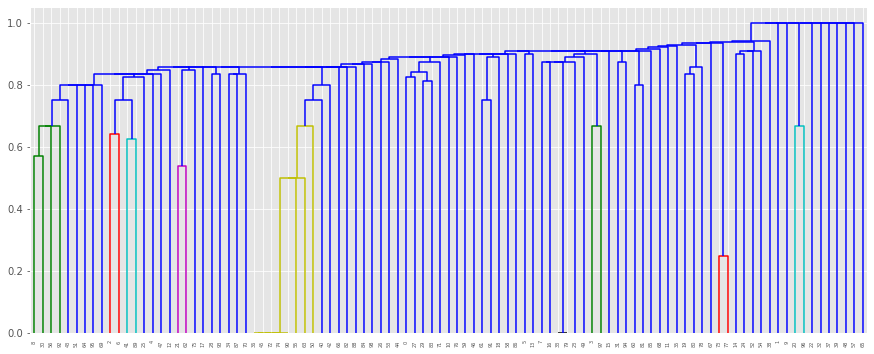

30


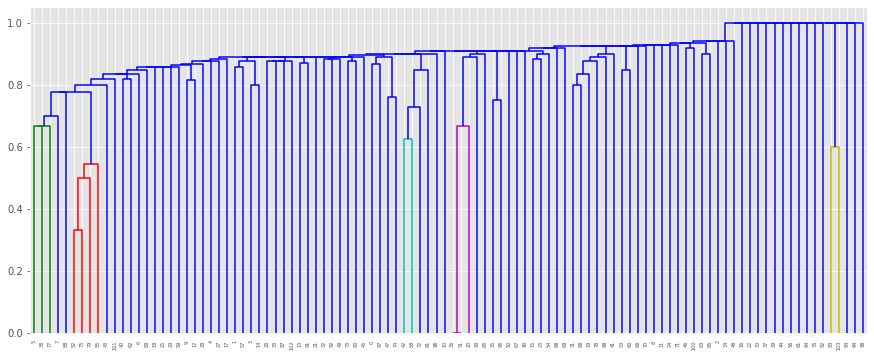

31


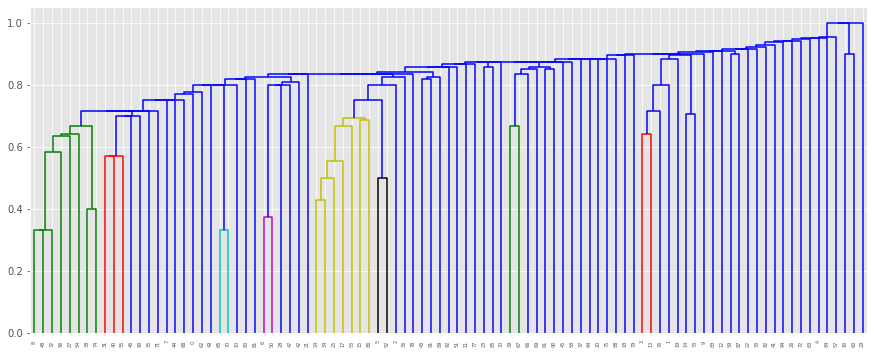

32


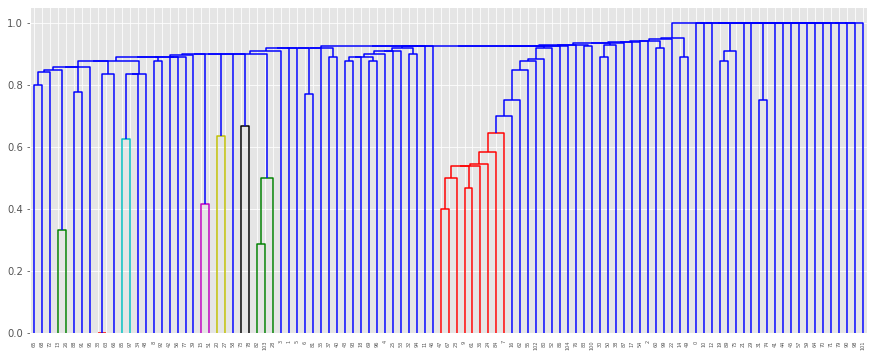

33


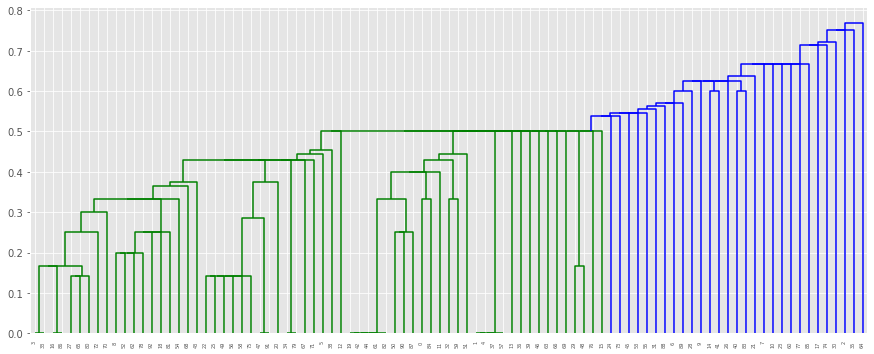

34


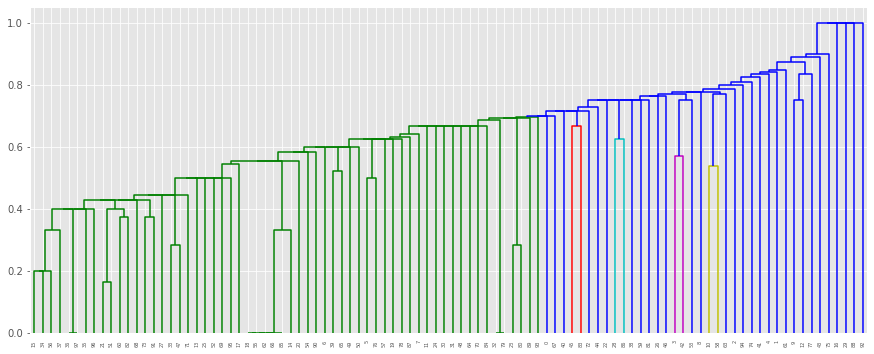

35


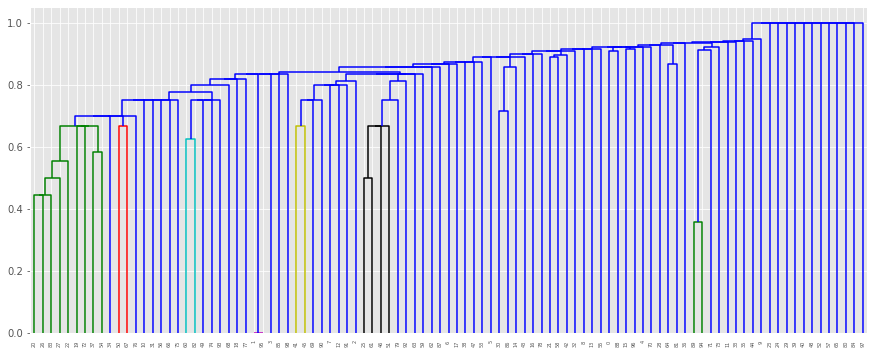

36


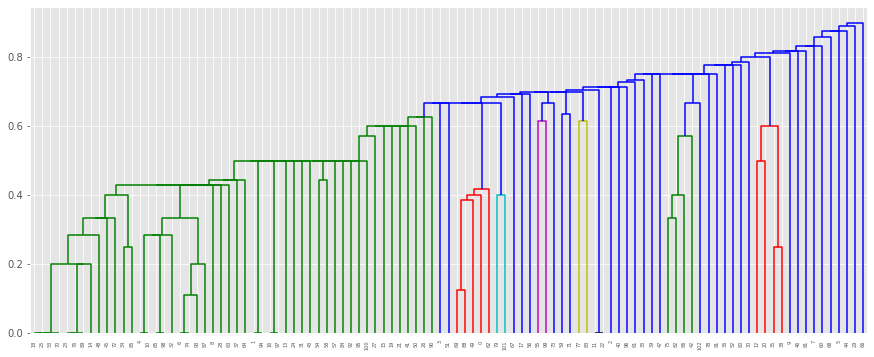

37


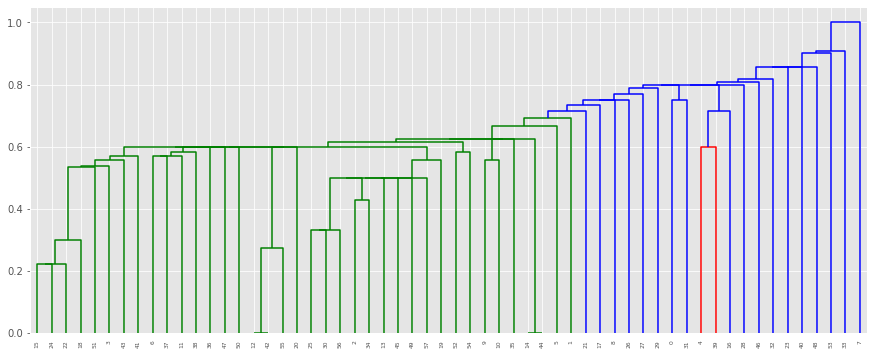

38


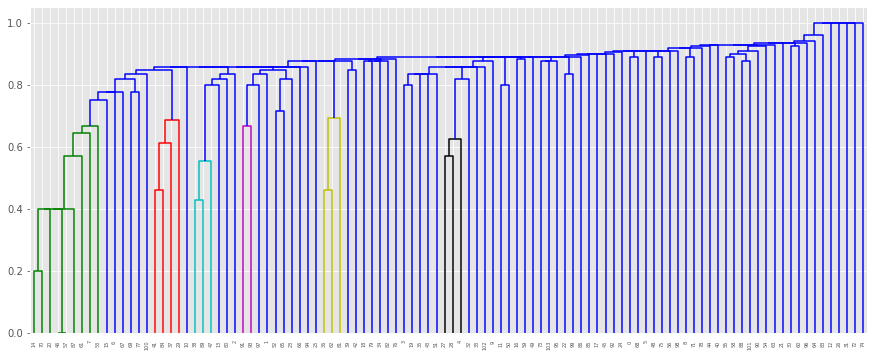

39


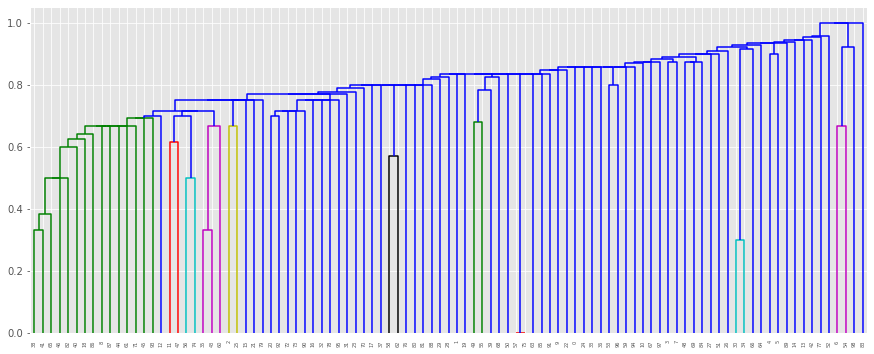

40


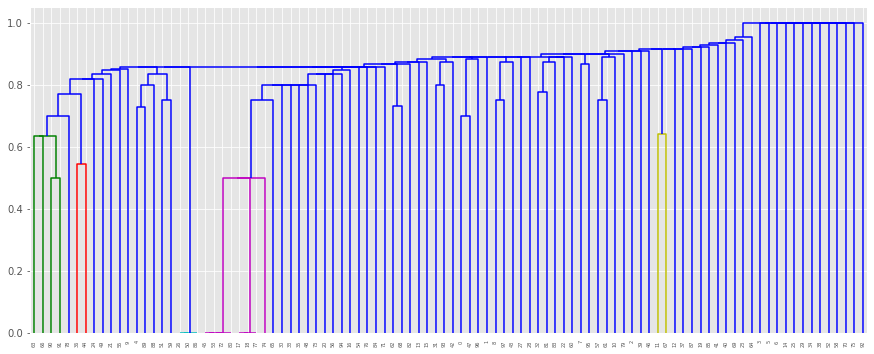

41


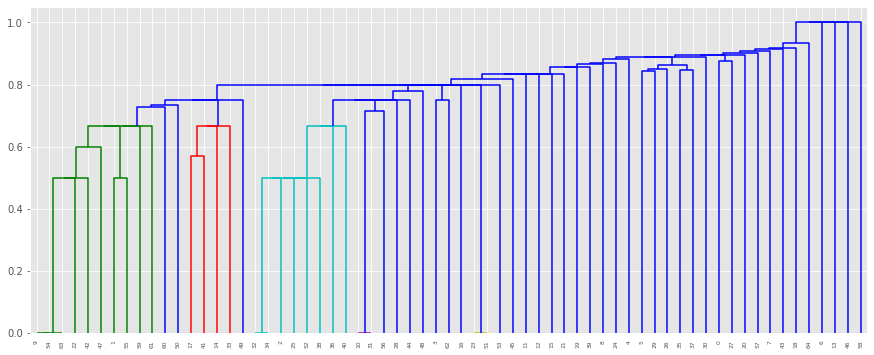

42


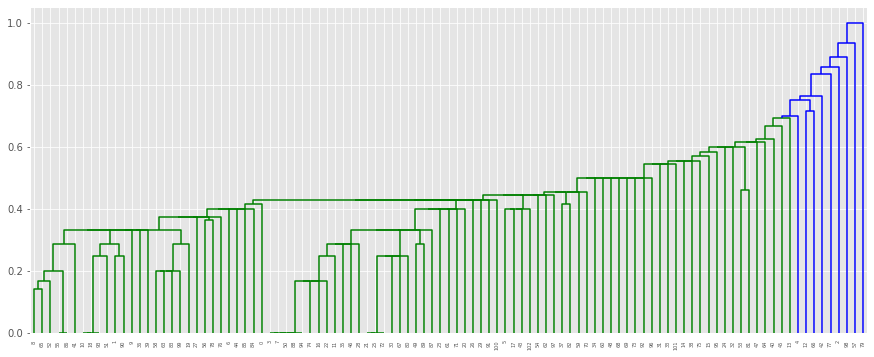

43


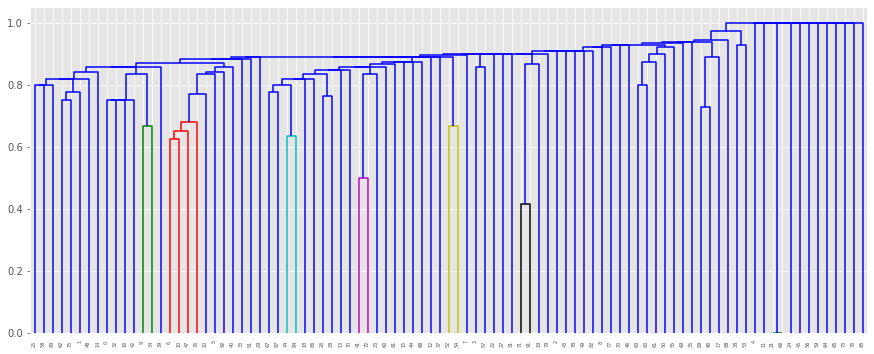

44


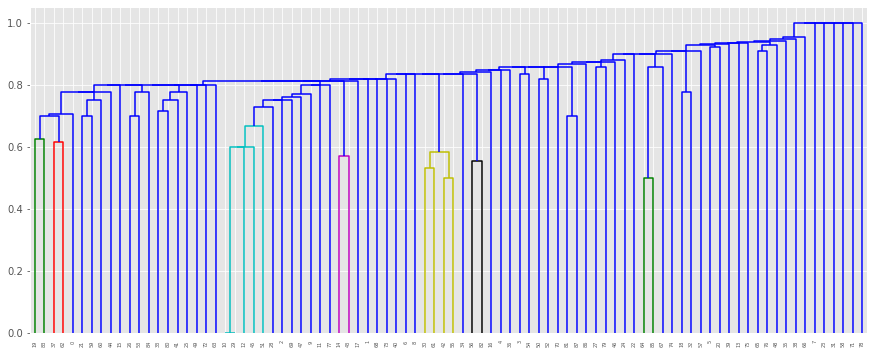

45


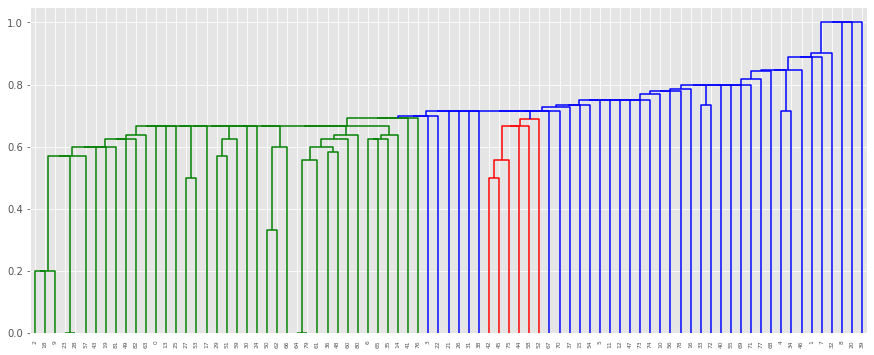

46


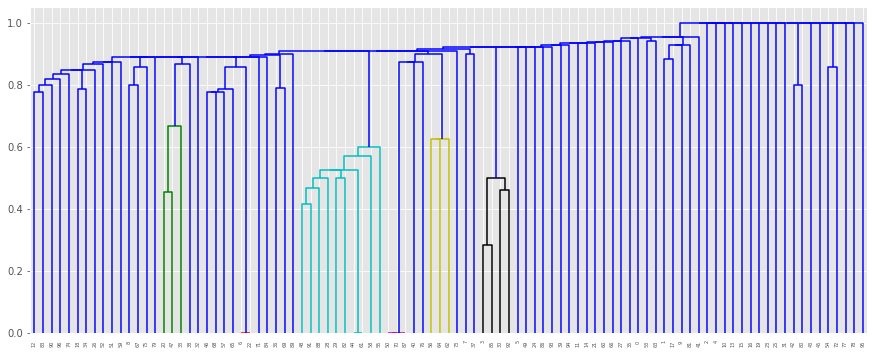

47


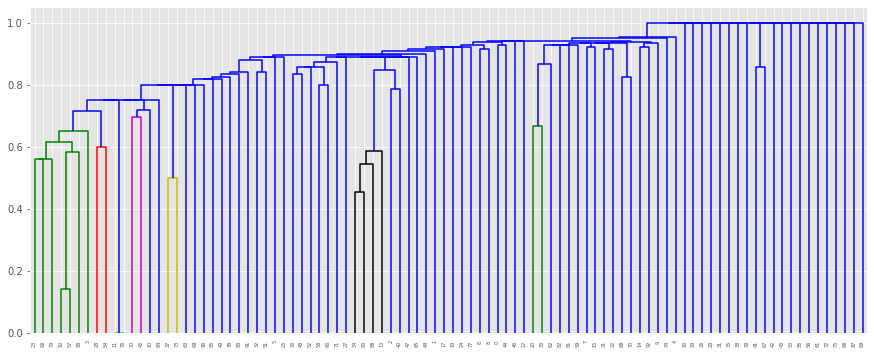

48


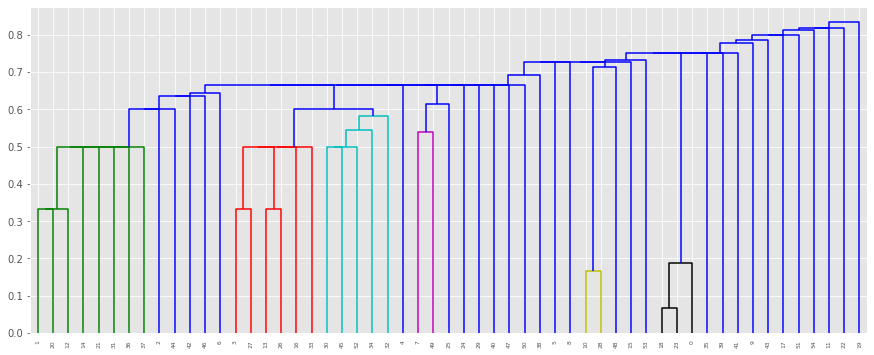

49


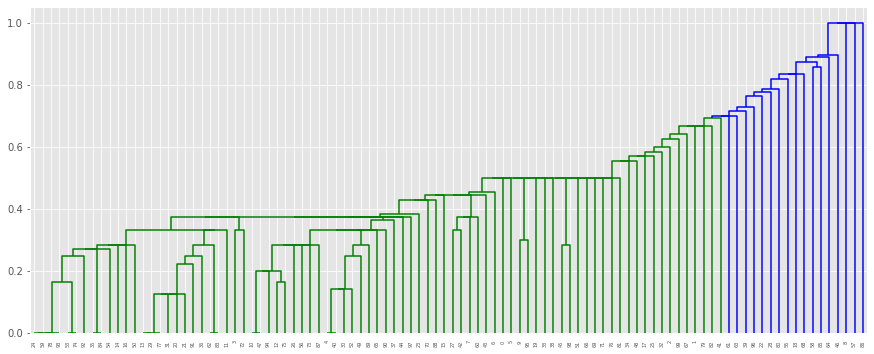

50


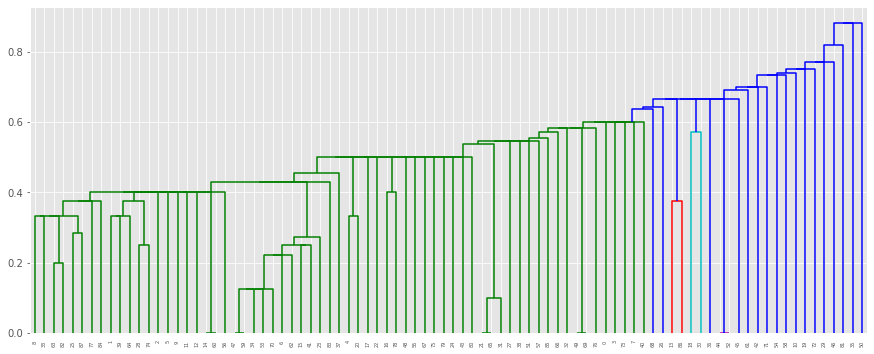

51


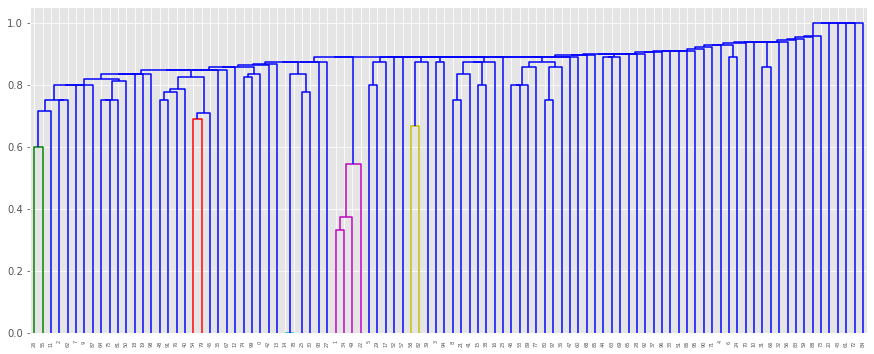

52


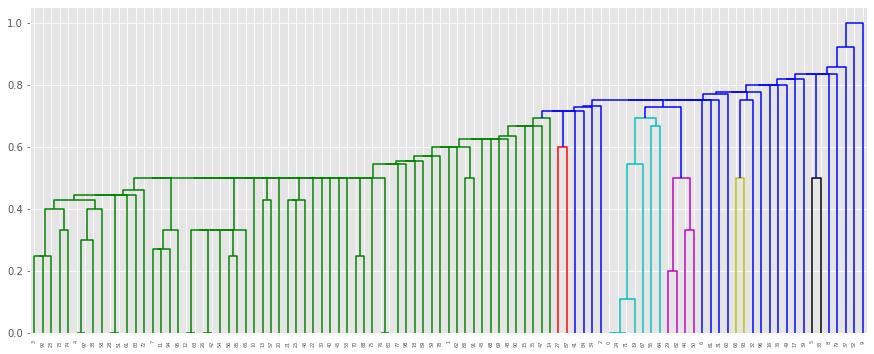

53


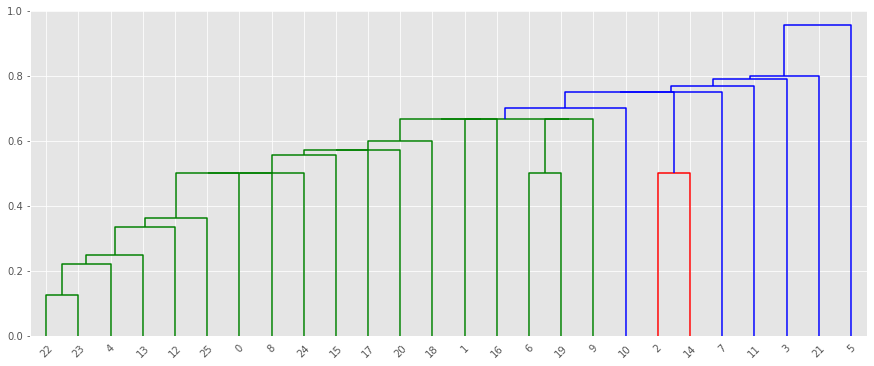

54


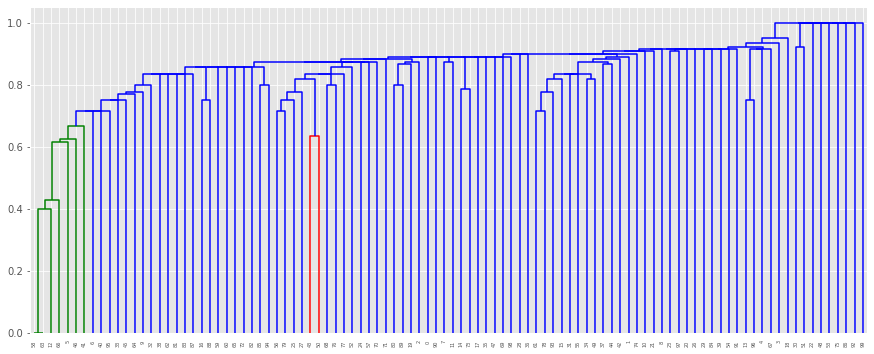

55


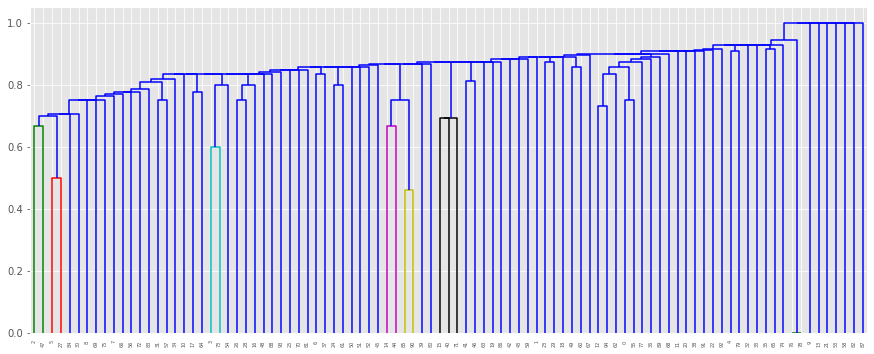

56


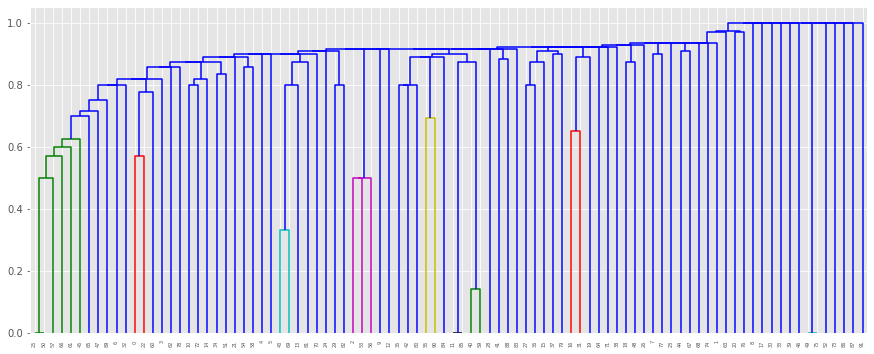

57


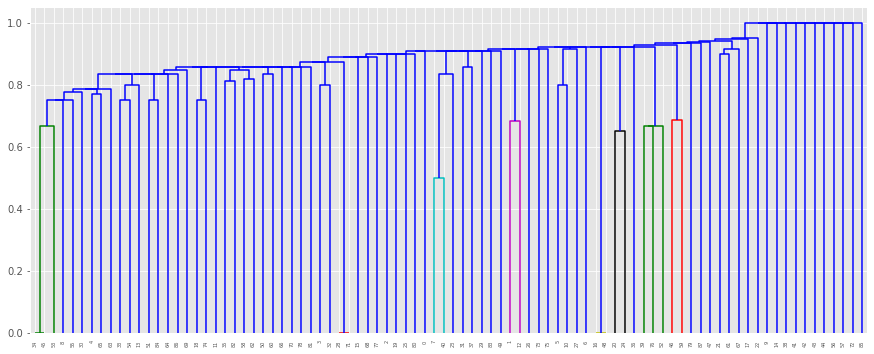

58


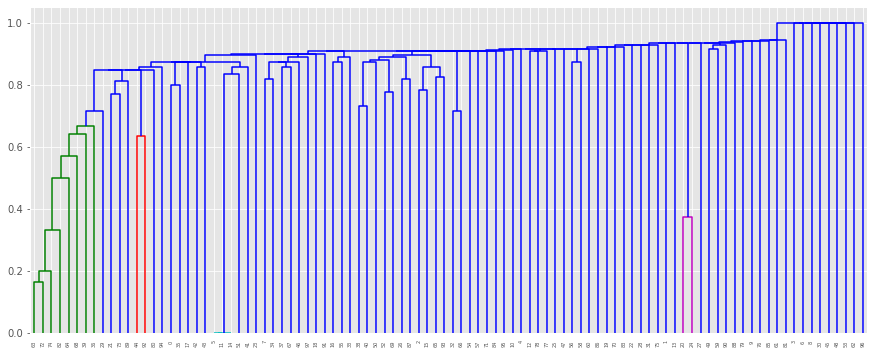

59


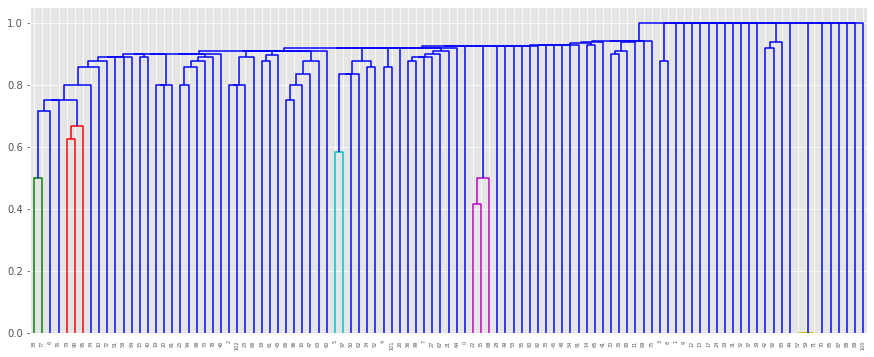

60


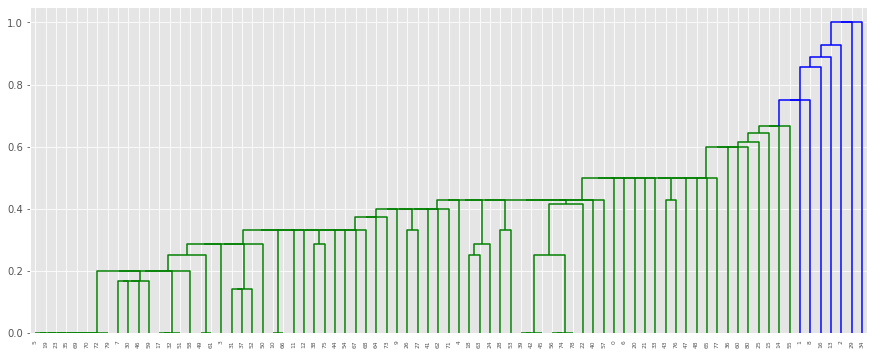

61


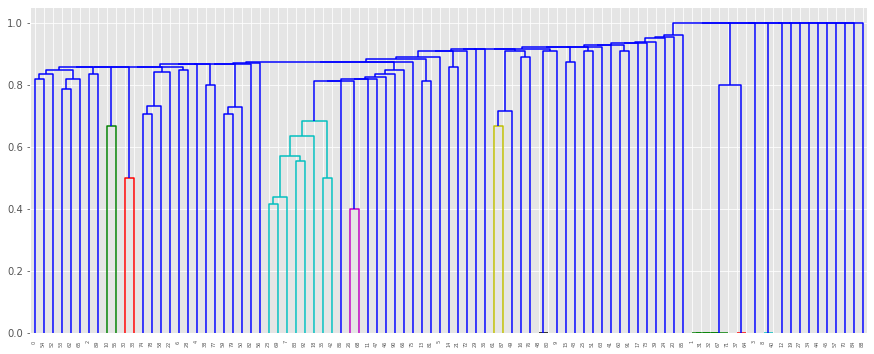

62


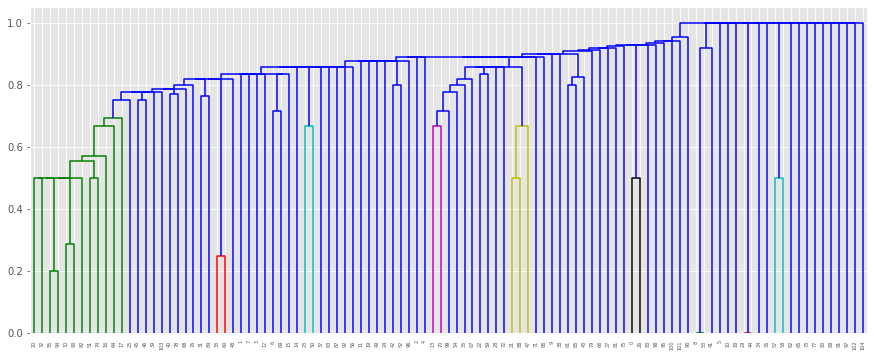

63


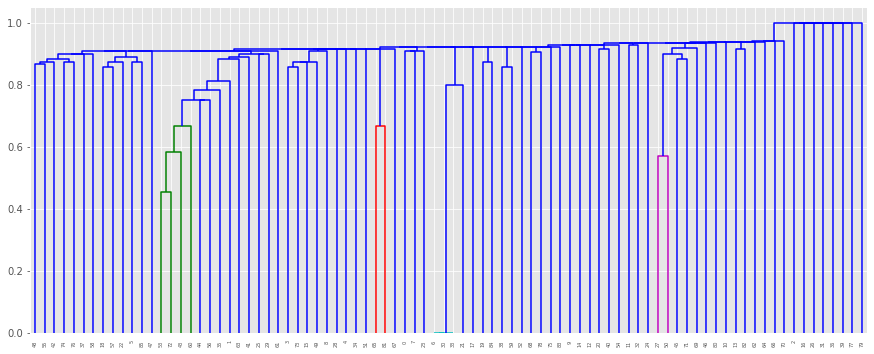

64


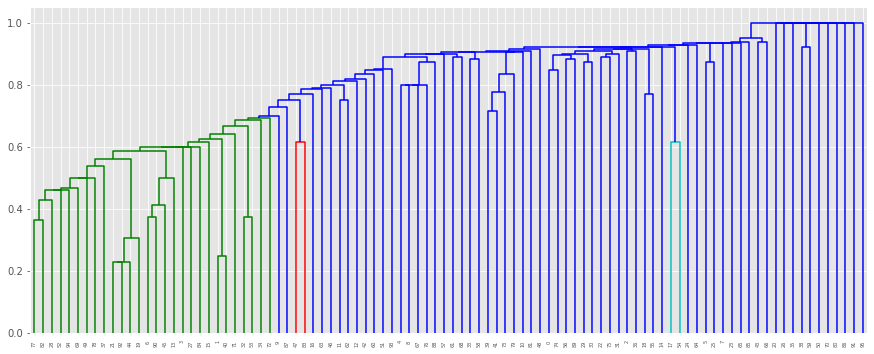

65


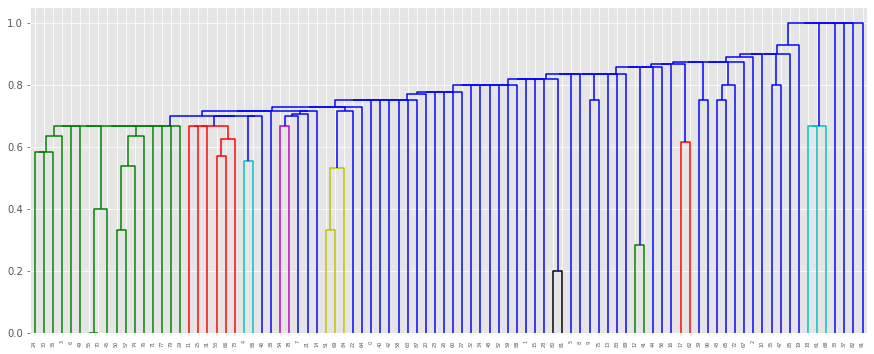

66


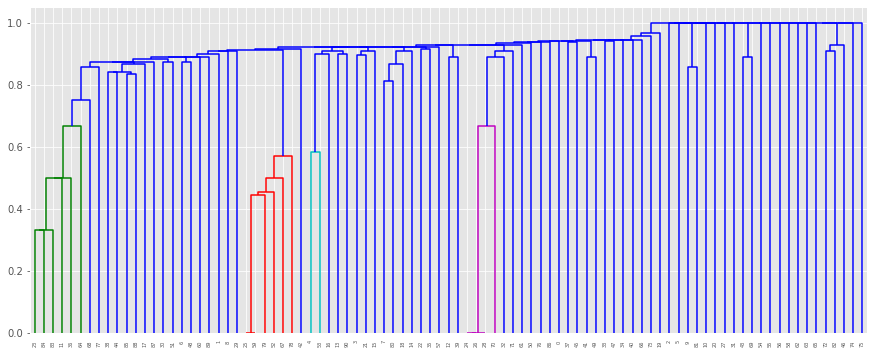

67


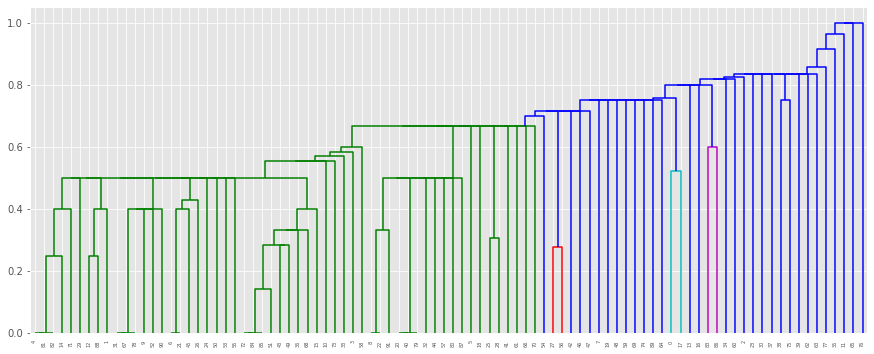

68


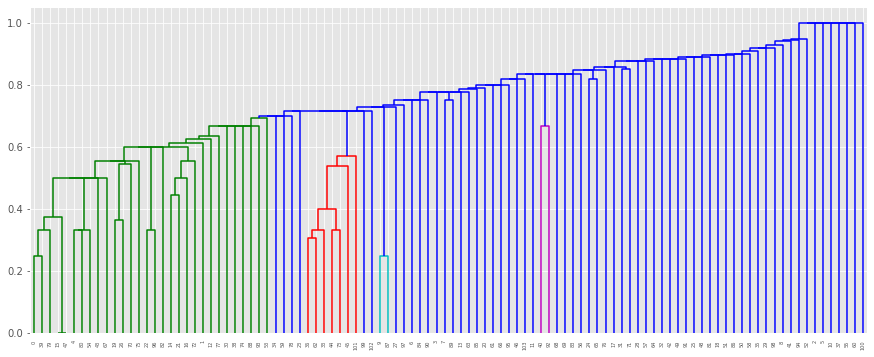

69


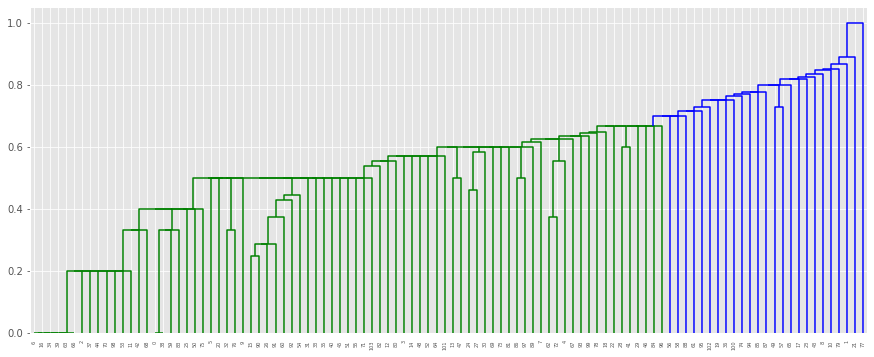

70


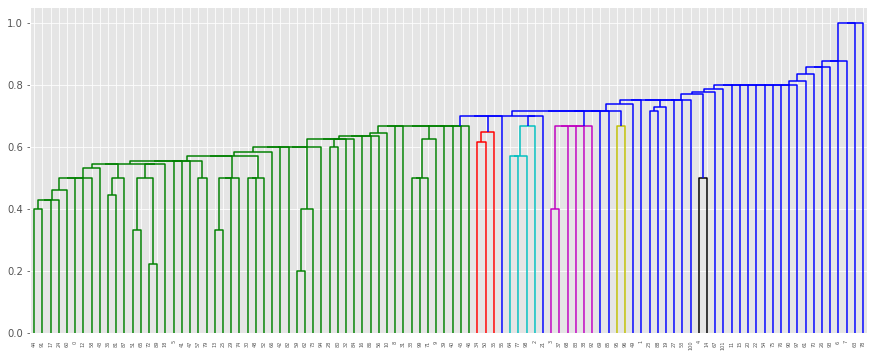

71


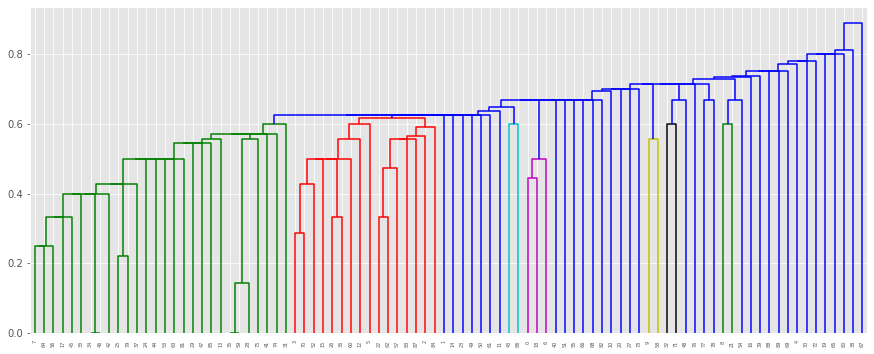

72


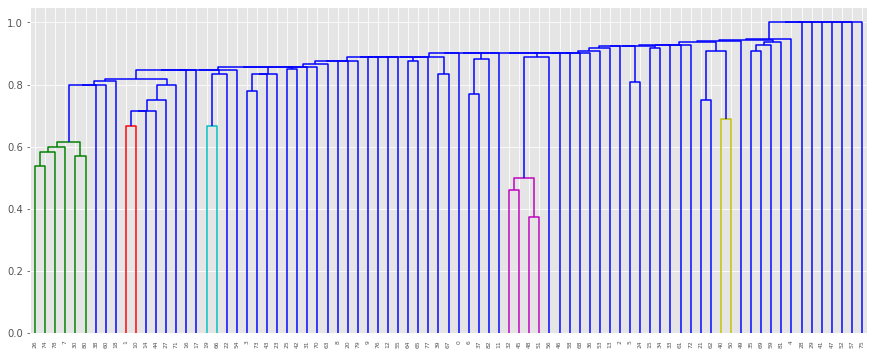

73


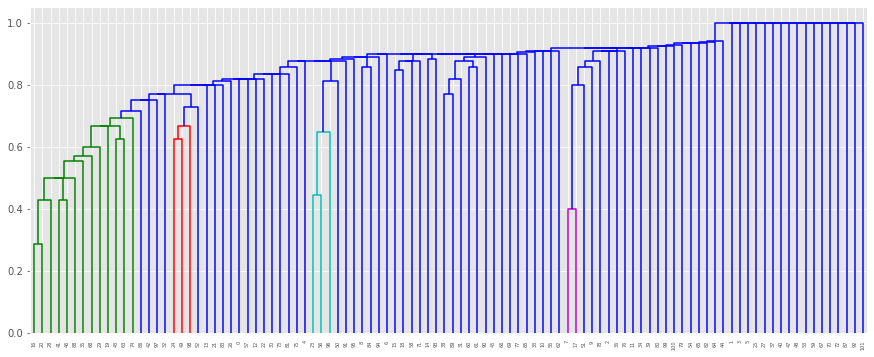

74


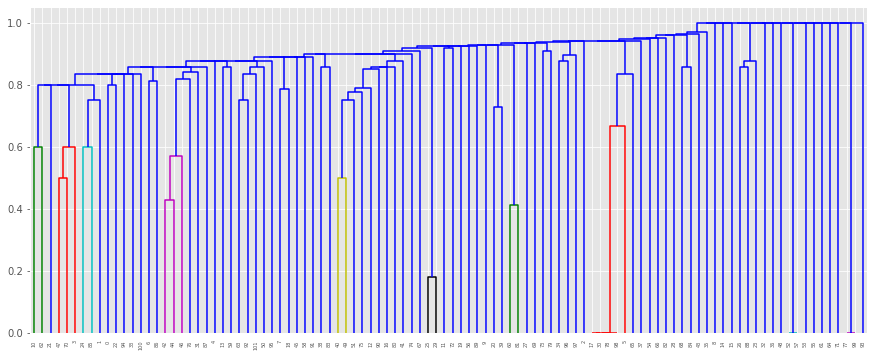

75


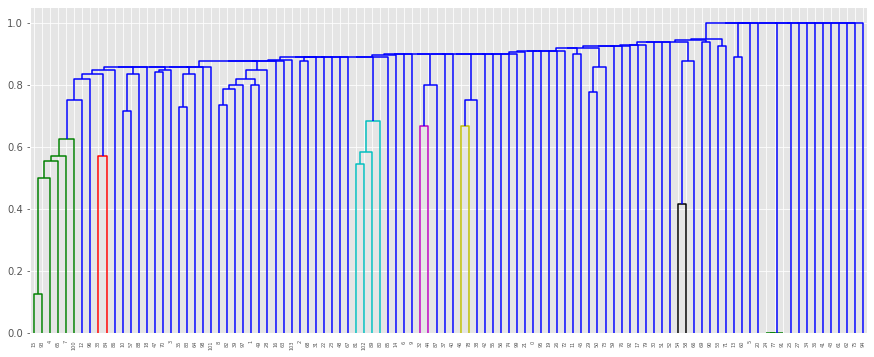

76


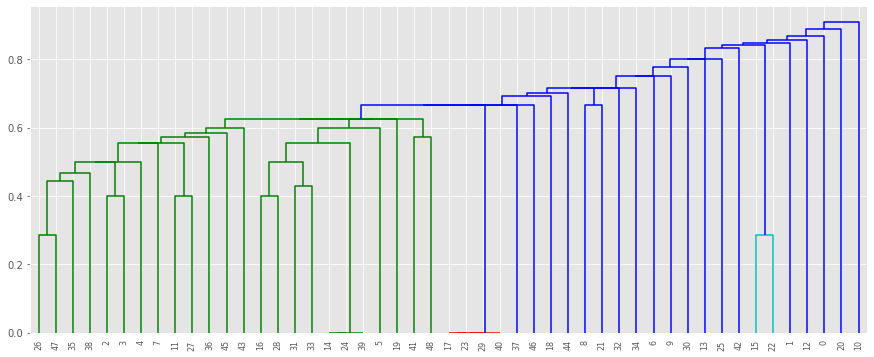

77


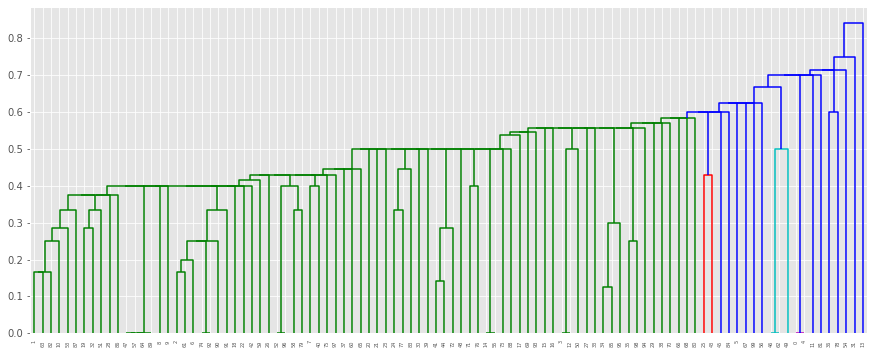

78


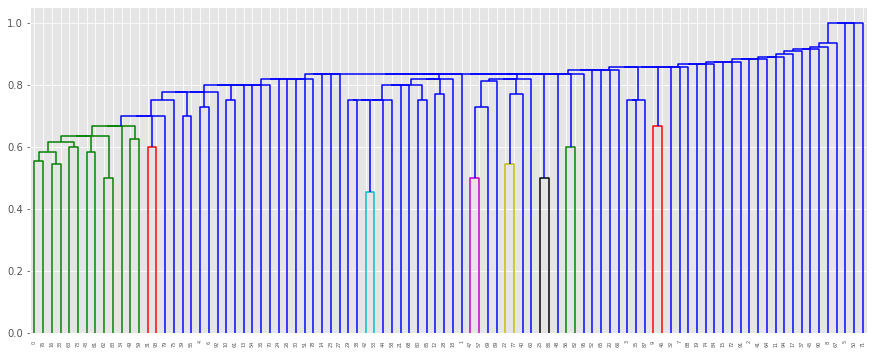

79


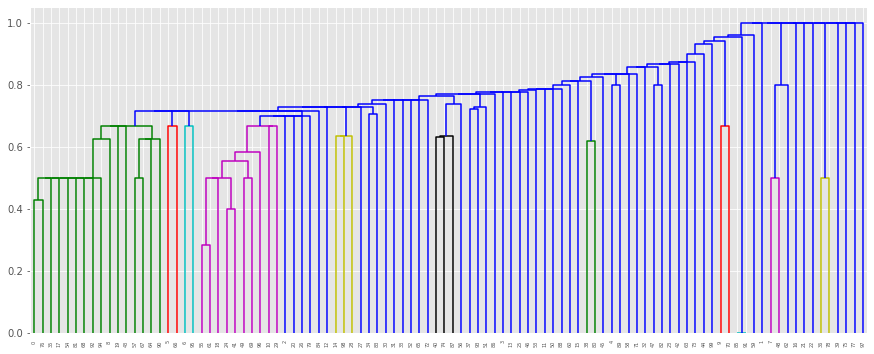

80


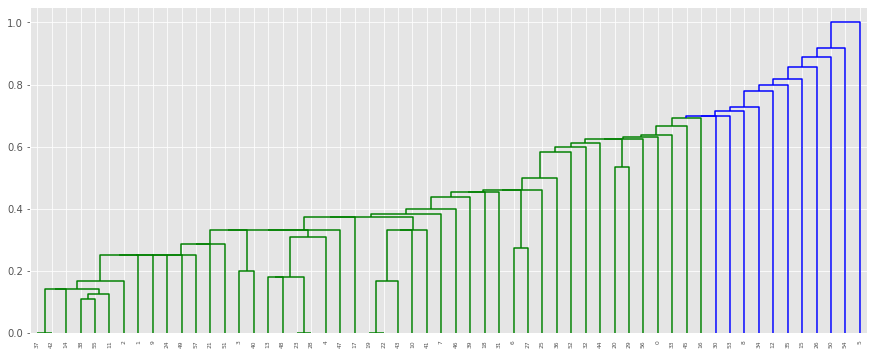

81


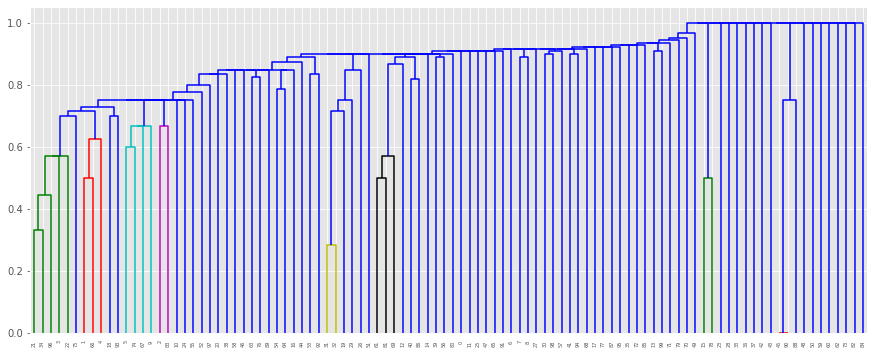

82


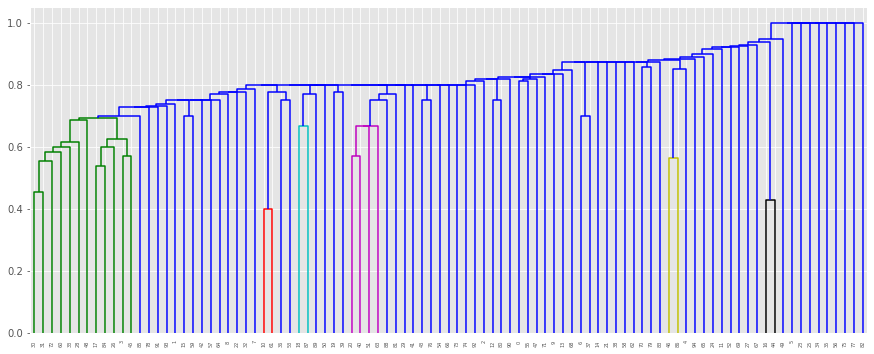

83


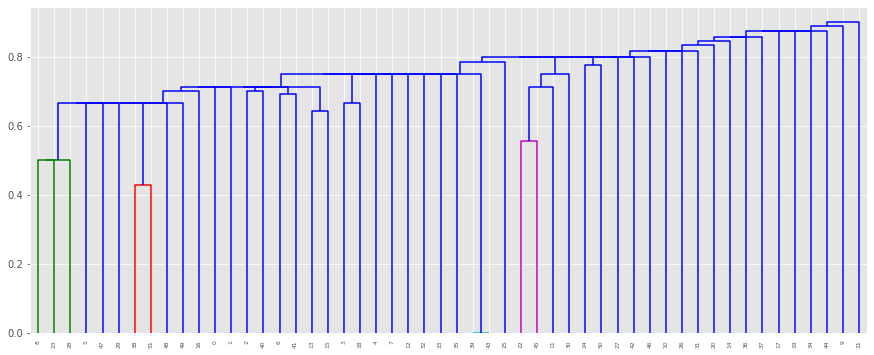

84


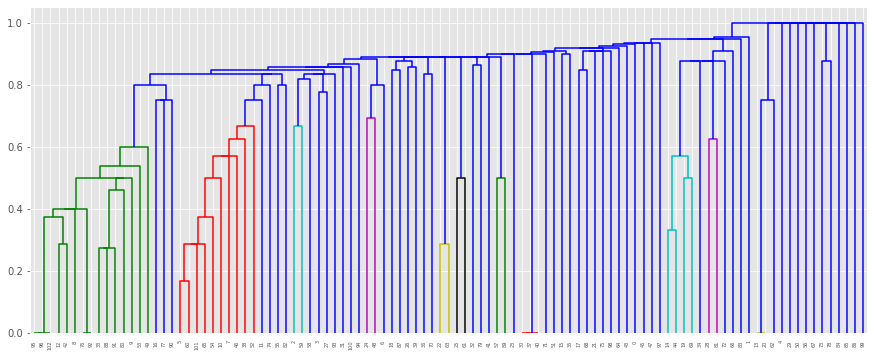

85


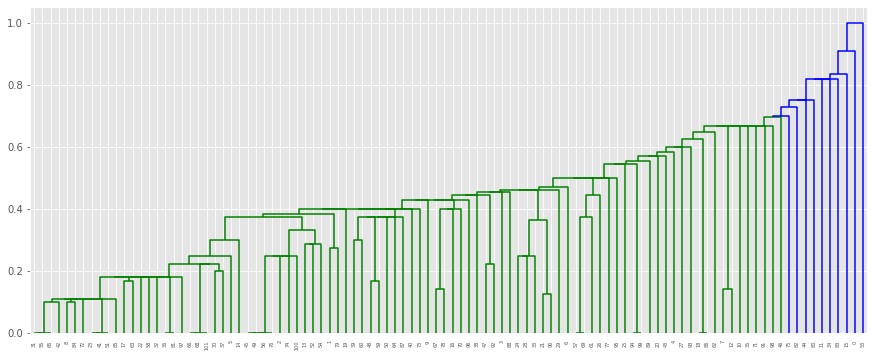

86


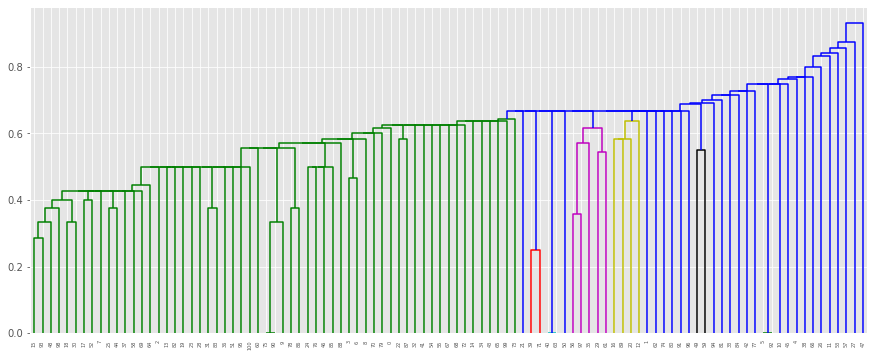

87


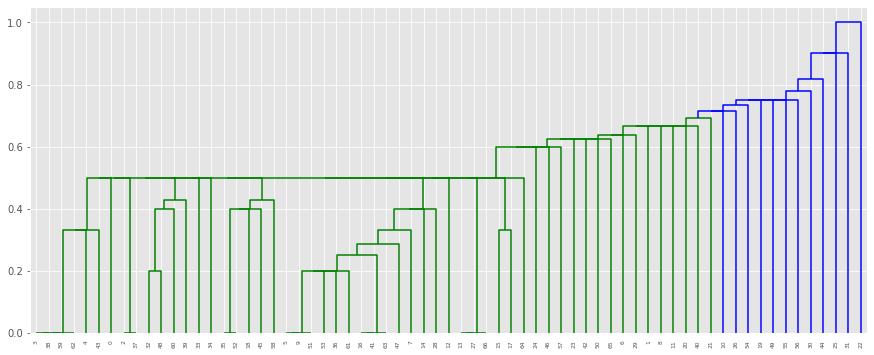

88


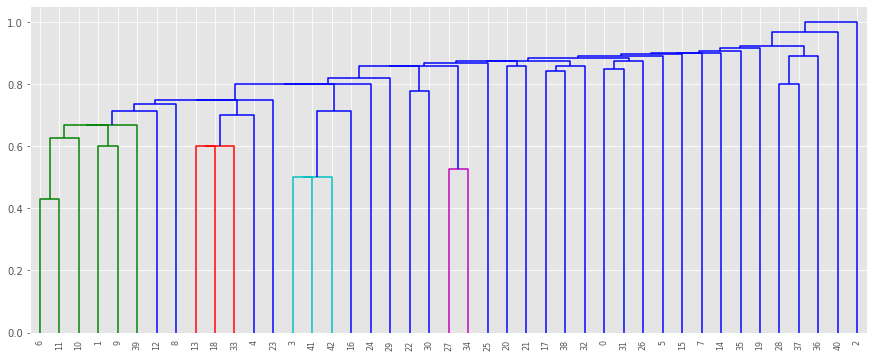

89


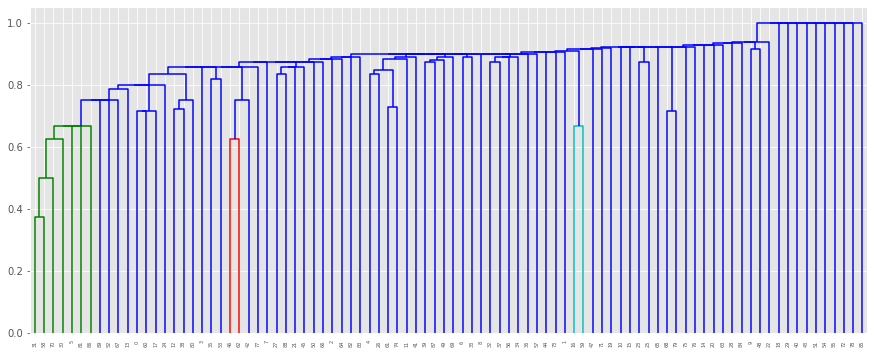

90


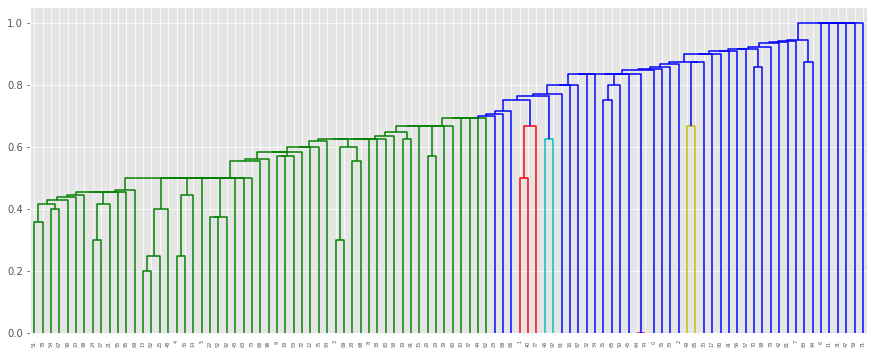

91


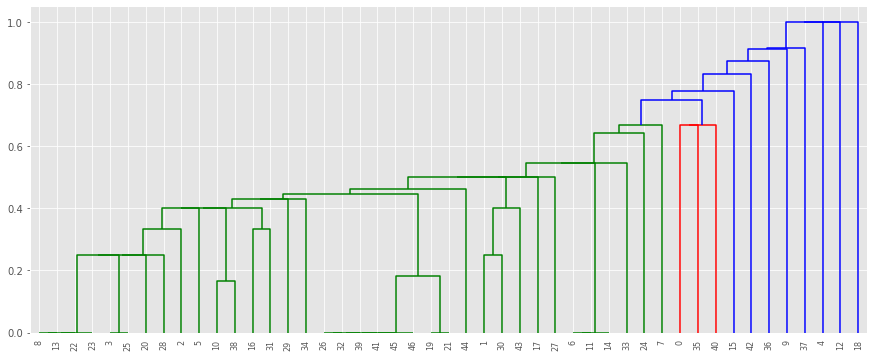

92


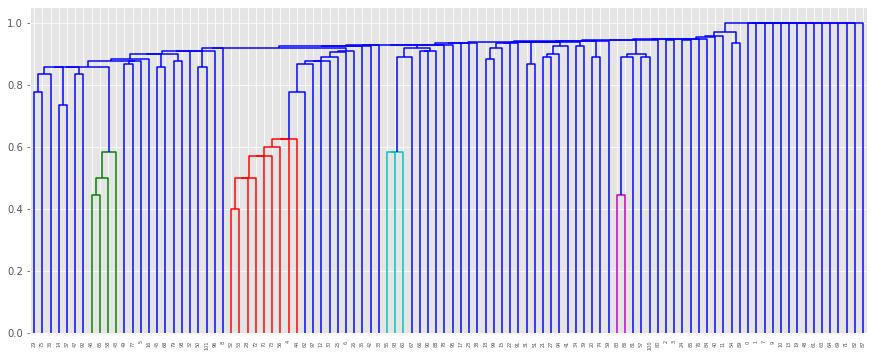

93


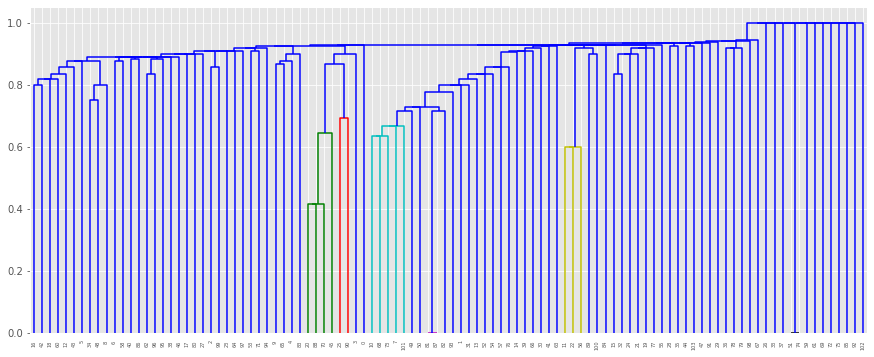

94


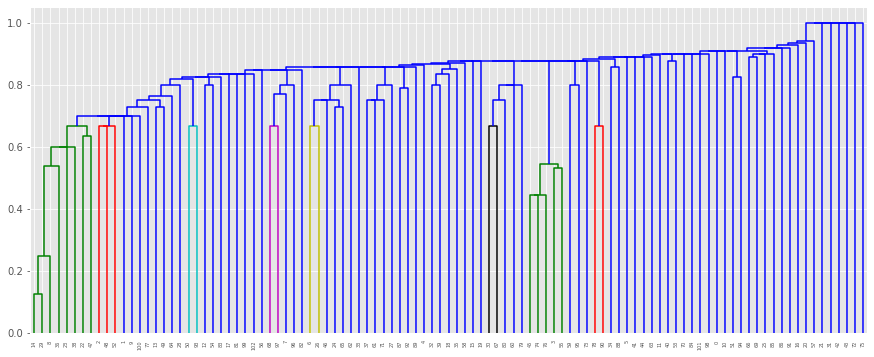

95


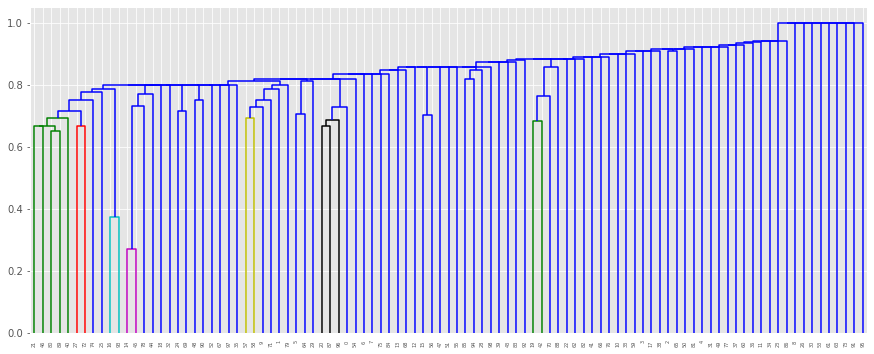

96


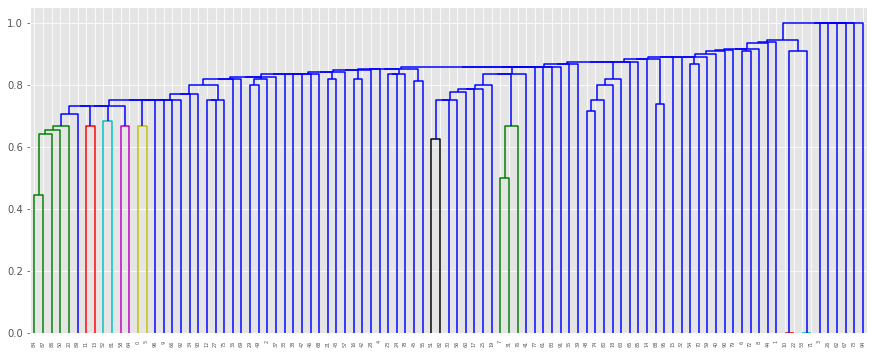

97


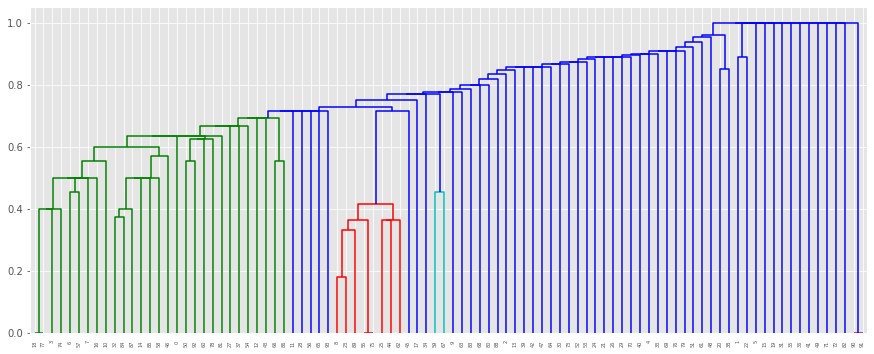

98


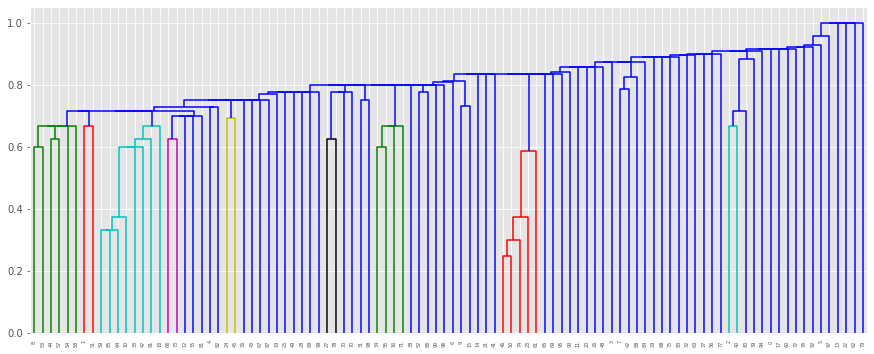

99


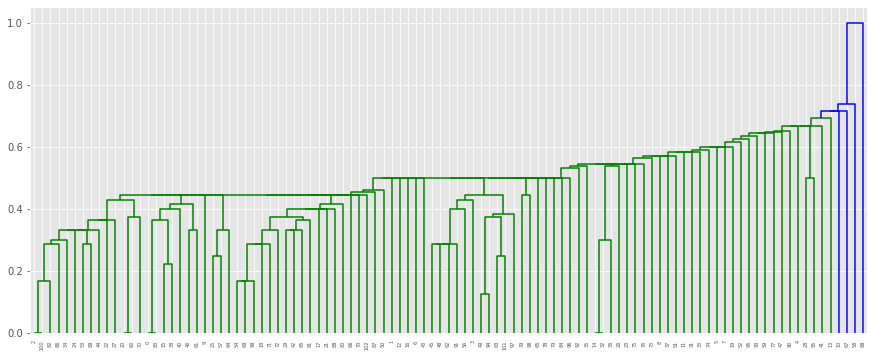

100


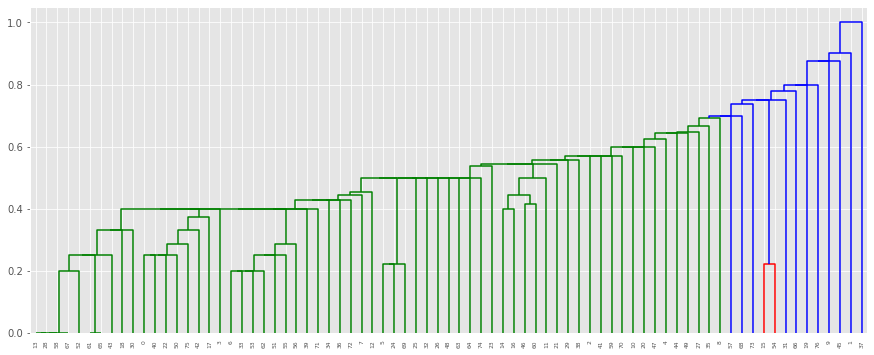

101


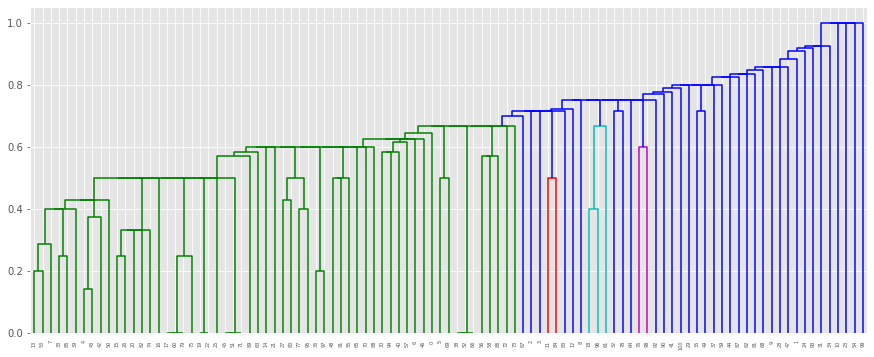

102


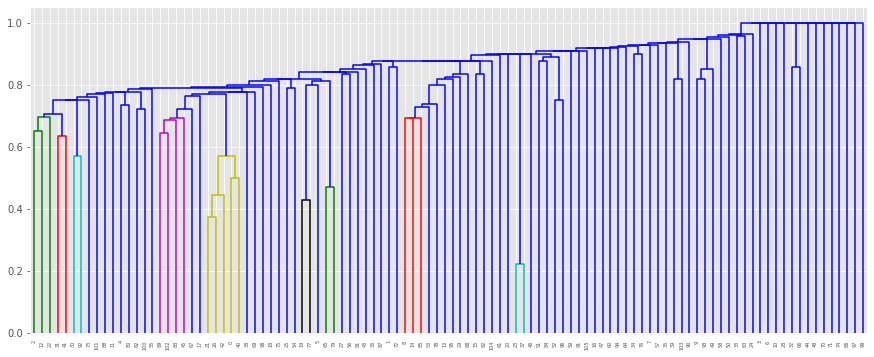

103


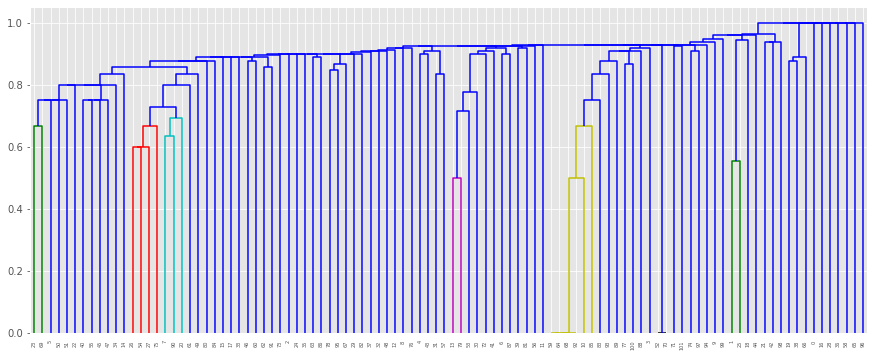

104


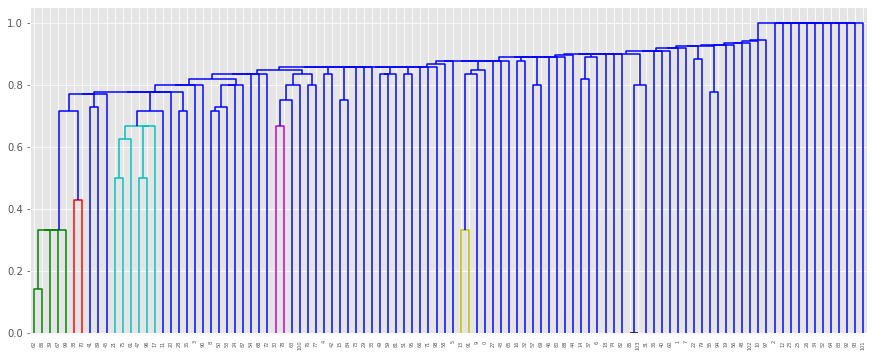

105


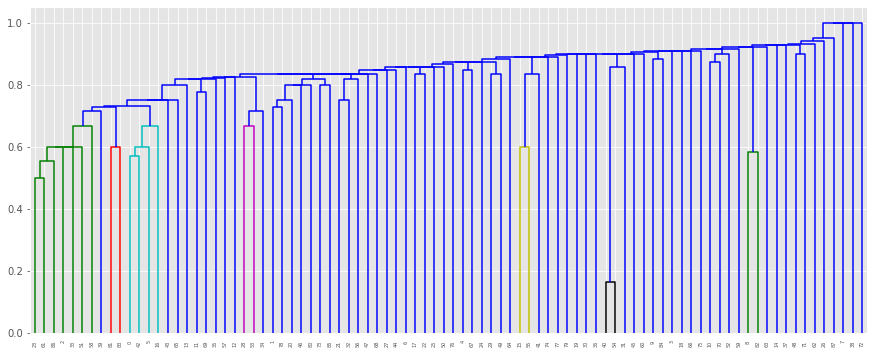

106


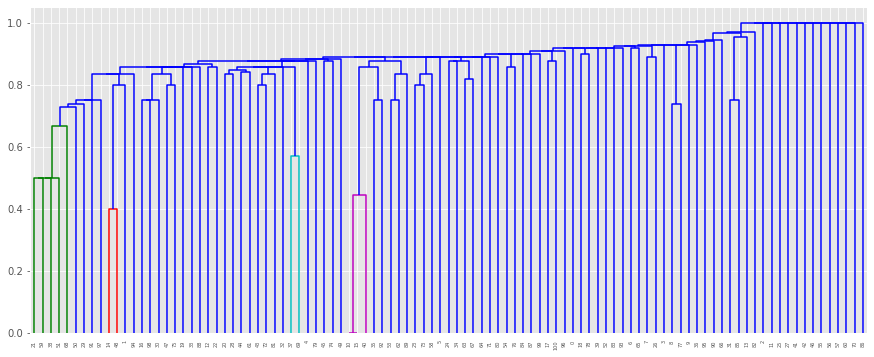

107


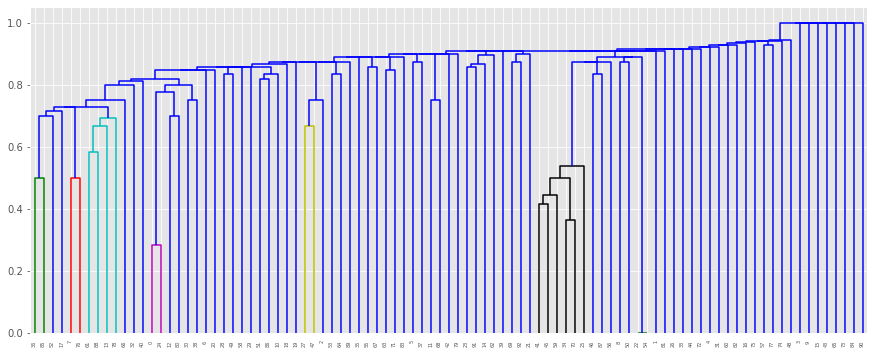

108


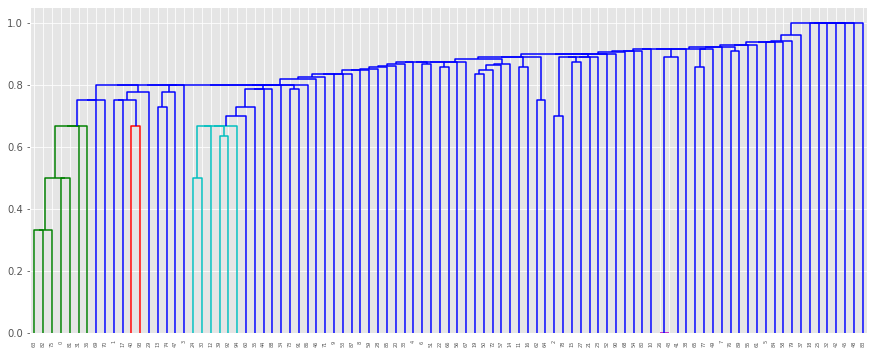

109


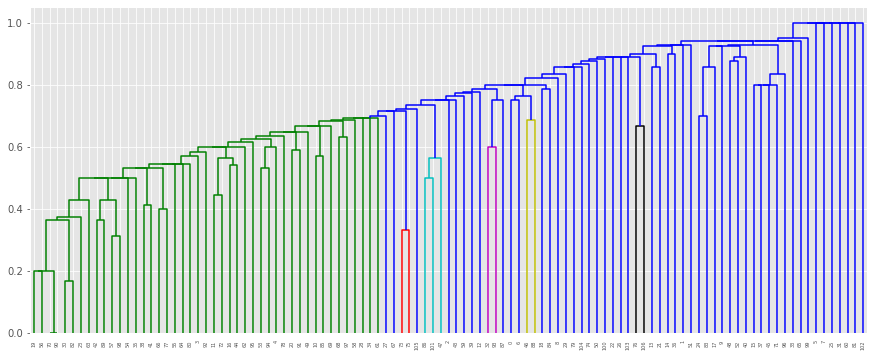

110


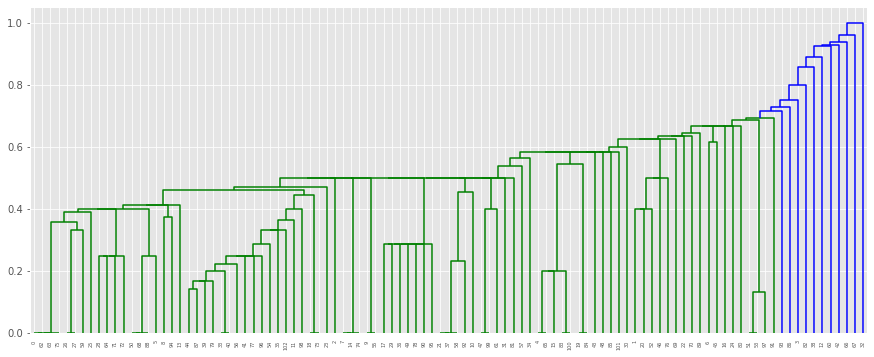

111


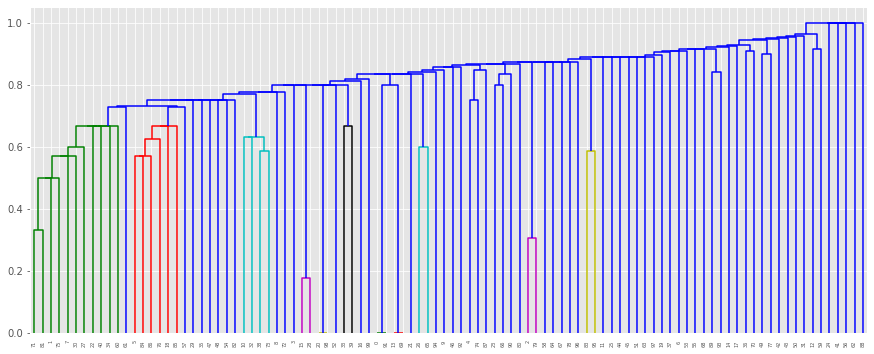

112


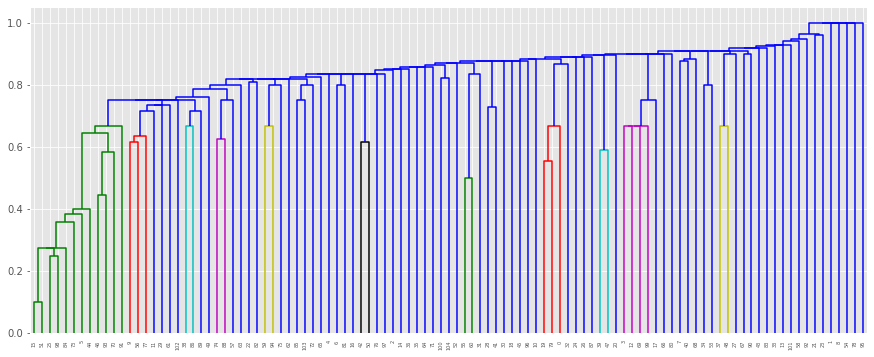

113


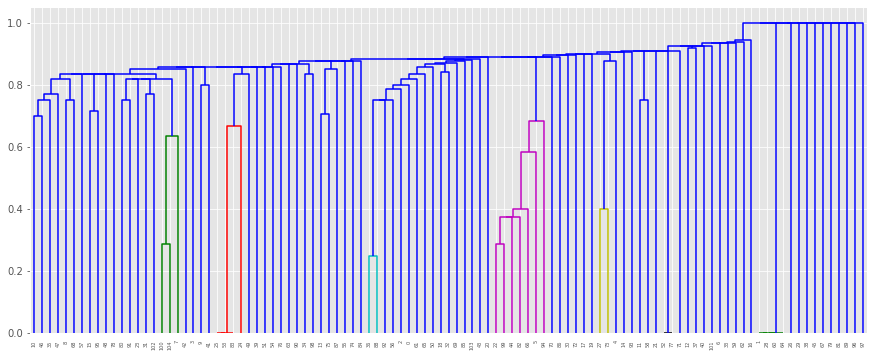

114


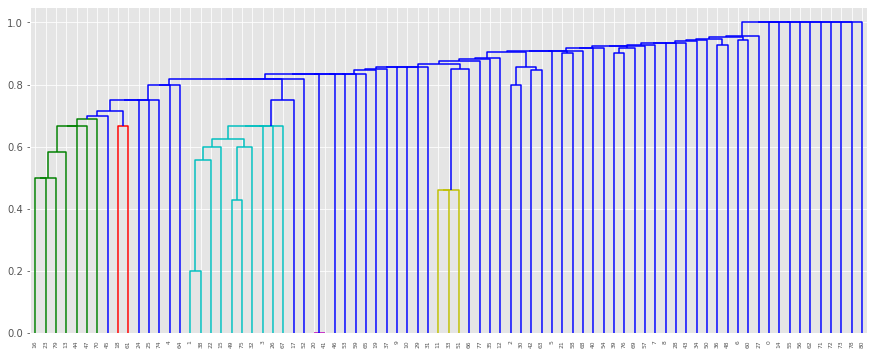

115


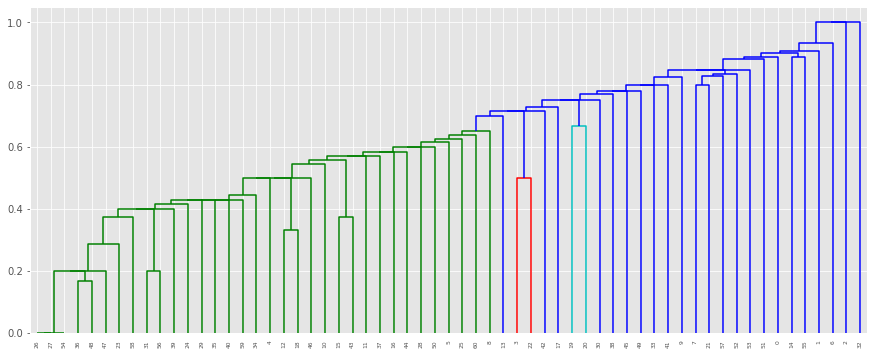

116


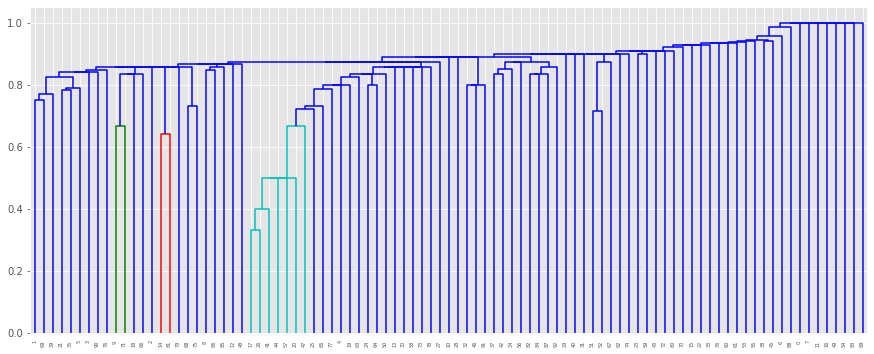

117


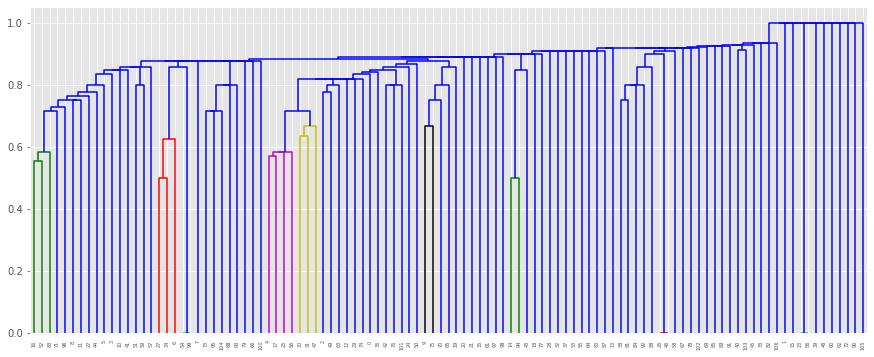

118


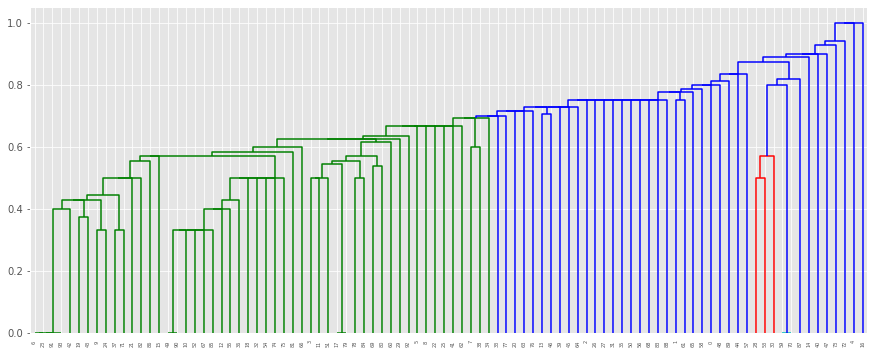

119


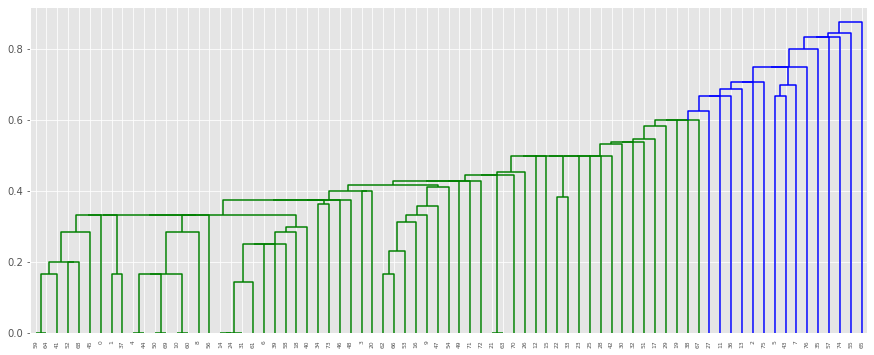

120


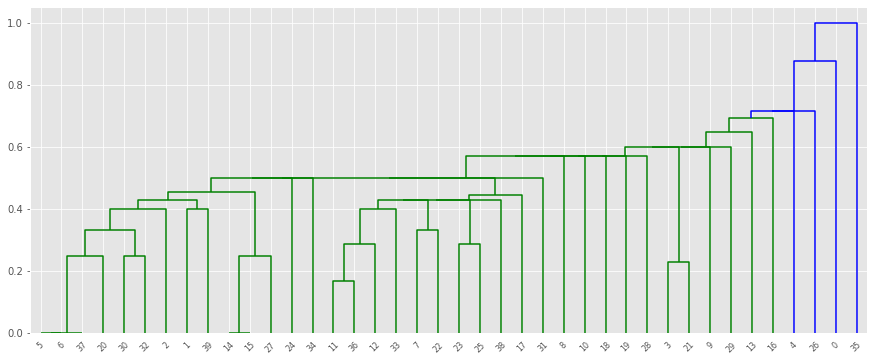

121


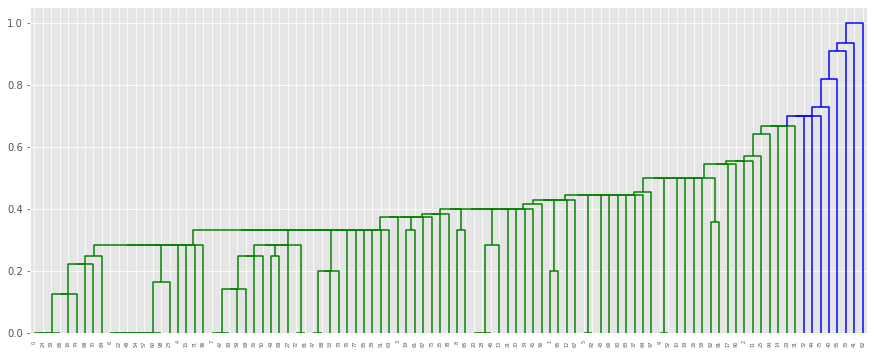

122


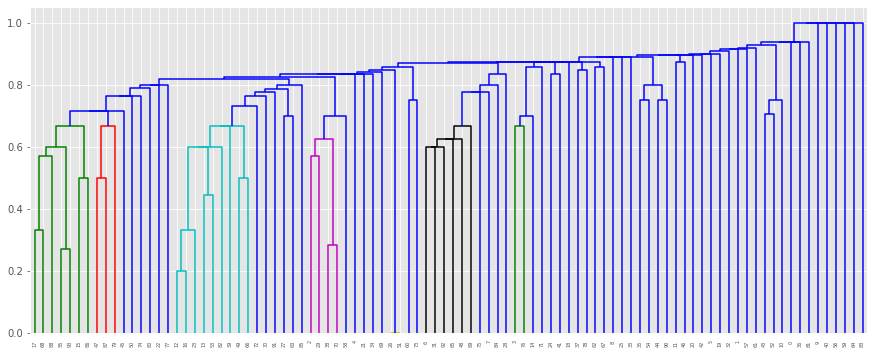

123


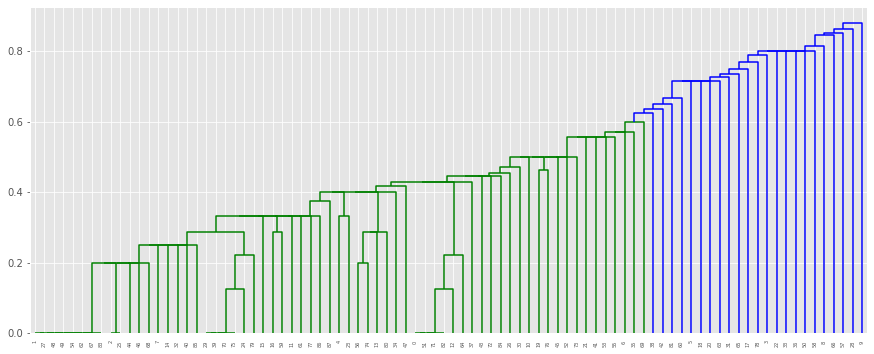

124


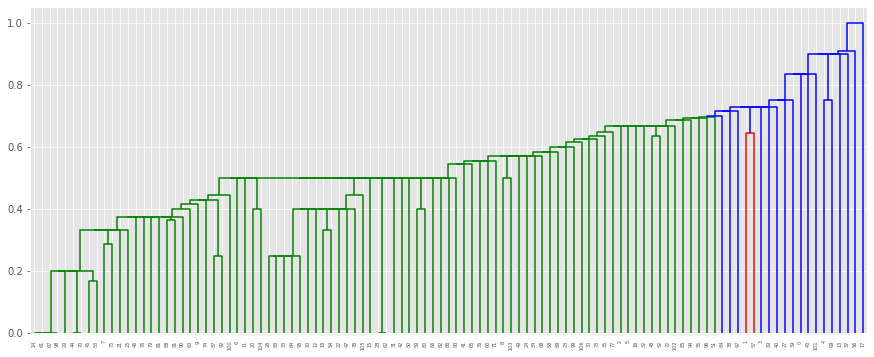

125


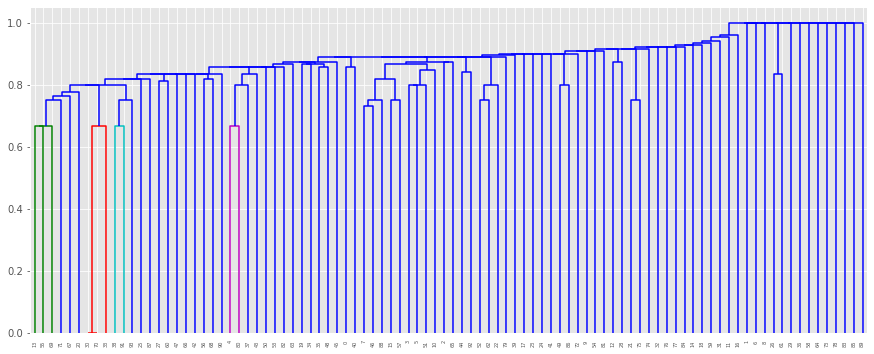

126


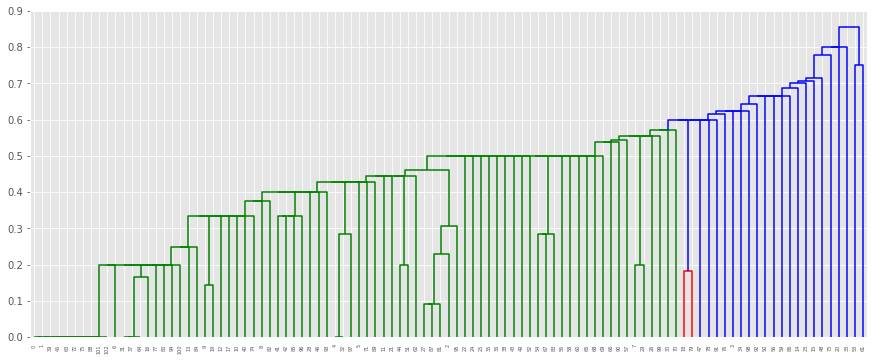

127


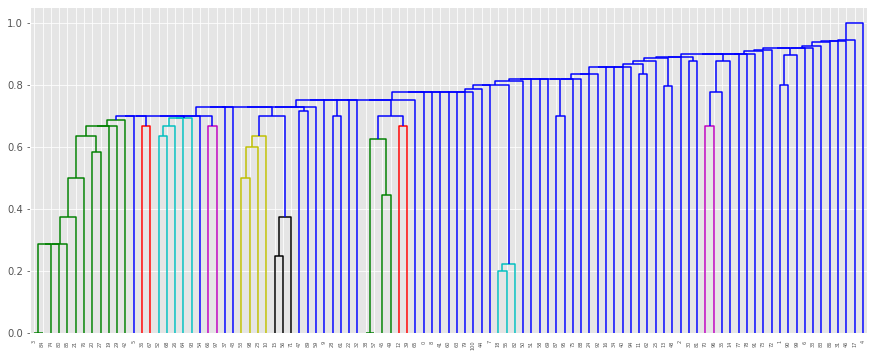

128


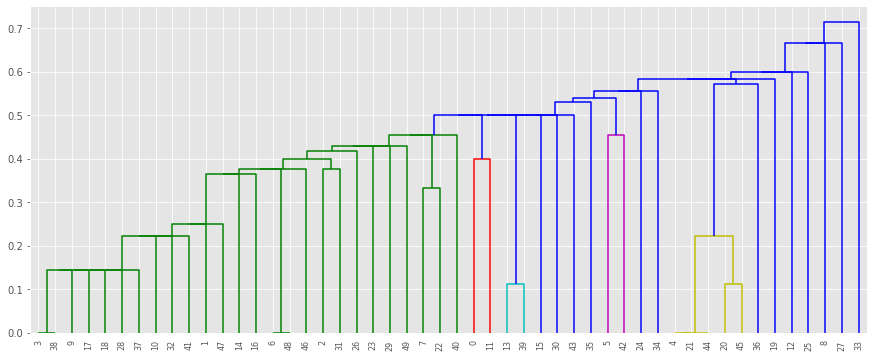

129


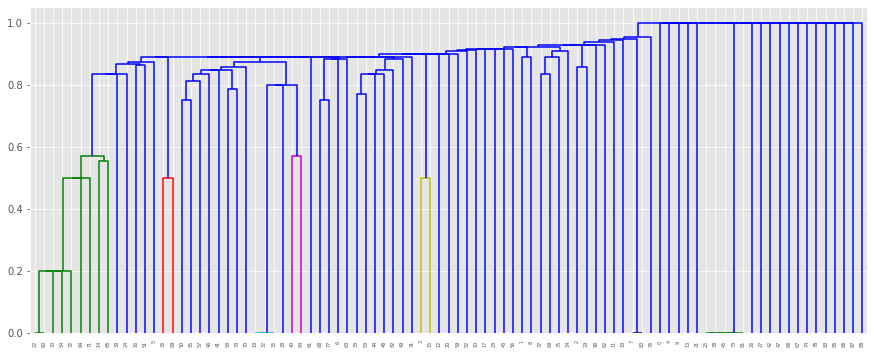

In [15]:
link='single'

for gr,value in traingroups_titledata.items():
    words=dict()
    for i in value:
        for word in i[1]:
            if word not in words:
                words[word]=len(words)
                
    x=np.zeros((len(value),len(words)))
    
    y=np.empty(len(value)).astype(int)
    

    for ind,i in enumerate(value):
        for word in i[1]:
            x[ind,words[word]]=1
        y[ind]=i[2]
    
    intercept=(x[...,np.newaxis]*x.T[np.newaxis]).sum(axis=1)
    summ=x.sum(axis=1)
    summ=(summ[np.newaxis]+summ[...,np.newaxis])-intercept
    summ[summ==0]=intercept[summ==0]
    summ[summ==0]=1
    
    x=1-intercept/summ
    

    сustum_aggl = Clustering(metric='precomputed',n_clusters=1,linkage=link)
    a=сustum_aggl.fit(x)
    fig=plt.figure(figsize=(15,6))
    print(gr)
    a.plot_dendrogram()


**Получилось очень схоже, косинусная работает лучше. Это и логично, так как косинусная делает примерно то-же самое, но ещё и взвешивает**

**1)Смотря на дендограмму можно найти аномалии. Аномалии - это объекты, которые совсем не похожи на основные кластера. Значит они будут объединяться с основными кластерами в последню очередь<br>
2)Косинусное, так оно подходит по смыслу задачи(по сути пересечение с весом), + оно уже нормировано**

**Поставлю некий порог расстояния начиная с которого кластера уже не объединяются. Далее поставлю единицы там, где в кластере уже есть хотя-бы 4 элемента, в остальных позициях поставлю 0**

In [16]:
link='single'
metr='cosine'
th=0.55
y_true=[]
Y_pred=[]
for gr,value in traingroups_titledata.items():
    words=dict()
    for i in value:
        for word in i[1]:
            if word not in words:
                words[word]=len(words)

    x=np.zeros((len(value),len(words)))
    y=np.empty(len(value)).astype(int)
    

    for ind,i in enumerate(value):
        for word in i[1]:
            x[ind,words[word]]=1
        y[ind]=i[2]
        y_true.append(i[2])
    
    сustum_aggl = Clustering(metric=metr,n_clusters=None,linkage=link,distance_threshold=th)
    y_pred=сustum_aggl.fit_predict(x)
    
    un=np.unique(y_pred)
    count=(y_pred[...,np.newaxis]==un[np.newaxis]).sum(axis=0)
    mask_one=((y_pred[...,np.newaxis]==un[count>3][np.newaxis]).sum(axis=1)).astype(bool)
    
    y_pred[mask_one]=1
    y_pred[~mask_one]=0
    
    Y_pred+=list(y_pred)
print('fscore =',smt.f1_score(y_true,Y_pred))

fscore = 0.7132530120481929


**3)fscore = 0.7132530120481929, baseline преодалён. <br>
4)Если мы кластеризовали на фиксированное количество кластеров, то можно обучать нашу модель отдельно на каждом кластере. Можно подать выход кластеризации нашей модели в качестве признаков.**

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

**Кластеризация уже даёт решение лучшее, чем baseline, поэтому просто кластеризую**

In [17]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
pair_id=[]
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))
    pair_id.append(new_doc['pair_id'])
pair_id=np.array(pair_id)

In [18]:
link='single'
metr='cosine'
th=0.55

Y_pred=[]
for gr,value in testgroups_titledata.items():
    words=dict()
    for i in value:
        for word in i[1]:
            if word not in words:
                words[word]=len(words)

    x=np.zeros((len(value),len(words)))
    
    for ind,i in enumerate(value):
        for word in i[1]:
            x[ind,words[word]]=1
        
    
    
    сustum_aggl = Clustering(metric=metr,n_clusters=None,linkage=link,distance_threshold=th)
    y_pred=сustum_aggl.fit_predict(x)
    
    un=np.unique(y_pred)
    count=(y_pred[...,np.newaxis]==un[np.newaxis]).sum(axis=0)
    mask=((y_pred[...,np.newaxis]==un[count>3][np.newaxis]).sum(axis=1)).astype(bool)
    
    y_pred[mask]=1
    y_pred[~mask]=0
    
    Y_pred+=list(y_pred)

In [19]:
with open('ans.csv','w',encoding="utf8") as f:
    print('pair_id,target',file=f)
    for i,pair in enumerate(pair_id):
        print(pair,f',{Y_pred[i]}',file=f,sep='')

**Финальный fscore = 0.70244**

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** Домашки с теорией, алгоритмом и применением - очень классные. Все домашки должны быть такие***